In [1]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/ddpg/#ddpg_continuous_actionpy
import os
import random
import time
from dataclasses import dataclass

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import tyro
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] ="expandable_segments:True"
import gymnasium as gym

#import gym
import numpy as np

import collections
import pickle
import tqdm

from stable_baselines3.common.buffers import ReplayBuffer


import os
import random
import time
from dataclasses import dataclass

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tyro
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

from typing import Optional

import functools
import random
from copy import copy

import numpy as np
from gymnasium.spaces import Discrete, MultiDiscrete, Box, Dict

from pettingzoo import AECEnv



import gymnasium


from pettingzoo.utils import agent_selector, wrappers

from gymnasium.utils import EzPickle



from statistics import NormalDist

import pygame

from typing import Any , Generic, Iterable, Iterator, TypeVar
ActionType = TypeVar("ActionType")

import collections
from torch.utils.data import Dataset, DataLoader


In [3]:
from  Utilities.new_models import *
from  Utilities.Transformer_risk_act_2 import *
import utils_gym
import env_model_class_2


from board_env import *



%load_ext autoreload
%autoreload 2

In [4]:
from IPython.display import clear_output, display

In [5]:
# model arch def

In [6]:


@dataclass
class Args:
    exp_name: str = 'Tiny_Risk'#os.path.basename(__file__)[: -len(".py")]
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""
    save_model: bool = False
    """whether to save model into the `runs/{run_name}` folder"""
    upload_model: bool = False
    """whether to upload the saved model to huggingface"""
    hf_entity: str = ""
    """the user or org name of the model repository from the Hugging Face Hub"""

    # Algorithm specific arguments
    env_id: str = "Tiny_Risk" #"Hopper-v4"
    """the environment id of the Atari game"""
    total_timesteps: int = 1000000
    """total timesteps of the experiments"""
    learning_rate: float = 3e-4
    """the learning rate of the optimizer"""
    buffer_size: int = int(1e6)
    """the replay memory buffer size"""
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 0.005
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 256
    """the batch size of sample from the reply memory"""
    exploration_noise: float = 0.1
    """the scale of exploration noise"""
    learning_starts: int = 25e3
    """timestep to start learning"""
    policy_frequency: int = 2
    """the frequency of training policy (delayed)"""
    noise_clip: float = 0.5
    """noise clip parameter of the Target Policy Smoothing Regularization"""


def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env

    return thunk

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, obs,action,h_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(obs + h_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

        self.embed_action = layer_init(torch.nn.Linear(2, h_dim), std=0.01)

    def forward(self, x, a1,a2):
        #x = torch.cat([x, a], 1)
        a = torch.concat((a1,a2),axis = -1)
        a = self.embed_action(a)

        x = torch.concat((x,a),axis = 1)

        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def differentiable_randomized_argmax(softmax_output, temperature=1.0):

    if temperature < 0:
        raise ValueError("Temperature must be non-negative.")
    max_prob = torch.max(softmax_output, dim=-1, keepdim=True)[0]
    top_k_mask = (softmax_output == max_prob).float()
    # Generate Gumbel noise
    gumbel_noise = -torch.log(-torch.log(torch.rand_like(softmax_output) + 1e-9) + 1e-9)  # Adding small epsilon for numerical stability

    # Add Gumbel noise to logits (implicitly working with logits since softmax_output is probabilities)
    # To make it more numerically stable if starting from probabilities, you might want to work with logits directly if possible.
    # However, we can approximate logits from probabilities (though it might lose some precision)
    # logits = torch.log(softmax_output + 1e-9) # Avoid log(0)
    # noisy_logits = logits + gumbel_noise

    # More directly with probabilities (and numerically safer)
    noisy_logits = torch.log(softmax_output + 1e-9) + gumbel_noise * top_k_mask # Approximate logits then add noise
    noisy_output = nn.functional.softmax(noisy_logits / temperature, dim=-1) # Apply softmax with temperature

    a=torch.argmax(noisy_output,-1)
    
    return a



class ActorDiscrete(nn.Module):
    def __init__(self, obs, action_space): # Pass action_space instead of env
        super().__init__()
        self.fc1 = nn.Linear(obs, 256) # Use obs.shape directly
        self.fc2 = nn.Linear(256, 256)
        self.fc_pi = nn.Linear(256, action_space) # Output size is the number of discrete actions

    def forward(self, x,action_mask=[],use_action_mask=True,give_prob=False):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc_pi(x) # Output logits for each discrete action
        
        if use_action_mask:
            probs = (F.softmax(logits*action_mask + 1e-9, dim=-1)) # Apply softmax to get probabilities
        else:
            probs = (F.softmax(logits+ 1e-9, dim=-1))
        if give_prob:
            return probs # Return the probability distribution over actions
        else:
            dis = Categorical(probs)
            acts = dis.sample()
            return  acts#differentiable_randomized_argmax(probs)

class Actor(nn.Module):
    def __init__(self, obs,action_space,h_dim = 6):
        super().__init__()
        self.fc1 = nn.Linear(obs+h_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, 1)
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((1 - 0) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((1 - 0) / 2.0, dtype=torch.float32)
        )
        self.embed_action_1 = torch.nn.Embedding(action_space+1, h_dim)

    def forward(self, x,a):
        
    
        a = self.embed_action_1(a.long())

        x = torch.concat((x,a),axis = -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

In [7]:
class PG_ValueNetwork(nn.Module): # Renamed from QNetwork to ValueNetwork
    def __init__(self, obs): # Removed action input from __init__
        super().__init__()
        self.fc1 = nn.Linear(obs, 256) # Input is now just observation
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1) # Output is a single value (V-value)

    def forward(self, x): # Removed action inputs a1, a2 from forward
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class PG_ActorDiscrete(nn.Module):
    def __init__(self, obs, action_space): # Pass action_space
        super().__init__()
        self.fc1 = nn.Linear(obs, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_pi = nn.Linear(256, action_space) # Output logits for each discrete action

    def forward(self, x, action_mask=[], use_action_mask=True, give_prob=False,give_action=True): # Always give probabilities in forward
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc_pi(x) # Output logits

        if use_action_mask:
            probs = (F.softmax(logits * action_mask + 1e-9, dim=-1)) # Softmax with mask
        else:
            probs = (F.softmax(logits + 1e-9, dim=-1)) # Softmax without mask

        if give_prob and not give_action:
            return probs # Return the probability distribution over actions
        elif (not give_prob) and give_action:
            dis = Categorical(probs)
            acts = dis.sample()
            return  acts#differentiable_randomized_argmax(probs)
        else:
            dis = Categorical(probs)
            acts = dis.sample()
            return  probs, acts#differentiable_randomized_argmax(probs)            

    def get_logprob(self, observations, actions, action_mask=[], use_action_mask=True): # New method to get log probabilities
        probs = self.forward(observations, action_mask=action_mask, use_action_mask=use_action_mask,give_prob=True,give_action=False) # Get probabilities
        log_probs = torch.log(probs.gather(1, actions.long().unsqueeze(1)) + 1e-9) # Log prob of taken actions
        return log_probs.squeeze(1)


class PG_Actor(nn.Module):
    def __init__(self, obs, action_space, h_dim=6): # action_space is not directly used here, but kept for consistency if needed elsewhere
        super().__init__()
        self.fc1 = nn.Linear(obs + h_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, 1) # Output mean (mu)
        self.log_std = nn.Parameter(torch.zeros(1, 1)) # Learnable log std (or could be fixed std)
        self.embed_action_1 = torch.nn.Embedding(action_space + 1, h_dim) # Keep embedding layer

    def forward(self, x, a, give_dis= False, give_entropy=False):
        a = self.embed_action_1(a.long()) # Embed discrete action a1
        x = torch.concat((x, a), axis=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.fc_mu(x)) # Mean action (bounded by tanh)
        std = torch.exp(self.log_std) # Standard deviation (always positive)
        
        if give_entropy:
            entropy = torch.distributions.Normal(mu, std).entropy().squeeze(-1)
            
        
        if give_dis and not(give_entropy):
            return mu, std # Return both mean and std
        elif give_dis and give_entropy:
            return mu, std, entropy
        elif (not give_dis) and give_entropy:
            return mu, entropy
        else:
            return mu

    def get_logprob(self, observations, actions, a1): # New method to get log probabilities
        mu, std = self.forward(observations, a1,give_dis=True) # Get mean and std
        dist = torch.distributions.Normal(mu, std) # Create normal distribution
        log_prob = dist.log_prob(actions) # Log prob of given actions under this distribution
        return log_prob.squeeze(1) # Return log probs, squeezed

## env config

In [8]:
from stable_baselines3.common.buffers import ReplayBuffer

In [9]:
env_config = dict(render_mode = None,#'rgb_array', 
                    default_attack_all  = True,
                    agent_count  = 3#4
                    ,use_placement_perc=True,
                    render_=False,
                    bad_mov_penalization = 0.01
                 )


# Hero agent def

## base hero agent

In [10]:
import numpy as np



        #self.model = 



class Hero_agent(int):
    def init_properties(self,agent_count,phases,cp=[],df=[],direct_action=True):
        #self.draw_count = 0
        self.init_win_count_iter(agent_count)
        self.init_move_count_epi(phases)
        self.cp = cp
        self.df = df
        self.direct_action = direct_action
        self.init_reward_concern(agent_count,cp=cp,df=df)
        
    def init_reward_concern(self,agent_count,cp=[],df=[]):
        if len(cp)==0:
            cp = [int(self)]
        self.concern=torch.tensor([(1 if i in cp 
                             else 
                             (-1 if i in df 
                                  else 0)) for i in range(1,agent_count+1) ])
        #self.concern_2 = self.concern
        #self.concern_2[self-1] =0
        
        self.multi_dependency = (sum(self.concern !=0)>1)
        
        
    def init_model(self,model_name="DDQN_module",
                   kwarg = dict({})):
        self.model = model_selector(model_name=model_name, 
                                    kwarg = kwarg)

        
    def init_win_count_iter(self,agent_count):
        self.count_dict = {i:0 for i in range(1,agent_count+1)}
        self.count_draw_dict = {i:0 for i in range(1,agent_count+1)}
        self.draw_territory_count = 0
    def init_move_count_epi(self,phases):
        self.bad_move_count = 0
        self.bad_move_phase_count = {i:0 for i in phases}
        self.move_count =  {i:0 for i in phases}        
    
    def model_def(self, model):
        self.model =model

    def action_predict(self,save_R=True,return_R = False,action_masks = [],return_log_prob_a2 = False):
        return self.model.action_predict(save_R=save_R,return_R = return_R, action_masks = action_masks,return_log_prob_a2 = return_log_prob_a2)

    def action_predict_direct(self,data,return_R = False,return_log_prob_a2 = False):
        return self.model.action_predict_direct(data,return_R = return_R,return_log_prob_a2 = return_log_prob_a2)
    def save_models(self):
        self.model.save_models()

    def process_reward(self,rewards,step,hero_steps):
        if self.multi_dependency and self.direct_action:
            return (rewards*self.concern.to(rewards.device)).sum(-1)[:step][hero_steps][:,None]
        elif self.multi_dependency and not self.direct_action:
            base_rew = torch.zeros( rewards[:step,self-1][hero_steps].shape,require_grad=False)
            #print(base_rew)

            
            hero_step_list  = np.arange(0,step)[hero_steps]
            for i,j in zip(hero_step_list[:-1],hero_step_list[1:]):
                if j-i>1:
                    #print(j,i,rewards[i:j],(rewards[i:j]*self.concern),(rewards[i:j]*self.concern).sum())
                    base_rew[i]+= (rewards[i:j]*self.concern).sum()
            #print(base_rew,rewards[hero_step_list[-1]:],(rewards[hero_step_list[-1]:]*self.concern))
            base_rew[-1]+= (rewards[hero_step_list[-1]:]*self.concern).sum()
            
            return base_rew[:,None]
            
        else:
            return rewards[:step][hero_steps][:,None]


    def init_model_config(self,args):
        self.args = args

    def init_memory_config(self,args):
        self.args = args
        
    def init_loss_config(self,args):
        self.args = args
        
    









    
    #def model_forward_call(self,name,kwarg):
    #    return self.model_dict[name](**kwarg)



## Memory agent

In [11]:
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.type_aliases import (
    ReplayBufferSamples,
    RolloutBufferSamples,
)
from stable_baselines3.common.preprocessing import get_action_dim, get_obs_shape


from typing import Dict, Generator, NamedTuple, Optional, Union

import numpy as np
import torch as th

In [12]:
class ReplayBufferSamples(NamedTuple):
    observations: th.Tensor
    actions: th.Tensor
    next_observations: th.Tensor
    dones: th.Tensor
    rewards: th.Tensor
    mask: th.Tensor
    t_pow: th.Tensor
    

In [13]:
from gymnasium import spaces as spaces_

In [14]:
class CustomReplayBuffer(ReplayBuffer):

    def __init__(self, *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.mask = np.zeros((self.buffer_size, 32), dtype=np.float32)  # Add a new array for custom feature
        self.t_pow = np.zeros((self.buffer_size, 1), dtype=np.float32)


    def add(self, obs, action, reward, next_obs, done, mask,t_pow):  # Add custom value when adding data

        super().add(obs, action, reward, next_obs, done,{'t':t_pow})

        self.mask[self.pos] = mask
        self.t_pow[self.pos] = t_pow

    def _get_samples(self,  batch_inds: np.ndarray, env: Optional[VecNormalize] = None) -> ReplayBufferSamples:
        # ... (rest of the _get_samples code from SB3's ReplayBuffer) ...
        #custom_value = self.custom_feature[batch_inds] # Retrieve infos



        if self.optimize_memory_usage:
            next_obs = self._normalize_obs(self.observations[(batch_inds + 1) % self.buffer_size, 0, :], env)
        else:
            next_obs = self._normalize_obs(self.next_observations[batch_inds, 0, :], env)

        data = (
            self._normalize_obs(self.observations[batch_inds, 0, :], env),
            self.actions[batch_inds, 0, :],
            next_obs,
            self.dones[batch_inds],
            self._normalize_reward(self.rewards[batch_inds], env),
            self.mask[batch_inds],
            self.t_pow[batch_inds]
            
        )


        
        #data = (observations, actions, next_observations, dones, rewards, custom_value) # Include infos
        return ReplayBufferSamples(*tuple(map(self.to_torch, data))) # Or InfoReplayBufferSamples if you define it

    def sample(self, batch_size: int, env: Optional[VecNormalize] = None) -> ReplayBufferSamples: # Optionally adjust return type hint
        # ... (rest of the sample code from SB3) ...
        
        if not self.optimize_memory_usage:
            return super().sample(batch_size=batch_size, env=env)
        # Do not sample the element with index `self.pos` as the transitions is invalid
        # (we use only one array to store `obs` and `next_obs`)
        if self.full:
            batch_inds = (np.random.randint(1, self.buffer_size, size=batch_size) + self.pos) % self.buffer_size
        else:
            batch_inds = np.random.randint(0, self.pos, size=batch_size)      
        
        
        return self._get_samples(batch_inds, env=env)

In [15]:
class memory_agent(Hero_agent):
    def init_path(self):
        self.paths = []
    def path_que(self, dtl):
        
        if (len(self.paths)==self.rb_len):
            if (self.rb_len >1):
                self.paths.pop(random.randrange(len(self.paths)-self.args.num_episodes +1 )) # dont pop the most recent experiences and ensure rb_len > num.episodes
            else: 
                self.paths.pop()
        self.paths.append(dtl)
        
    def create_training_dataset(self):
        self.traj_dataset =  TrajectoryDataset_2_through_episodes(self.paths)  # a dataset of dataloaders

        self.traj_data_loader = DataLoader(  # only spit 1 episode a time
            self.traj_dataset,
            batch_size=1,
            shuffle=self.args.shuffle,
            pin_memory=self.args.pin_memory,
            drop_last=self.args.drop_last,
            pin_memory_device=self.args.pin_memory_device,
            )


    def init_CL_sample_store(self,num_steps,total_agents,total_phases):

        self.num_steps = num_steps
        self.total_agents = total_agents
        self.total_phases = total_phases
        self.DT_input = {  # self.actor_config_dict['ob_space']
                'timestep': torch.zeros((1,
                                        ),requires_grad =False).to(self.device,
                        dtype=torch.int),
                'state': torch.zeros((1,
                                     self.state_dim),requires_grad =False).to(self.device,dtype=torch.float32),
                'action_1': torch.zeros((1,
                                      )).to(self.device,dtype=torch.float32),
                'action_2': torch.zeros((1,
                                      )).to(self.device,dtype=torch.float32),
                
                'return_to_go': torch.ones((1,
                                    ),requires_grad =False).to(self.device,dtype=torch.float32) * 110,
                }            
    
        self.returntogo = torch.zeros((self.num_steps,
                1),requires_grad =False).to(self.device,dtype=torch.float32)  # self.total_agents
        self.returntogo_pred = torch.zeros((self.num_steps,
                1)).to(self.device,dtype=torch.float32)  # self.total_agents

    def update_CL_sample_store(
        self,
        curr_agent_,
        inp={'step': None, 'act_2_1': [],'act_2_2': [], 'curr_reward_list': []},
        before_action=True,
        ):
        self.DT_input['return_to_go'] = self.DT_input['return_to_go'] -    inp['curr_reward_list']  # [self.hero]
        self.returntogo[inp['step']] = self.DT_input['return_to_go']


    #rb = ReplayBuffer(
    #    args.buffer_size,
    #    envs.single_observation_space,
    #    envs.single_action_space,
    #    device,
    #    handle_timeout_termination=False,
    #)

#real_next_obs = next_obs.copy()
#rb.add(obs, real_next_obs, actions, rewards, terminations, infos)



    def init_buffer(self,action_space,
                    state_space=spaces_.Box(low=0,high=np.inf,shape=(#self.states.shape[1]
                                                                     77,),dtype = np.float32)
                    ,buffer_size = 30000):
        action_space.dtype = np.float32
        
        self.rb = CustomReplayBuffer(
                                    buffer_size,
                                    state_space,
                                    action_space,
                                    self.device,
                                    handle_timeout_termination=False,
                                )
    
    def update_train_data(
            self,
            step_count,
            obs,
            ob_space_shape,
            rewards_2,
            dones_2,
            actions_1,
            actions_2,
            log_probs_actions_2,
            action_masks,
            current_agent,
            current_agent_acting,
            current_phase,
            current_troops_count,
            map_agent_phase_vector
            ):
        

        data_ = collections.defaultdict(torch.tensor)
        #print(obs)
        #print(obs[:step_count].reshape(-1,
        #                            np.prod(ob_space_shape)))
        
        data_['observations'] =   obs[:step_count].reshape(-1,
                                    np.prod(ob_space_shape))

        data_['returntogo'] =      self.returntogo[:step_count]  # torch.tensor([1,2,3,4])
        data_['returntogo_pred'] = self.returntogo_pred[:step_count]  # torch.tensor([1,2,3,4])

        data_['rewards']   =       rewards_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['terminals'] =       dones_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['actions_1'] =       actions_1[:step_count]  # torch.tensor([1,2,3,4])
        data_['actions_2'] =       actions_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['log_probs_actions_2'] =log_probs_actions_2[:step_count]
        data_['action_masks'] =       action_masks[:step_count]
        data_['current_agent_acting']=current_agent_acting[:step_count]
        data_['current_agent_simple']=current_agent[:step_count]
        data_['current_agent'] =      map_agent_phase_vector(current_agent[:step_count],
                                   num_classes=self.total_agents + 1)[:, 1:]
        data_['current_phase'] =      map_agent_phase_vector(current_phase[:step_count],
                                   num_classes=self.total_phases)
        data_['current_troops_count']=current_troops_count[:step_count]

        


        self.data_ = data_
        hero_steps = data_['current_agent_simple'] == int(self)
        self.data_['hero_steps'] = hero_steps
        states = torch.cat((data_['observations'], data_['action_masks'] * hero_steps,
                              data_['current_phase'], data_['current_agent'],
                              data_['current_troops_count'][:, #:,
                                                        None]), axis=1)#2)  # ,torch.ones(len(action_masks))[:,None]*self.hero

        self.recalculate_rewards()
        self.states = states.to(dtype=torch.float32)
        data_['returns_to_go_cal'] = discount_cumsum(data_['rewards'], 0.99) / 1
        data_['current_troops_count']=(data_['current_troops_count'] - 5.2496)/1.4733


        

        data_['actions'] = torch.cat( (self.data_['actions_1'][:,None], 
                          self.data_['actions_2'][:,None]),axis =-1).to(dtype=torch.float32)

        
        
        for i in range(len(self.states)-1):
            if hero_steps[i]:
                self.rb.add(self.states[i], 
                       self.states[
                       i+self.data_['t_pow'][i]], 
                       self.data_['actions'][i], 
                       self.data_['rewards_2'][i], 
                       self.data_['terminals_2'][i], 
                       self.data_['action_masks'][i],
                       self.data_['t_pow'][i,None])
        


    def recalculate_rewards(self,gamma=0.99):


        lis1 = []
        lis2 = []
        
        self.data_['rewards_2'] = self.data_['rewards']*(self.data_['hero_steps'][:,0])
        self.data_['t_pow'] = torch.ones_like(self.data_['rewards_2'],dtype =torch.int32)
        for i,j in enumerate(self.data_['current_agent_simple'][:-1,0]):
            if j != self.data_['current_agent_simple'][i+1]:
                if j == 1:
                    lis1.append(i+1)
                if self.data_['current_agent_simple'][i+1]==1:
                    lis2.append(i+1)
                    
        for i,j in zip(lis2,lis1):

            ar = self.data_['rewards'][j:i]
            self.data_['rewards_2'][j-1
                        ] += ( ar*np.power([0.99],np.arange(len(ar)))).sum()
            self.data_['t_pow'][j-1] = i-j+1+1

        ar = self.data_['rewards'][lis1[-1]:] 
        self.data_['rewards_2'][lis1[-1]-1] = (ar*np.power([0.99],np.arange(len(ar)))).sum()

        last = (len(self.data_['hero_steps'][:,0])-1 if self.data_['hero_steps'][-1,0]
                else lis1[-1])
        self.data_['terminals_2'] = np.arange(len(self.data_['hero_steps'][:,0]))==last
        self.data_['t_pow'][lis1[-1]-1] = len(ar)

        


In [16]:

#env.action_space(1)

In [17]:
def discount_cumsum(x, gamma,Torch = True):
    if Torch:
        disc_cumsum = torch.zeros_like(x,dtype = torch.float32)
    else:
        disc_cumsum = np.zeros_like(x,dtype = np.float32)
    
    disc_cumsum[-1] = x[-1]
    #print(disc_cumsum[-1])
    for t in reversed(range(x.shape[0]-1)):
        disc_cumsum[t] = x[t] + gamma * disc_cumsum[t+1]
        #print(x[t],disc_cumsum[t])
    return disc_cumsum

## DDPG agent

In [31]:
class Hero_agent_DDPG(memory_agent):
    #def __init__(self):
    #    super().__init__()

    def set_device(self,device='cpu'):
        self.device = device

    def current_model_in(
        self,
        observation,
        curr_agent,
        phase_mapping,
        curr_agent_mapping,
        env_board_agents=[],
        ):



        #single obs
        self.model_in =  torch.hstack((observation['observation'
                         ].reshape(-1).to(self.device),
                         torch.tensor(observation['action_mask'
                         ].reshape(-1)).to(self.device) * (curr_agent
                         == self), phase_mapping.to(self.device),
                         curr_agent_mapping.to(self.device),
                         ( (torch.tensor([env_board_agents[self].bucket]).to(self.device) - 5.2496)/1.4733
                                      )))[None,
                         :].float().requires_grad_(False).to(self.device)  
    def init_model(self,actor_config_dict,args,device, writer,run_name,agent):

        self.args = args
        self.set_device(device)

        self.state_dim = actor_config_dict['ob_space'] 
        self.act_dim = actor_config_dict['action_space']
        
        self.actor1 = ActorDiscrete(self.state_dim,self.act_dim).to(device)
        self.actor2 = Actor(self.state_dim,self.act_dim).to(device)
        
        self.target_actor1 = ActorDiscrete(self.state_dim,self.act_dim).to(device)
        self.target_actor1.load_state_dict(self.actor1.state_dict())
        
        self.target_actor2 = Actor(self.state_dim,self.act_dim).to(device)
        self.target_actor2.load_state_dict(self.actor2.state_dict())
        
        self.qf1 = QNetwork(self.state_dim,2).to(device)
        self.qf1_target = QNetwork(self.state_dim,2).to(device)
        self.qf1_target.load_state_dict(self.qf1.state_dict())



        self.init_model_config(writer=writer
                            ,agent=agent
                            ,run_name=run_name
                            ,args=self.args)
        self.init_optim()

    def action_predict(self,data,mask=[],use_action_mask=False,no_grad = 1):
        if no_grad==1:
            with torch.no_grad():
                a1 = self.actor1(data,action_mask=mask,use_action_mask=use_action_mask)
                a2 = self.actor2(data,a1)
                v = self.qf1(data,a1[:,None],a2)
        elif no_grad ==2:
            a1 = self.actor1(data,action_mask=mask,use_action_mask=use_action_mask)
            a2 = self.actor2(data,a1.clone().detach())
            v = self.qf1(data,a1[:,None],a2)
            
        else:
            a1 = self.actor1(data)
            a2 = self.actor2(data,a1)
            v = self.qf1(data,a1[:,None],a2)

        return a1,a2,v

    def init_model_config(self,writer
                            ,agent
                            ,run_name
                            ,args):
        self.writer = writer
        self.hero = agent
        self.args = args
        self.run_name = run_name
        self.set_device(args['device']) # config['device']
        self.n_blocks = args['model_config']['n_blocks']
        self.embed_dim = args['model_config']['embed_dim']
        self.context_len = args['model_config']['context_len']
        self.n_heads = args['model_config']['n_heads']
        self.dropout_p = args['model_config']['dropout_p']
        



        self.num_steps = args['num_steps']
        self.total_agents = args['total_agents']
        self.total_phases = args['total_phases']

        #init other dep
        self.init_memory_config(args)
        self.init_loss_config(args)
        self.init_optim()


    def init_memory_config(self,args):
        self.rb_len = args['model_config']['rb_len']
        self.chunk_size = args['model_config']['chunk_size']
        self.chunk_overlap = args['model_config']['chunk_overlap']
        
    def init_loss_config(self,args):
        self.lr = args['learning_rate']
        self.warmup_epoch = args['model_config']['warmup_epoch']
        self.total_epoch = args['model_config']['total_epoch']
        self.initial_lr =  args['model_config']['initial_lr'] #5e-4
        self.final_lr =  args['model_config']['final_lr'] #1e-6
        
        self.tau = args['model_config']['tau']        
        self.beta = args['model_config']['beta']         #0.2 #Q_mse
        self.alpha =args['model_config']['alpha']          #0.1  #actionloss
        self.entropy_coeff = args['model_config']['entropy_coeff']         #0.1#0.5   #entropy loss in action
        self.val_loss_coeff = args['model_config']['val_loss_coeff']        #0.5      #Q loss

        self.gamma = args['gamma'] #0.99
        self.policy_frequency = args['model_config']['policy_frequency'] #10
        self.tau= args['model_config']['tau']#0.15

                    
    def init_optim(self):
        
        self.q_optimizer = optim.Adam(list(self.qf1.parameters()), lr=self.lr)
        
        self.actor1_optimizer = optim.Adam(list(self.actor1.parameters()), lr=self.lr)
        self.actor2_optimizer = optim.Adam(list(self.actor2.parameters()), lr=self.lr)



    def init_win_count_iter(self,agent_count):
        self.count_dict = {i:0 for i in range(1,agent_count+1)}
        self.count_draw_dict = {i:0 for i in range(1,agent_count+1)}
        self.draw_territory_count = 0
    
    def init_move_count_epi(self,phases):
        self.bad_move_count = 0
        self.bad_move_phase_count = {i:0 for i in phases}
        self.move_count =  {i:0 for i in phases}  
    
    def train_outer():
        pass
    
    def train(self,epoch,iteration, batch_size = 100):

        losses_ret =dict({})
        data= self.rb.sample(batch_size)
        with torch.no_grad():
            next_state_actions1 = self.target_actor1(data.next_observations,action_mask=[],use_action_mask=False,give_prob=False)
            next_state_actions2 = self.target_actor2(data.next_observations,
                                                     next_state_actions1)
            qf1_next_target = self.qf1_target(data.next_observations, next_state_actions1[:,None], next_state_actions2)
            next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * np.power(self.gamma,data.t_pow.flatten()) * (qf1_next_target).view(-1)

        qf1_a_values = self.qf1(data.observations, data.actions[:,0,None], data.actions[:,1,None] ).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)

        # optimize the model
        self.q_optimizer.zero_grad()
        qf1_loss.backward()
        self.q_optimizer.step()
        print('epoch',epoch,'qf1_loss',qf1_loss)
        
        losses_ret['Q_loss'] = qf1_loss.item()
        losses_ret['action_loss_cal'] = False
        losses_ret['qf1_values'] = qf1_a_values.mean().item()

        if epoch % self.policy_frequency == 0:
            
            acts_1 = self.actor1(data.observations,action_mask=data.mask,use_action_mask=True,give_prob=False).to(dtype=torch.float32)
            acts_2 = self.actor2(data.observations,acts_1)
            print(data.observations.dtype,acts_1.dtype,acts_2.dtype)
            actor_loss = -self.qf1(data.observations, acts_1[:,None], acts_2#.to(dtype=float)
                                  ).mean()
            self.actor1_optimizer.zero_grad()
            
            actor_loss.backward(retain_graph=True)
            self.actor1_optimizer.step()

            self.actor2_optimizer.zero_grad()
            actor_loss.backward()
            
            self.actor2_optimizer.step()

            print('actor_loss',actor_loss)
            losses_ret['action_loss_cal'] = True
            losses_ret['policy_loss'] = actor_loss.item()
            
            # update the target network
            for param, target_param in zip(self.actor1.parameters(), self.target_actor1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor2.parameters(), self.target_actor2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
            for param, target_param in zip(self.qf1.parameters(), self.qf1_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


        return losses_ret

    def write_learning(self,episode,losses):
        
        for i in losses:
            self.writer.add_scalar("charts/Q_learning_rate", self.q_optimizer.param_groups[0]["lr"], episode)   
            self.writer.add_scalar("charts/A1_learning_rate_value", self.actor1_optimizer.param_groups[0]["lr"], episode)   
            self.writer.add_scalar("charts/A2_learning_rate_value", self.actor2_optimizer.param_groups[0]["lr"], episode) 

            #self.writer.add_scalar("total_loss", np.mean(total_loss_list), episode)
            #self.writer.add_scalar("Q_TD", np.mean(Q_TD_list), episode)
            self.writer.add_scalar("losses/qf1_values", losses['qf1_values'], episode)
            self.writer.add_scalar("losses/Q_loss", losses['Q_loss'], episode)
            if losses['action_loss_cal']:
                self.writer.add_scalar("losses/policy_loss", losses['policy_loss'], episode)



#a = Hero_agent_DDQN(1)
#a.init_properties(3,[1,2,3],cp=[1],df=[2])
#a.set_device()

## A2C agent

In [32]:
class Hero_agent_A2C(Hero_agent_DDPG):
    def init_model(self,actor_config_dict,args,device, writer,run_name,agent):

        self.args = args
        self.set_device(device)
        self.entropy_coefficient = args['entropy_coefficient']
        self.max_grad_norm = args['max_grad_norm'] #0.5 # Example max_norm value

        self.state_dim = actor_config_dict['ob_space'] 
        self.act_dim = actor_config_dict['action_space']

        self.actor1 = PG_ActorDiscrete(self.state_dim,self.act_dim).to(device)
        self.actor2 = PG_Actor(self.state_dim,self.act_dim).to(device)
        
        self.qf1 = PG_ValueNetwork(self.state_dim).to(device) # Value network 1
        self.qf2 = PG_ValueNetwork(self.state_dim).to(device) # Value network 2 (optional, you might use only one in A2C)



        #self.gamma = gamma
        #self.policy_frequency = policy_frequency
        #self.tau = tau # Tau is not really used in typical A2C, can be removed or ignored
        #self.rb = rb # Replay buffer is NOT used in standard A2C, but you might use it for batching on-policy data
        

        self.init_model_config(writer=writer
                            ,agent=agent
                            ,run_name=run_name
                            ,args=self.args)
        self.init_optim()

    def init_optim(self):

        self.actor1_optimizer = optim.Adam(list(self.actor1.parameters()), lr=self.lr)
        self.actor2_optimizer = optim.Adam(list(self.actor2.parameters()), lr=self.lr)
        self.q1_optimizer = optim.Adam(list(self.qf1.parameters()), lr=self.lr) # Value network optimizer
        self.q2_optimizer = optim.Adam(list(self.qf2.parameters()), lr=self.lr) # Value network 2 optimizer (optional)


    def action_predict(self,data,mask=[],use_action_mask=False,no_grad = 1):
        if no_grad==1:
            with torch.no_grad():
                a1 = self.actor1(data,action_mask=mask,use_action_mask=use_action_mask)
                a2 = self.actor2(data,a1)
                v = self.qf1(data)
        elif no_grad ==2:
            a1 = self.actor1(data,action_mask=mask,use_action_mask=use_action_mask)
            a2 = self.actor2(data,a1.clone().detach())
            v = self.qf1(data)
            
        else:
            a1 = self.actor1(data)
            a2 = self.actor2(data,a1)
            v = self.qf1(data)

        return a1,a2,v

    def train(self,epoch,iteration, batch_size = 100):

        losses_ret =dict({})
        data= self.rb.sample(batch_size)

        # 1. Calculate Value (Critic) Loss
        value_1_predicted = self.qf1(data.observations).view(-1) # Value prediction from critic 1
        #value_2_predicted = self.q2(data.observations).view(-1) # If you have a second critic
        
        with torch.no_grad():
            next_state_value_1 = self.qf1(data.next_observations).view(-1) # Value of next state from critic 1
            #next_state_value_2 = self.critic2(data.next_observations).view(-1) # Value of next state from critic 2

            # TD Target: reward + gamma * V(next_state)
            value_target = data.rewards.flatten() + (1 - data.dones.flatten()) * np.power(self.gamma,data.t_pow.flatten()) * next_state_value_1 # Using critic 1 for target
            # You could average targets from critic 1 and 2 if you have two critics, or just use one.

        #qf1_a_values = self.qf1(data.observations).view(-1)
        qf1_loss = F.mse_loss(value_1_predicted, value_target) # Value loss for critic 1
        # qf2_loss = F.mse_loss(value_2_predicted, value_target) # Value loss for critic 2 (if you have critic 2)

        # optimize the model
        self.q1_optimizer.zero_grad()
        
        qf1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qf1.parameters(), self.max_grad_norm)
        self.q1_optimizer.step()
        print('epoch',epoch,'qf1_loss',qf1_loss)
        
        losses_ret['Q_loss'] = qf1_loss.item()
        losses_ret['action_loss_cal'] = False
        losses_ret['qf1_values'] = value_1_predicted.mean().item()

        if epoch % self.policy_frequency == 0:
            
            probs_actor1, acts_1 = self.actor1(data.observations,action_mask=data.mask,use_action_mask=True,give_prob=True)
            acts_1=acts_1.to(dtype=torch.float32)
            acts_2,entropy_actor_2 = self.actor2(data.observations,acts_1,give_dis= False, give_entropy=True)
            
            #entropy_loss
            entropy_actor_1 = -torch.sum(probs_actor1 * torch.log(probs_actor1 + 1e-9), dim=-1)
            
            #print(data.observations.dtype,acts_1.dtype,acts_2.dtype)
            #actor_loss = -self.qf1(data.observations, acts_1[:,None], acts_2#.to(dtype=float)
            #                      ).mean()
            
            # Calculate Advantage (TD Error) - using critic 1 value function
            advantage = value_target - value_1_predicted.detach() # Detach V-values to prevent gradient flow through critic in actor loss

            
            # Calculate Policy Loss (Policy Gradient with Advantage)
            # Assuming your actor outputs *log probabilities* or probabilities directly.
            # You will need to adapt this based on how your actor networks are set up
            log_probs_action1 = self.actor1.get_logprob(data.observations, acts_1, action_mask=data.mask, use_action_mask=True) # Get log prob of taken actions under current policy
            log_probs_action2 = self.actor2.get_logprob(data.observations, acts_2, acts_1) # Get log prob of taken actions under current policy

            
            
            # Policy Loss (maximize expected return = maximize log_prob * advantage)
            actor_loss_1 = (-log_probs_action1 * advantage - self.entropy_coefficient * entropy_actor_1).mean() # Policy loss for actor 1
            actor_loss_2 = (-log_probs_action2 * advantage - self.entropy_coefficient * entropy_actor_2).mean() # Policy loss for actor 2

            # Optimize Actors (Policy Networks)
            self.actor1_optimizer.zero_grad()
            actor_loss_1.backward(retain_graph=True) # Retain graph if actor2 loss depends on actor1 computation
            torch.nn.utils.clip_grad_norm_(self.actor1.parameters(), self.max_grad_norm)
            self.actor1_optimizer.step()

            self.actor2_optimizer.zero_grad()
            actor_loss_2.backward() # No retain_graph needed now
            torch.nn.utils.clip_grad_norm_(self.actor2.parameters(), self.max_grad_norm)
            self.actor2_optimizer.step()

            
            
            print('actor_loss_1',actor_loss_1.item(), 'actor_loss_2', actor_loss_2.item()) # Renamed loss print
            losses_ret['Policy_loss_1'] = actor_loss_1.item() # Renamed loss keys
            losses_ret['Policy_loss_2'] = actor_loss_2.item()
            losses_ret['action_loss_cal'] = True
            
        return losses_ret
        
    def write_learning(self,episode,losses):
        

        self.writer.add_scalar("charts/Q_learning_rate", self.q1_optimizer.param_groups[0]["lr"], episode)   
        self.writer.add_scalar("charts/A1_learning_rate_value", self.actor1_optimizer.param_groups[0]["lr"], episode)   
        self.writer.add_scalar("charts/A2_learning_rate_value", self.actor2_optimizer.param_groups[0]["lr"], episode) 

        #self.writer.add_scalar("total_loss", np.mean(total_loss_list), episode)
        #self.writer.add_scalar("Q_TD", np.mean(Q_TD_list), episode)
        self.writer.add_scalar("losses/qf1_values", losses['qf1_values'], episode)
        self.writer.add_scalar("losses/Q_loss", losses['Q_loss'], episode)
        if losses['action_loss_cal']:
            self.writer.add_scalar("losses/policy_loss1", losses['Policy_loss_1'], episode)
            self.writer.add_scalar("losses/policy_loss2", losses['Policy_loss_2'], episode)
        #self.writer.add_scalar("policy_loss", np.mean(policy_loss_list), episode)    
                
        
        


## PPO agent

In [33]:
class Hero_agent_PPO(Hero_agent_A2C):
    def init_model(self,actor_config_dict,args,device, writer,run_name,agent):

        self.args = args
        self.set_device(device)
        self.entropy_coefficient = args['entropy_coefficient']
        self.max_grad_norm = args['max_grad_norm']

        self.clip_param = args['clip_param'] # 0.1
        self.state_dim = actor_config_dict['ob_space'] 
        self.act_dim = actor_config_dict['action_space']

        self.actor1 = PG_ActorDiscrete(self.state_dim,self.act_dim).to(device)
        self.actor2 = PG_Actor(self.state_dim,self.act_dim).to(device)
        
        self.qf1 = PG_ValueNetwork(self.state_dim).to(device) # Value network 1
        self.qf2 = PG_ValueNetwork(self.state_dim).to(device) # Value network 2 (optional, you might use only one in A2C)


        self.policy_old_actor1 = PG_ActorDiscrete(self.state_dim,self.act_dim).to(device) # Create old policy networks (actor1, actor2) - initialize with current policy
        self.policy_old_actor2 = PG_Actor(self.state_dim,self.act_dim).to(device)
        self.policy_old_actor1.load_state_dict(self.actor1.state_dict()) # Load initial weights from current policy
        self.policy_old_actor2.load_state_dict(self.actor2.state_dict())

        

        #self.gamma = gamma
        #self.policy_frequency = policy_frequency
        #self.tau = tau # Tau is not really used in typical A2C, can be removed or ignored
        #self.rb = rb # Replay buffer is NOT used in standard A2C, but you might use it for batching on-policy data
        

        self.init_model_config(writer=writer
                            ,agent=agent
                            ,run_name=run_name
                            ,args=self.args)
        self.init_optim()

    def init_optim(self):

        self.actor1_optimizer = optim.Adam(list(self.actor1.parameters()), lr=self.lr)
        self.actor2_optimizer = optim.Adam(list(self.actor2.parameters()), lr=self.lr)
        self.q1_optimizer = optim.Adam(list(self.qf1.parameters()), lr=self.lr) # Value network optimizer
        self.q2_optimizer = optim.Adam(list(self.qf2.parameters()), lr=self.lr) # Value network 2 optimizer (optional)


    def action_predict(self,data,mask=[],use_action_mask=False,no_grad = 1):
        if no_grad==1:
            with torch.no_grad():
                a1 = self.actor1(data,action_mask=mask,use_action_mask=use_action_mask)
                a2 = self.actor2(data,a1)
                v = self.qf1(data)
        elif no_grad ==2:
            a1 = self.actor1(data,action_mask=mask,use_action_mask=use_action_mask)
            a2 = self.actor2(data,a1.clone().detach())
            v = self.qf1(data)
            
        else:
            a1 = self.actor1(data)
            a2 = self.actor2(data,a1)
            v = self.qf1(data)

        return a1,a2,v

    def train(self,epoch,iteration, batch_size = 100):

        losses_ret =dict({})
        data= self.rb.sample(batch_size)

        # 1. Calculate Value (Critic) Loss
        value_1_predicted = self.qf1(data.observations).view(-1) # Value prediction from critic 1
        #value_2_predicted = self.q2(data.observations).view(-1) # If you have a second critic
        
        with torch.no_grad():
            next_state_value_1 = self.qf1(data.next_observations).view(-1) # Value of next state from critic 1
            #next_state_value_2 = self.critic2(data.next_observations).view(-1) # Value of next state from critic 2

            # TD Target: reward + gamma * V(next_state)
            value_target = data.rewards.flatten() + (1 - data.dones.flatten()) * np.power(self.gamma,data.t_pow.flatten()) * next_state_value_1 # Using critic 1 for target
            # You could average targets from critic 1 and 2 if you have two critics, or just use one.

        #qf1_a_values = self.qf1(data.observations).view(-1)
        qf1_loss = F.mse_loss(value_1_predicted, value_target) # Value loss for critic 1
        # qf2_loss = F.mse_loss(value_2_predicted, value_target) # Value loss for critic 2 (if you have critic 2)

        # optimize the model
        self.q1_optimizer.zero_grad()
        qf1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qf1.parameters(), self.max_grad_norm)
        self.q1_optimizer.step()
        print('epoch',epoch,'qf1_loss',qf1_loss)
        
        losses_ret['Q_loss'] = qf1_loss.item()
        losses_ret['action_loss_cal'] = False
        losses_ret['qf1_values'] = value_1_predicted.mean().item()

        if epoch % self.policy_frequency == 0:

            acts_1 = data.actions[:,0]
            acts_2 = data.actions[:,1]
            # IAM HEREEEeeeeeeee 
            #-------------------
            
            
            # Calculate Advantage (TD Error) - using critic 1 value function
            advantage = value_target - value_1_predicted.detach() # Detach V-values to prevent gradient flow through critic in actor loss
            
            #not using it not sure how it effects in highly non-stationary events.
            #advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8) # Optional: Advantage normalization (can help stability)
            
            # Get log probs of *old* actions under *old* policy
            log_probs_old_action1 = self.policy_old_actor1.get_logprob(data.observations, acts_1, action_mask=data.mask, use_action_mask=True).detach() # Detach old log probs - these are constants for optimization
            log_probs_old_action2 = self.policy_old_actor2.get_logprob(data.observations, acts_2, acts_1).detach() # Detach old log probs

            # Calculate Policy Loss (Policy Gradient with Advantage)
            # Assuming your actor outputs *log probabilities* or probabilities directly.
            # You will need to adapt this based on how your actor networks are set up
            log_probs_current_action1 = self.actor1.get_logprob(data.observations, acts_1, action_mask=data.mask, use_action_mask=True) # Get log prob of taken actions under current policy
            log_probs_current_action2 = self.actor2.get_logprob(data.observations, acts_2, acts_1) # Get log prob of taken actions under current policy

            # Calculate probability ratio (current policy prob / old policy prob) - in log space, this is exp(log_prob_current - log_prob_old)
            ratio1 = torch.exp(log_probs_current_action1 - log_probs_old_action1)
            ratio2 = torch.exp(log_probs_current_action2 - log_probs_old_action2)


            # Calculate Surrogate Objective (unclipped)
            surr1 = ratio1 * advantage
            surr2 = ratio2 * advantage

            # Calculate Clipped Surrogate Objective
            clip_param = self.clip_param
            ratio1_clipped = torch.clamp(ratio1, 1 - clip_param, 1 + clip_param)
            ratio2_clipped = torch.clamp(ratio2, 1 - clip_param, 1 + clip_param)

            surr1_clipped = ratio1_clipped * advantage
            surr2_clipped = ratio2_clipped * advantage


            #calculating act
            probs_actor1, acts_1 = self.actor1(data.observations,action_mask=data.mask,use_action_mask=False,give_prob=True)
            acts_1=acts_1.to(dtype=torch.float32)
            acts_2,entropy_actor_2 = self.actor2(data.observations,acts_1,give_dis= False, give_entropy=True)

            #entropy_loss
            entropy_actor_1 = -torch.sum(probs_actor1 * torch.log(probs_actor1 + 1e-9), dim=-1)
            
            # PPO Policy Loss - minimize the *negative* of the clipped surrogate objective (we want to *maximize* the objective)
            actor_loss_1 = (-torch.min(surr1, surr1_clipped) - self.entropy_coefficient * entropy_actor_1).mean()
            actor_loss_2 = (-torch.min(surr2, surr2_clipped) - self.entropy_coefficient * entropy_actor_2).mean()


            # Optimize Actors (Policy Networks)
            self.actor1_optimizer.zero_grad()
            actor_loss_1.backward(retain_graph=True) # Retain graph if actor2 loss depends on actor1 computation
            torch.nn.utils.clip_grad_norm_(self.actor1.parameters(), self.max_grad_norm)
            self.actor1_optimizer.step()

            self.actor2_optimizer.zero_grad()
            actor_loss_2.backward() # No retain_graph needed now
            torch.nn.utils.clip_grad_norm_(self.actor2.parameters(), self.max_grad_norm)
            self.actor2_optimizer.step()
            

            # update the target network
            for param, target_param in zip(self.actor1.parameters(), self.policy_old_actor1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor2.parameters(), self.policy_old_actor2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
            
            print('actor_loss_1',actor_loss_1.item(), 'actor_loss_2', actor_loss_2.item()) # Renamed loss print
            losses_ret['Policy_loss_1'] = actor_loss_1.item() # Renamed loss keys
            losses_ret['Policy_loss_2'] = actor_loss_2.item()
            losses_ret['action_loss_cal'] = True



        
        return losses_ret
        
    def write_learning(self,episode,losses):
        

        self.writer.add_scalar("charts/Q_learning_rate", self.q1_optimizer.param_groups[0]["lr"], episode)   
        self.writer.add_scalar("charts/A1_learning_rate_value", self.actor1_optimizer.param_groups[0]["lr"], episode)   
        self.writer.add_scalar("charts/A2_learning_rate_value", self.actor2_optimizer.param_groups[0]["lr"], episode) 

        #self.writer.add_scalar("total_loss", np.mean(total_loss_list), episode)
        #self.writer.add_scalar("Q_TD", np.mean(Q_TD_list), episode)
        self.writer.add_scalar("losses/qf1_values", losses['qf1_values'], episode)
        self.writer.add_scalar("losses/Q_loss", losses['Q_loss'], episode)
        if losses['action_loss_cal']:
            self.writer.add_scalar("losses/policy_loss1", losses['Policy_loss_1'], episode)
            self.writer.add_scalar("losses/policy_loss2", losses['Policy_loss_2'], episode)
        #self.writer.add_scalar("policy_loss", np.mean(policy_loss_list), episode)    
                
        
        


## Model_mapper

In [34]:
def model_mapper(i,k,lookup={'DDPG':Hero_agent_DDPG,'A2C':Hero_agent_A2C,'PPO':Hero_agent_PPO}):
    return lookup[k[i]](i)
    

# Sample and train

In [121]:
env_.last()[0]['observation']

array([[2, 7],
       [2, 1],
       [2, 1],
       [2, 5],
       [0, 0],
       [2, 1],
       [2, 2],
       [2, 2],
       [2, 5],
       [2, 2]], dtype=int32)

In [118]:
env_.board.edges

array([[0, 1],
       [1, 0],
       [1, 2],
       [1, 8],
       [2, 1],
       [2, 5],
       [2, 3],
       [3, 2],
       [4, 5],
       [5, 6],
       [5, 2],
       [5, 4],
       [6, 7],
       [6, 5],
       [7, 8],
       [7, 6],
       [8, 9],
       [8, 1],
       [8, 7],
       [9, 8]], dtype=int8)

In [ ]:

alpha =0.2
list_ = [1]
for i in range(100):
    list_.append(list_) 

In [193]:
env_.possible_agents

[1, 2, 3]

In [449]:
torch.tensor(np.array([0.1,0.2,0.3])).cpu().numpy()

array([0.1, 0.2, 0.3])

In [264]:
kj = 1
alp = 0.01

kj_ = [kj]

adder = [0.1,0.2,0.3]

for i in range(1000):
    kj = (1-alp)*kj + alp*np.random.choice(adder)
    kj_.append(kj)

In [593]:
env_.last()[0]

{'observation': array([[2, 7],
        [2, 1],
        [2, 1],
        [2, 5],
        [0, 0],
        [2, 1],
        [2, 2],
        [2, 2],
        [2, 5],
        [2, 2]], dtype=int32),
 'action_mask': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int8)}

In [616]:
class Personality_bot(object):
    def __init__(self):

        self.personalty_alpha = {1:0.2, 2:0.2, 3:0.2} # this defined the horizon of rememberance
        self.base_prob = {1:0.1, 2:0.1, 3:0.2}
        self.a= 1
        self.agent_history = { i:{ j:{ 'attacked_me':0,
                                      #'i_attacked_you':0,
                                      'neighbour_cooperate':0} for j in env_.possible_agents if j !=i } for i in env_.possible_agents}
        self.attack_count = {j:0 for j in env_.possible_agents }

        self.relation = { i:{ j:0.5 for j in env_.possible_agents if j !=i } for i in env_.possible_agents}


        self.relation_tracker = dict({})
        self.relation_tracker_list = []

    def relation_recorder(self,list_ = False):

        if list_:
            self.relation_tracker_list.append(self.relation)
        else:
            for i in self.relation:
                for j in self.relation[i]:
                    if (i,j) not in self.relation_tracker:
                        self.relation_tracker[(i,j)] = [self.relation[i][j]]
                    else:
                        self.relation_tracker[(i,j)].append(self.relation[i][j])

        

    def update_relation(self,agent2,agent1,attack=0):
        self.relation[agent1][agent2] = (1- self.personalty_alpha[agent1])*self.relation[agent1][agent2] + self.personalty_alpha[agent1]*attack
    
    def update_history(self,observation,env,agent,action):
        self.attack_count[agent] +=1

        if observation['action_mask'][action] and action<30:

            agent_b = self.update_history_attacker(env,observation,agent,action)
    
    
            pos_ag = set(env.possible_agents) - {agent_b,agent }
            
            for j,k in env.board.edges:
                if env.board.agents[env.board.territories[j][0]] == agent:
                    other_ag =env.board.agents[env.board.territories[k][0]]
                    for i in list(pos_ag):
                        if i == other_ag:
                            self.agent_history[other_ag][agent]['neighbour_cooperate']+=1
                            self.update_relation(agent,other_ag,attack=0)
                            pos_ag -= {other_ag}
                if len(pos_ag) == 0:
                    break
        
        self.relation_recorder() # the history has to be updated for every attacker.

    def print_relation(self):

        print('relation',self.relation)
        
        for i in env_.possible_agents:
            for j in env_.possible_agents:
                if j !=i:
                    sum_ = sum(self.agent_history[j][i].values())
                    if sum_>0:
                        print(j,i,self.agent_history[j][i]['attacked_me']/sum_ )
                    else:
                        print(j,i,0)


    def update_history_attacker(self,env,observation,agent,action):
        #print(action,action, (len(env.board.edges) - env.board.territory_count))
        if (action - env.board.territory_count)< (len(env.board.edges) ):
            #print('action',action,action-env.board.territory_count,)
            edge = env.board.edges[action-env.board.territory_count]
            
            
            #territory_a = env.board.territories[edge[0]]
            #territory_b = env.board.territories[edge[1]]


            territory_a = (observation['observation'][edge[0]])
            territory_b = (observation['observation'][edge[1]])
            
            #agent_a = env.board.agents[territory_a[0]] 
            
            agent_b = env.board.agents[territory_b[0]]

            #print('territory',territory_b[0],observation['observation'][env.board.edges[action-env.board.territory_count+1][1]] )
            #print('edge',agent_b)
            
            #if agent_b !=0:
                
                #print('obs',observation)
                #print('territory',territory_a,territory_b)
                #print('agb',agent_b)
            if agent_b in env.possible_agents:
                #print(agent_b,agent)
                self.agent_history[agent_b][agent]['attacked_me']+=1
                self.update_relation(agent,agent_b,attack=1)
            return agent_b
        else:
            #print('prob',agent,action)
            return -1

    def define_mask_prob(self,env,agent,observation):
        action_mask = observation['action_mask'][env.board.territory_count:-2]


        
        #setting_base
        if sum(action_mask)>0:
            players = observation['observation'][:,0][env.board.edges[:,1]]
    
            action_mask_prob = ((~np.isin(players, env.possible_agents))*action_mask)*self.base_prob[agent]

            #print(type(action_mask_prob),type(observation['observation'][:,0][env.board.edges[:,1]] ),type(action_mask),type(self.relation[agent]))
            for i in (set(env.possible_agents) - {agent }):
                action_mask_prob+=(observation['observation'][:,0][env.board.edges[:,1]]== i )*action_mask*self.relation[agent][i]
    
            action_mask_prob = np.append(action_mask_prob,[self.base_prob[agent],self.base_prob[agent]])
            action_mask_prob = np.append(observation['action_mask'][:env.board.territory_count],action_mask_prob)
            #print(len(action_mask_prob),len(observation['action_mask']))
    
            #print('before',action_mask_prob)
            action_mask_prob = np.where((action_mask_prob<self.base_prob[agent]) & (action_mask_prob>0)
                                        
                                        , 
                                        
                                        self.base_prob[agent], 
                                        
                                        action_mask_prob)
    
            #print('after',action_mask_prob)
        else:
            action_mask_prob=observation['action_mask']*self.base_prob[agent]*0.9
            players = [0]
        return action_mask_prob/sum(action_mask_prob), players        
        
    def agent_action(self, observation, reward, termination, truncation, info, phase, troops,env,agent,device='cpu'):
        
        action = env.action_space(agent).sample()                        
        #part_0 =np.random.choice(np.where(env.board.calculated_action_mask(agent))[0])

        id_ = np.where(observation['action_mask'])[0]
        if phase == 1:
            
            probs,players = self.define_mask_prob(env,agent,observation)
            probs = probs[id_]
            #print(id_)
            #print(probs)
            
            part_0 =np.random.choice(id_,p=probs)
            #print('action',part_0)
            if part_0<30:
                print(agent,'attacking',players[part_0 - env.board.territory_count] )
        else:
            part_0 =np.random.choice(id_)
        action = torch.tensor([
                                [
                                 [part_0],
                                 [np.around(action[1],2)]
                                ]
                                ],requires_grad =False).to(device)
        
        action = action[:,:,0]
        action_1 = action[:,0]
        action_2 = action[:,1]
        act_2_1 = action_1[0]
        act_2_2 = action_2[0]

        
            
            #rint(self.agent_history )
            #print(self.attack_count)
    
        return [act_2_1.clone().detach().cpu().item(), max(act_2_2.clone().detach().cpu().item(),0.001) ]


class sim_simple(object):
    def __init__(self,env_config ):
        self.env_config = env_config
        #self.env = env_risk(**(self.env_config  #| {"render_mode" : None,"bad_mov_penalization" : 0.01,"render_":False#False
                                                    # }
        #                         ))
        self.Personality_bot = Personality_bot()
        #self.env.observation_space(1)['observation'].dtype =np.float32
        self.seed = 1
        #self.env.reset(seed=self.seed)
    def run_sim(self):

        with torch.no_grad():
            self.env = env_risk(**(self.env_config  #| {"render_mode" : None,"bad_mov_penalization" : 0.01,"render_":False#False
                                                    # }
                                 ))
            self.env.observation_space(1)['observation'].dtype =np.float32

            self.env.reset(seed=self.seed)
            
            
            for agent in self.env.agent_iter():
                e_t = self.env.terminations
                if sum(e_t.values()) <(self.env.max_num_agents-1):
                    observation, reward, termination, truncation, info = self.env.last()
                    obs = observation['observation']
                    mask = observation['action_mask']
                    phase = self.env.phase_selection
                    curr_agent = agent
                    troops = self.env.board.agents[agent-1].bucket

                    action_ = self.Personality_bot.agent_action(observation, reward, termination, truncation, info, phase, troops,self.env,agent)

                    #self.Personality_bot.update_history(observation,self.env,agent,action_)
                    
                    if phase == 1:
                        #print(act_2_1,part_0)
                        self.Personality_bot.update_history(observation,self.env,agent,int(action_[0]))
                        self.Personality_bot.print_relation()

                    
                    self.env.step(action_)
                else:
                    break

In [ ]:
np.where(action_mask_prob<self.base_prob[agent], 
                                    
                                    self.base_prob[agent], 
                                    
                                    action_mask_prob)

In [350]:


np.where(( np.array([1,2,0])<2)&( np.array([1,2,0])>0) , 7, np.array([1,2,0]))

array([7, 2, 0])

In [340]:
np.where(masking)[0]

array([0, 2, 4, 6, 8])

In [236]:
env_config2 = {'render_mode': 'rgb_array',
 'default_attack_all': True,
 'agent_count': 3,
 'use_placement_perc': True,
 'render_': True,
 'bad_mov_penalization': 0.01}

In [477]:
ss1 = sim_simple(env_config2)

In [405]:
ss1.Personality_bot.agent_history

{1: {2: {'attacked_me': 0, 'neighbour_cooperate': 0},
  3: {'attacked_me': 0, 'neighbour_cooperate': 0}},
 2: {1: {'attacked_me': 0, 'neighbour_cooperate': 0},
  3: {'attacked_me': 0, 'neighbour_cooperate': 0}},
 3: {1: {'attacked_me': 0, 'neighbour_cooperate': 0},
  2: {'attacked_me': 0, 'neighbour_cooperate': 0}}}

In [478]:
ss1.run_sim()

prob 1 30
relation {1: {2: 0.5, 3: 0.5}, 2: {1: 0.5, 3: 0.5}, 3: {1: 0.5, 2: 0.5}}
2 1 0
3 1 0
1 2 0
3 2 0
1 3 0
2 3 0
before [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.2]
after [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.2]
prob 3 31
relation {1: {2: 0.5, 3: 0.5}, 2: {1: 0.5, 3: 0.5}, 3: {1: 0.5, 2: 0.5}}
2 1 0
3 1 0
1 2 0
3 2 0
1 3 0
2 3 0
before [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.  0.1 0.1]
after [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.  0.1 0.1]
2 attacking 0
relation {1: {2: 0.5, 3: 0.5}, 2: {1: 0.5, 3: 0.5}, 3: {1: 0.5, 2: 0.5}}
2 1 0
3 1 0
1 2 0
3 2 0
1 3 0
2 3 0
prob 2 30
relation {1: {2: 0.5, 3: 0.5}, 2: {1: 0.5, 3: 0.5}, 3: {1: 0.5, 2: 0.5}}
2 1 0
3 1 

In [367]:
list(enumerate(env_.board.edges))

[(0, array([0, 1], dtype=int8)),
 (1, array([1, 0], dtype=int8)),
 (2, array([1, 2], dtype=int8)),
 (3, array([1, 8], dtype=int8)),
 (4, array([2, 1], dtype=int8)),
 (5, array([2, 5], dtype=int8)),
 (6, array([2, 3], dtype=int8)),
 (7, array([3, 2], dtype=int8)),
 (8, array([4, 5], dtype=int8)),
 (9, array([5, 6], dtype=int8)),
 (10, array([5, 2], dtype=int8)),
 (11, array([5, 4], dtype=int8)),
 (12, array([6, 7], dtype=int8)),
 (13, array([6, 5], dtype=int8)),
 (14, array([7, 8], dtype=int8)),
 (15, array([7, 6], dtype=int8)),
 (16, array([8, 9], dtype=int8)),
 (17, array([8, 1], dtype=int8)),
 (18, array([8, 7], dtype=int8)),
 (19, array([9, 8], dtype=int8))]

In [621]:
from copy import deepcopy
import pickle

In [634]:

#q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)

#actor1_optimizer = optim.Adam(list(actor1.parameters()), lr=args.learning_rate)
#actor2_optimizer = optim.Adam(list(actor2.parameters()), lr=args.learning_rate)



def agent_action(observation, reward, termination, truncation, info, phase, troops,env,agent,device='cpu'):
    
    action = env.action_space(agent).sample()                        
    #part_0 =np.random.choice(np.where(env.board.calculated_action_mask(agent))[0])
    part_0 =np.random.choice(np.where(observation['action_mask'])[0])
    action = torch.tensor([
                            [
                             [part_0],
                             [np.around(action[1],2)]
                            ]
                            ],requires_grad =False).to(device)
    
    action = action[:,:,0]
    action_1 = action[:,0]
    action_2 = action[:,1]
    act_2_1 = action_1[0]
    act_2_2 = action_2[0]

    return [act_2_1.clone().detach().cpu().item(), max(act_2_2.clone().detach().cpu().item(),0.001) ]
    




class sample_and_train(object):
    def __init__(self, args,seed=42):
        self.args = args
        
        self.env_config = args['env_config']
        self.env = env_risk(**self.env_config)
        self.device = args['device']#'cpu'
        self.total_agents = len(self.env.possible_agents)
        self.total_phases= len(self.env.phases)
        self.hero_agents_list_ = [1]
        self.the_hero_agent = 1
        self.agent_mapper = args['agent_mapper']


        self.args['total_agents'] = self.total_agents 
        self.args['total_phases'] = self.total_phases 


        

        self.action_shape = (2,)

        self.env.reset(seed=42)
        self.total_agents  = len(self.env.possible_agents)
        self.total_phases = len(self.env.phases)
        self.playe_r = 1



        #new_params:
        
        self.episode_time_lim = args['episode_time_lim']#3000
        self.num_iterations = args['num_iterations']#10
        self.batch_size = args['model_config']['chunk_size']#100
        self.num_episodes = args['num_episodes']#4
        self.num_steps = self.num_episodes*self.num_iterations*self.episode_time_lim #120000
        
        self.run_name = f"{self.args['env_id']}__{self.args['exp_name']}__{self.args['seed']}__{int(time.time())}"

        TB_log = self.args['TB_log'] 
        if TB_log:    
            self.writer = SummaryWriter(f"runs/{self.run_name}")
            self.writer.add_text(
                "hyperparameters",
                "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in self.args.items()])),
            )
        else:
            self.writer = None

        sample_obs = self.obs_converter(torch.tensor(self.env.last()[0]['observation']
                                        ).to(device=self.device),
                                        num_classes = self.total_agents+1
                                       )
        
        self.ob_space_shape = sample_obs.shape #env.observation_space(playe_r)['observation'].shape
        self.action_mask_shape = self.env.observation_space(self.playe_r)['action_mask'].shape
        self.agent_list = list(self.env.possible_agents)

        
        
        self.actor_config_dict =  dict(env=self.env,
                        action_space = self.env.observation_space(self.playe_r)['action_mask'].shape[0],
                        ob_space=(np.prod(self.ob_space_shape)
                         +np.prod(self.action_mask_shape)
                         +1*( self.total_agents-1) #the current_agent +1#who actor agent was
                         +1*(self.total_phases -1)#the current phase
                         +1) # the number of troops
                               )
        self.init_hero_agent()




        
    def init_hero_agent(self):
        self.hero_agents_list = {i:model_mapper(i,self.agent_mapper) for i in 
                                 self.hero_agents_list_ } # this is a list , need to pass it as an argument

        
        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_properties(self.total_agents,self.env.phases)
            self.hero_agents_list[i].set_device()

            #init_model(self,actor_config_dict,device)
            
            self.hero_agents_list[i].init_model(#model_name='DDPG', 
                                                #kwarg = dict( 
                                                actor_config_dict = self.actor_config_dict,
                                                args = self.args,
                                                device = self.device,
                                                writer=self.writer,
                                                run_name=self.run_name,
                                                agent=i#)
                                                )


    def init_per_epi_data(self):
        selector = self.episode_time_lim#self.num_steps
        obs = torch.zeros((selector,) + self.ob_space_shape, requires_grad =False).to(self.device,    dtype = torch.float32)
        actions_1 = torch.zeros((selector,) ).to(self.device,    dtype = torch.float32)
        actions_2 = torch.zeros( (selector,)).to(self.device,    dtype = torch.float32)
        log_probs_actions_2 = torch.zeros( (selector,)).to(self.device,    dtype = torch.float32)
        action_masks = torch.zeros((selector, ) + self.action_mask_shape, requires_grad =False).to(self.device,    dtype = torch.float32)
        current_agent = torch.zeros((selector,1), requires_grad =False).to(self.device,    dtype = torch.float32)*0#-1
        current_agent_acting = torch.ones((selector,1), requires_grad =False).to(self.device,    dtype = torch.float32)*0
        current_phase = torch.zeros((selector,1), requires_grad =False).to(self.device,    dtype = torch.float32)
        current_troops_count = torch.zeros((selector,self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
        #logprobs = torch.zeros((self.num_steps, ), requires_grad =False).to(self.device,    dtype = torch.float32)
        rewards = torch.zeros((selector, self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
        rewards_2 = torch.zeros((selector, self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
        returntogo = torch.zeros((selector, self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
        dones = torch.zeros((selector, self.total_agents), requires_grad =False).to(self.device)
        dones_2 = torch.zeros((selector, self.total_agents), requires_grad =False).to(self.device)
        #values = torch.zeros((self.num_steps,  )).to(self.device)
        episodes = torch.ones((selector, ), requires_grad =False).to(self.device,    dtype = torch.float32)*-1
        t_next = torch.zeros((selector, self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32) 
        total_rewards = {i:0 for i in self.env.possible_agents} #i can report this
        #trace = tensor.zeros((self.context_len,self.qnet_config_dict['ob_space']))
        action=1
        return (
                    obs,actions_1,actions_2,log_probs_actions_2,action_masks,
                    current_agent,current_agent_acting,current_phase,current_troops_count,
                    rewards,rewards_2,returntogo,dones,dones_2,episodes,t_next,total_rewards,
                    action 
                )

    def reset_moves_hero_agents(self):
        self.Personality_bot = Personality_bot()
        
        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_move_count_epi(self.env.phases)


    def run_learning_loop(self):

        self.env.reset(seed=self.args['seed'])
        random.seed(self.args['seed'])
        np.random.seed(self.args['seed'])
        torch.manual_seed(self.args['seed'])
        torch.backends.cudnn.deterministic = self.args['torch_deterministic']

        
        self.train_loop_init()
        curren_epi =0
        self.set_memories()
        self.training_performance_return = []
        self.relation_record_dataset = dict({})
        
        for iteration in range(1, self.num_iterations+1):
            curren_epi,global_break, local_break = self.sample_train(curren_epi,iteration)
            if global_break:
                print('global_break_3')
                break 
        self.save_relations()

    def set_memories(self):
        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_buffer(action_space = self.env.action_space(1),
                                                 buffer_size=self.args['model_config']['rb_len'])
    def sample_train(self,curren_epi,iteration):
        step = 0 #steps per iteration
        fault_condition = False
        clear_output(wait=True)
        phase = 0

        
        
        for episode in range(self.num_episodes):
            
            
            step, fault_condition,global_break,local_break = self.sample(iteration,curren_epi,step,fault_condition,clear_output,phase)
            self.train(curren_epi,iteration)
            curren_epi+=1
            
            if global_break:
                print('global_break_2')
                break 
        
        return curren_epi, global_break, local_break
        
    def train(self,episode_count,iteration):
        losses = dict({})
        for i in self.hero_agents_list:
            if self.hero_agents_list[i].rb.size()>=self.batch_size:
                losses[i] = self.hero_agents_list[i].train(episode_count,iteration, batch_size = self.batch_size)

        if self.args['TB_log']:
            self.write_learning(episode_count,losses)
                
    
    def sample(self,iteration,curren_epi,step,fault_condition,clear_output,phase):

        self.hero_agents_list[1].init_optim()

        with torch.no_grad():
            
            


            if fault_condition:
                self.env = env_risk(**(self.env_config  #| {"render_mode" : None,"bad_mov_penalization" : 0.01,"render_":False#False
                                                        # }
                                     ))
                self.env.observation_space(1)['observation'].dtype =np.float32


            
            self.env.reset(seed=self.args['seed'])
            
            self.reset_moves_hero_agents()
            fault_condition = False
            step_count = 0
            is_draw = 0


            (obs,actions_1,actions_2,log_probs_actions_2,action_masks,
            current_agent,current_agent_acting,current_phase,current_troops_count,
            rewards,rewards_2,returntogo,dones,dones_2,episodes,t_next,total_rewards,
            action 
            ) = self.init_per_epi_data()

            for i in self.hero_agents_list:
                self.hero_agents_list[i].init_CL_sample_store(self.num_steps
                                                             ,self.total_agents,self.total_phases
                                                             )
            

            #observation, reward, termination, truncation, info = env.last()

            #iter_ = 0
            
            for agent in self.env.agent_iter():
                e_t = self.env.terminations
                if sum(e_t.values()) <(self.env.max_num_agents-1):
                    observation, reward, termination, truncation, info = self.env.last()

                    observation_ = deepcopy(observation)
                    observation_['observation'] = torch.tensor(observation_['observation']).clone().cpu().to(dtype=torch.int32).numpy()
                    
                    (phase,troops,mask,observation,curr_agent,
                     phase_mapping,curr_agent_mapping) =self.process_obs(observation, reward, termination, truncation, info,agent)

                    self.hero_agents_list[self.the_hero_agent].current_model_in(observation,
                                curr_agent,
                                phase_mapping,
                                curr_agent_mapping,
                                env_board_agents=self.env.board.agents
                                      )
                    

                    #update records
                    episodes[step_count] = curren_epi
                    obs[step_count] = observation['observation'] #torch.Tensor(observation['observation']).to(self.device) #sould i not add it .... meaning this is the last observation after the player dies
                    action_masks[step_count] = torch.Tensor(observation['action_mask']).to(self.device)
                    current_agent[step_count] = curr_agent
                    current_phase[step_count] = phase = self.env.phase_selection
                    current_troops_count[step_count] = torch.tensor([self.env.board.agents[i].bucket 
                                                                     for i in self.env.possible_agents],requires_grad =False).to(self.device)
                    
                    
                    
                        

                    #ACTIONS
                    if agent not in self.hero_agents_list:

                        #so this is new thing
                        action_ = self.Personality_bot.agent_action(observation_, reward, termination, truncation, info, phase, troops,self.env,agent)

                        
                        #action_ = agent_action(observation, reward, termination, truncation, info, phase, troops,self.env,agent)
                    else:
                        
                        
                        a1,a2,v = self.hero_agents_list[self.the_hero_agent].action_predict(self.hero_agents_list[
                                                                                                    self.the_hero_agent].model_in,
                                                                                                    mask=mask,
                                                                                                    use_action_mask=True, #will have to check this later
                                                                                                    no_grad = 1)   
                                                                                                    
                        action_ = [int(a1),float(a2[0,0])]
                        
                        #print(action_)

                        #print(action_[0],action_[1])


                    actions_1[step_count] = action_[0]
                    actions_2[step_count] = action_[1]
                    curr_agent_ = int(curr_agent)

                    if not observation['action_mask'][int(action_[0])]: 
                        fault_condition =True
                        if  curr_agent_ in self.hero_agents_list:
                            self.hero_agents_list[curr_agent_].bad_move_count+=1
                            self.hero_agents_list[curr_agent_].bad_move_phase_count[int(current_phase[step_count][0])]+=1  # when is the where_is_it_performing_bad_really
                            #print('here',agent, action, observation['action_mask'])
                    if  curr_agent_ in self.hero_agents_list:
                        self.hero_agents_list[curr_agent_].move_count[int(current_phase[step_count][0])]+=1  



                    curr_reward_list,is_draw = self.handle_episode_rewards(curr_agent,step_count,is_draw)

                    rewards_2[step_count] = torch.tensor([curr_reward_list[i] for i in self.env.possible_agents]).to(self.device,dtype=torch.float32)
                    if step >1:
                        dones_2[step_count] = torch.tensor([ int(self.env.terminations[i]) - dones_2[step_count-1,i-1]  for i in self.env.possible_agents]).to(self.device)
                    else:
                        dones_2[step_count] = torch.tensor([self.env.terminations[i] for i in self.env.possible_agents]).to(self.device)


                    if phase == 1: # now the other agents are social.
                        #print(act_2_1,part_0)
                        #print(observation_)
                        self.Personality_bot.update_history(observation_,self.env,agent,int(action_[0]))
                        #self.Personality_bot.print_relation()
                    
                    
                    #env step

                    #self.write_relation(step_count)
                    self.env.step(action_)

                    #increase step
                    for age_i in self.env.possible_agents:
                        total_rewards[age_i]+=curr_reward_list[age_i] #env.curr_rewards[age_i] if (step_count != episode_time_lim) else -100
                                   
                    
                    step +=1
                    self.global_step+=1

                else:
                    self.training_performance_return.append(total_rewards[1])
                    print('done:',self.env.terminations,#env.terminations.values(),
                           ",total_reward:",total_rewards, ',iteration:',iteration,",episode:", curren_epi )
                    print(self.env.board.territories)
                    break
                    
                step_count+=1

                if self.global_step == self.num_steps:
                    print('global_break_1')
                    print('done:',self.env.terminations,#env.terminations.values(),
                           ",total_reward:",total_rewards, ',iteration:',iteration,",episode:", curren_epi )
                    print(self.env.board.territories)
                    self.training_performance_return.append(total_rewards[1])
                    break

                if step_count == self.episode_time_lim:
                    print('local_break_1')
                    print('done:',self.env.terminations,#env.terminations.values(),
                           ",total_reward:",total_rewards, ',iteration:',iteration,",episode:", curren_epi )
                    print(self.env.board.territories)
                    self.training_performance_return.append(total_rewards[1])
                    break 
                

                cur_epi_list = (episodes == curren_epi)

            #print(obs)
            self.find_player_position(curren_epi,total_rewards)
            
            if self.args['TB_log']:
                    self.write_exploring(is_draw,#position,
                            curren_epi,step,
                            step_count,
                            total_rewards,#bad_move_count
                            #,bad_move_phase_count,
                            #move_count,
                            observation,
                            self.env,
                            cur_epi_list,
                            current_agent_acting)

            
            
            print(len(actions_1[:step_count]), len(actions_1[cur_epi_list]))
            for i in self.hero_agents_list:
                #print(obs)
                self.hero_agents_list[i].update_train_data(
                         step_count,
                         obs,
                            self.ob_space_shape,
                            rewards_2[:,i-1][:step_count],
                            dones_2[:,i-1][:step_count],
                            actions_1[:step_count],
                            actions_2[:step_count],
                            log_probs_actions_2[:step_count],
                            action_masks[:step_count],
                            current_agent[:step_count],
                            current_agent_acting[:step_count],
                            current_phase[:step_count],
                            current_troops_count[:,i-1][:step_count],
                            map_agent_phase_vector = self.map_agent_phase_vector,
                            
                         )


        return step, fault_condition, (self.global_step == self.num_steps),(step_count == self.num_steps)
                #print(iter_)
                #iter_+=1


    def update_relation_record_dataset(self,episode,position):
        self.relation_record_dataset[episode] = {'values':self.Personality_bot.relation_tracker,'position':position}

    def save_relations(self):
        
        
        # Store data (serialize)
        with open(f'relations_data/{self.run_name}.pickle', 'wb') as handle:
            pickle.dump(self.relation_record_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
    def write_relation(self,step):
        for i in self.Personality_bot.relation:
            for j,k in self.Personality_bot.relation[i].items():
                
                self.writer.add_scalar(f"relations/{i}_pbt_attack_{j}",k,(step +1))

    def handle_episode_rewards(self,curr_agent,step_count,is_draw):
        curr_reward_list =  self.env.curr_rewards
                            
        if (step_count == (self.episode_time_lim-1))   or (self.global_step == (self.num_steps-1)): # draw reward
            is_draw=1
            curr_reward_list = {i:-100 for i in self.env.possible_agents }

        for i in self.hero_agents_list:
            self.hero_agents_list[i].update_CL_sample_store(curr_agent_=curr_agent,
                          inp = {'step':step_count,
                                 'act_2_1':None ,
                                 'act_2_2':None ,
                                 'curr_reward_list':curr_reward_list[i]
                          },before_action=4)

        return curr_reward_list,is_draw
        

    def find_player_position(self,curren_epi,total_rewards):
        for i in self.hero_agents_list:
                    self.hero_agents_list[i].position =self.total_agents
                    
                    
        #[ position = 3 for i in ] 
        positon_ = {i:self.total_agents for i in self.env.possible_agents}
        for k_,(i_,j_) in enumerate(sorted([(b_,a_) for a_,b_ in total_rewards.items()],reverse=True) 
              ):

            positon_[int(j_)] = k_+1
            if int(j_) in self.hero_agents_list:
                self.hero_agents_list[int(j_)].position = k_+1
                print(j_,self.hero_agents_list[int(j_)].position)
                #adding this here ... i might have to change it
    
        self.update_relation_record_dataset(episode=curren_epi,position = positon_)
        #update_relation_record_dataset(self,episode,position)
    
    def process_obs(self,observation, reward, termination, truncation, info,agent):

        phase = self.env.phase_selection
        troops = self.env.board.agents[agent-1].bucket
        
        mask = observation["action_mask"]


        observation['observation'] =  self.obs_converter(
                                            torch.tensor(
                                                observation['observation']
                                            ).to(self.device,dtype=torch.float32),
                                            num_classes = self.total_agents+1)
        observation['observation'][:,-1]  =  (observation['observation'][:,-1] - 5.2496)/1.4733
        curr_agent = agent
        phase_mapping = self.map_agent_phase_hot(phase,num_classes = self.total_phases).float()
        curr_agent_mapping = self.map_agent_phase_hot(int(curr_agent)-1,
                                                          num_classes = self.total_agents 
                                                         ).float()

        return (phase,troops,mask,observation,curr_agent,
                phase_mapping,curr_agent_mapping)

        
    
    def obs_converter(self,  data, num_classes = 4, col =0 ):

        if col != None:

            #print(data.device)
            #print(nn.functional.one_hot(data[:4,col].detach().long(), 
            #                                            num_classes = num_classes).to(self.device))
            return torch.concat((nn.functional.one_hot(data[:,col].detach().long(), 
                                                        num_classes = num_classes).to(self.device),
                                      data[:,~col,None]
                                ),axis=1
                               )[:,1:].to(self.device)
    
    def map_agent_phase_hot(self, data,num_classes = 3):
        with torch.no_grad():
            return nn.functional.one_hot(torch.tensor(data),num_classes = num_classes)[1:].to(self.device)
    
    def map_agent_phase_vector(self, data,num_classes = 3):
        with torch.no_grad():
            return nn.functional.one_hot(data[:,0].long(), 
                                         num_classes = num_classes)[:,1:].to(self.device)


    def train_loop_init(self):
        self.gamma_t = {i:0 for i in self.env.possible_agents}
        
        
        self.draw_count = 0

        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_win_count_iter(self.total_agents )
            self.hero_agents_list[i].init_path()
        
        self.start_time = time.time()
        self.global_step = 0
        #self.faulting_player = ""

    def write_learning(self,episode,losses):
        
        for i in losses:
            self.hero_agents_list[i].write_learning(episode,losses[i])
        

    def write_exploring(self,is_draw,#position,
                        curren_epi,step,
                        step_count,
                        total_rewards,#bad_move_count
                        #,bad_move_phase_count,
                        #move_count,
                        observation,
                        env,
                        cur_epi_list,
                        current_agent_acting):

        

        if is_draw:
            self.draw_count +=1

            for i in self.hero_agents_list:

                self.writer.add_scalar(f"draw_charts_agent_{i}/position_draw",self.hero_agents_list[i].position
                                                                                            ,self.draw_count) #draw_count is the number of draw episodes




                
                self.hero_agents_list[i].draw_territory_count = int((self.env.board.territories[:,0] ==i).sum()) #this is the total number of states
                
                self.hero_agents_list[i].count_draw_dict[
                                                        self.hero_agents_list[i].position
                                                        ] +=1
                self.writer.add_scalar(f"draw_charts_agent_{i}/draw_territory_count",
                                                                               self.hero_agents_list[i].draw_territory_count,
                                                                               self.draw_count)#self.global_step)
                
                for j in self.hero_agents_list[i].count_draw_dict:
                    self.writer.add_scalar(f"draw_charts_agent_{i}/{j}_position_prop_draw",int(
                                                                                            self.hero_agents_list[i].position==j
                                                                                            ),self.draw_count)

                    if j not in [1,2]:
                        self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_all_prop",int(
                                                                                            self.hero_agents_list[i].position==j
                                                                                            ),(curren_epi+1))

                        self.writer.add_scalar(f"draw_charts_agent_{i}/{j}_place_in_draw",
                                                                   self.hero_agents_list[i].count_draw_dict[j],
                                                                   self.draw_count)

                        self.writer.add_scalar(f"draw_charts_agent_{i}/{j}_place_in_draw_ratio",
                                                                   self.hero_agents_list[i].count_draw_dict[j]/self.draw_count,
                                                                   self.draw_count)
                        
                    
            self.writer.add_scalar("draw_charts/draw_count",self.draw_count,(curren_epi +1))#self.global_step)
            self.writer.add_scalar("draw_charts/draw",1,(curren_epi+1))
            self.writer.add_scalar("draw_charts/draw_to_total_count",self.draw_count/(curren_epi +1+0.000001),(curren_epi +1))#self.global_step)
            
        else:
            
            non_draw_count =(curren_epi-self.draw_count+1+0.000001)
            for i in self.hero_agents_list:

                self.writer.add_scalar(f"win_charts_agent_{i}/position_win",self.hero_agents_list[i].position
                                                                                            ,(curren_epi+1))



                
                self.hero_agents_list[i].count_dict[self.hero_agents_list[i].position
                                               ] +=1

                
                for j in self.hero_agents_list[i].count_dict:
                    self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_prop",int(
                                                            self.hero_agents_list[i].position==j
                                                            ),(curren_epi+1))

                    self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position",self.hero_agents_list[i].count_dict[j],
                                           (curren_epi+1))

                    self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_to_total_terminated",self.hero_agents_list[i].count_dict[j]/non_draw_count,(curren_epi+1))

                    if j not in [1,2]:
                        self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_all_prop",int(
                                                                                            self.hero_agents_list[i].position==j
                                                                                            ),(curren_epi+1))


            self.writer.add_scalar("draw_charts/draw",0,(curren_epi+1))
            
        for i in self.hero_agents_list:

            self.writer.add_scalar(f"moves/agent_{i}/model_move_count_per_episode",   sum(current_agent_acting[:step_count] ==i)  ,  (curren_epi +1))

            self.writer.add_scalar(f"moves/agent_{i}/model_2_total_move_count_per_episode",   sum(current_agent_acting[:step_count] ==i)/sum( self.hero_agents_list[i].move_count.values()),  (curren_epi +1))

            self.writer.add_scalar(f"win_charts_agent_{i}/position_all",self.hero_agents_list[i].position
                                                                                            ,(curren_epi+1))

            
            for j in self.hero_agents_list[i].count_dict:
                self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_to_total",(
                                                            self.hero_agents_list[i].count_dict[j]+
                                                            self.hero_agents_list[i].count_draw_dict[j]
                                                        
                                                            )/(curren_epi +1+0.00001 ),(curren_epi+1))#global_step)

            
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_count_per_episode",
                                               self.hero_agents_list[i].bad_move_count,            (curren_epi +1))#self.global_step)
                
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_count_position_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[0],            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_count_attack_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[1],            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_count_fortify_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[2],            (curren_epi +1))#self.global_step)
            
            self.writer.add_scalar(f"moves/agent_{i}/total_moves",sum(
                                                    self.hero_agents_list[i].move_count.values()),            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_to_step_count_per_episode",
                                               self.hero_agents_list[i].bad_move_count/(sum(
                                                   self.hero_agents_list[i].move_count.values())+1),            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_to_step_position_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[0]/( 
                                                   self.hero_agents_list[i].move_count[0]+1),            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_to_step_attack_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[1]/( 
                                                   self.hero_agents_list[i].move_count[1]+1),            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_to_step_fortify_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[2]/( 
                                                   self.hero_agents_list[i].move_count[2]+1),            (curren_epi +1))#self.global_step)

        
        self.writer.add_scalar("charts/epsilon",(curren_epi/((self.num_iterations*self.num_episodes)/10)),(curren_epi +1))#self.global_step)
        self.writer.add_scalar("charts/avg_per_epi_total_reward", np.mean(list(total_rewards.values())), (curren_epi +1))#self.global_step)

        

        #values_total = {i:0 for i in self.env.possible_agents}
        

        
        self.writer.add_scalar("charts/episodic_length", cur_epi_list[:step].sum(), (curren_epi +1))#self.global_step)
        
        for i in env.possible_agents:
            #cur_index = torch.where((current_agent[:,0] == i) &( cur_epi_list ))[0]

            #values_total[i] = values[cur_index].mean()
            #writer.add_scalar("charts/mean_value_per_epi_agent_"+str(i), values_total[i], global_step)
            
            self.writer.add_scalar("charts/total_reward_per_epi_agent_"+str(i), total_rewards[i], (curren_epi +1))#self.global_step)


    











In [430]:

exp_12 = dict(
exp_name = '_exp9_PPO_social_config2_423_entropy_4_agents_1_hero_norm_small',
env_id = 'Tiny_risk',
learning_rate = 0.0003,#5e-4,#0.003,#0.0003,
batch_size = 2,
gamma = 0.999,#0.99
seed = 423,
agent_mapper={1:'A2C',2:'PPO',3:'DDPG'},

entropy_coefficient = 0.01,
clip_param = 0.1,
max_grad_norm = 0.5,

    
torch_deterministic= True,
num_steps=1600000,
num_iterations = 500,
episode_time_lim = 3000,#10000,
hero_agent_maping = [1,0,0],
model_name={1:"ddpg"}#,2:'transformer_model'}
,entropy=True,
return_prob=2,
actor_wt = 0.5,
CE_wt = 0.01,
small = True,
num_episodes = 10,
context_len = 256,
rtg_scale=1,
shuffle=True,
pin_memory=False,#False,
drop_last=True,
TB_log=True,
learning_starts =100,
update_epochs = 1,
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),

pin_memory_device= ("cuda" if torch.cuda.is_available() else "cpu"),

    
env_config = dict(render_mode = None,#'rgb_array', 
                    default_attack_all  = True,
                    agent_count  = 3#4
                    ,use_placement_perc=True,
                    render_=False,
                    bad_mov_penalization = 0.01
                 )
,model_config = dict(
                    n_blocks      =   3,
                    embed_dim     =   64,#128 ,
                    context_len   =   256,#256  ,
                    n_heads       =   1,
                    dropout_p     =   0.1,
                    wt_decay      =   0.0001,
                    warmup_steps  =   100   ,
                    tau           =   0.15, #0.95
                    chunk_size    =   2000,#64,#8,#32,#64
                    chunk_overlap =   1,
                    rb_len        =   20*3000, #20


                    policy_frequency  =2,
                
                    warmup_epoch  =   5,  
                    total_epoch   =   20,
                    initial_lr    =   5e-4,
                    final_lr      =   1e-6,

                    beta           = 0.5,#args.model_config['beta']         #0.2 #Q_mse
                    alpha          = 1,#args.model_config['alpha']          #0.1  #actionloss
                    entropy_coeff  = 0.2,#args.model_config['entropy_coeff']         #0.1#0.5   #entropy loss in action
                    val_loss_coeff = 0.5#args.model_config['val_loss_coeff']        #0.5      #Q loss
            



    
                    )

)


In [48]:
smp = sample_and_train(args=exp_12)
smp.run_learning_loop()

done: {1: True, 2: True, 3: True} ,total_reward: {1: -200.28, 2: -98.16, 3: 107.83} ,iteration: 500 ,episode: 4990
[[3 tensor(1.)]
 [3 tensor(3.)]
 [3 tensor(2.)]
 [3 tensor(6.)]
 [3 tensor(1.)]
 [3 tensor(1.)]
 [0 tensor(0.)]
 [0 tensor(0.)]
 [3 tensor(1.)]
 [3 tensor(7.)]]
1 3
1169 1169
epoch 4990 qf1_loss tensor(11.6478, grad_fn=<MseLossBackward0>)
actor_loss_1 0.14698147773742676 actor_loss_2 0.1259477734565735
done: {1: True, 2: True, 3: True} ,total_reward: {1: -200.26, 2: 108.82000000000001, 3: -98.21} ,iteration: 500 ,episode: 4991
[[2 tensor(7.)]
 [2 tensor(1.)]
 [2 tensor(1.)]
 [2 tensor(1.)]
 [2 tensor(1.)]
 [2 tensor(4.)]
 [2 tensor(1.)]
 [2 tensor(2.)]
 [2 tensor(1.)]
 [2 tensor(6.)]]
1 3
1248 1248
epoch 4991 qf1_loss tensor(24.3737, grad_fn=<MseLossBackward0>)
local_break_1
done: {1: True, 2: False, 3: False} ,total_reward: {1: -200.15, 2: -95.61999999999999, 3: -94.64999999999999} ,iteration: 500 ,episode: 4992
[[2 tensor(3.)]
 [2 tensor(1.)]
 [2 tensor(2.)]
 [2 tensor(1

A. DDPG - Robust Starting Combination:

Actor Learning Rate (actor_lr): 1e-4 (0.0001) - Conservative, for stability.

Critic Learning Rate (critic_lr or q_lr): 1e-3 (0.001) - Slightly higher than actor, often used in DDPG.

Actor Network Architecture: 2 hidden layers, 256 units per layer, ReLU activations, tanh output for continuous actions.

Critic Network Architecture: 2 hidden layers, 256 units per layer, ReLU activations.

Target Network Update Rate (tau or soft_tau): 0.005 - A common value for soft updates, balancing stability and tracking.

Replay Buffer Size (buffer_size): 1e6 (1,000,000) - Large buffer for diverse experiences.

Batch Size (batch_size): 100 or 128 - Moderate batch size, good balance.

Discount Factor (gamma): 0.99 - High for long-term planning in RISK.

Policy Update Frequency (policy_frequency): 2 - Update actor every 2 critic updates (more stable).

Exploration Noise: Ornstein-Uhlenbeck (OU) Process: theta=0.15, sigma=0.2 - Common OU noise parameters for continuous actions.

Gradient Clipping (max_grad_norm): 1.0 (for both actor and critic, clip norm) - Moderate clipping for stability.

Optimizer: Adam for both actor and critic optimizers.

B. A2C - Robust Starting Combination:

Actor Learning Rate (actor_lr): 3e-4 (0.0003) - Slightly higher than DDPG, on-policy learning.

Critic Learning Rate (critic_lr): 1e-3 (0.001)

Actor Network Architecture: 2 hidden layers, 256 units per layer, ReLU activations, Softmax output for discrete actions (or Gaussian parameters for continuous).

Critic Network Architecture: 2 hidden layers, 256 units per layer, ReLU activations.

Discount Factor (gamma): 0.99

Entropy Coefficient (entropy_coefficient): 0.01 - Moderate entropy bonus for exploration.

Value Function Coefficient (vf_coef): 0.5 - Standard balance for value loss.

GAE (gae_lambda): 0.95 or 0.97 - Common GAE values for variance reduction.

Rollout Length (n_steps or rollout_steps): Experiment with different rollout lengths. Start with something like 128 or 256.

Gradient Clipping (max_grad_norm): 1.0 (for both actor and critic, clip norm)

Optimizer: Adam for both actor and critic optimizers.

C. PPO - Robust Starting Combination:

Actor Learning Rate (actor_lr): 3e-4 (0.0003)

Critic Learning Rate (critic_lr): 1e-3 (0.001)

Actor Network Architecture: 2 hidden layers, 256 units per layer, ReLU activations, Softmax output for discrete actions (or Gaussian parameters for continuous).

Critic Network Architecture: 2 hidden layers, 256 units per layer, ReLU activations.

Discount Factor (gamma): 0.99

Clip Parameter (clip_param or epsilon): 0.2 - Standard PPO clipping value.

Entropy Coefficient (entropy_coefficient): 0.01

Value Function Coefficient (vf_coef): 0.5

Number of PPO Epochs per Update (num_ppo_epochs or update_epochs): 10 epochs - Common PPO epoch count.

Mini-Batch Size (mini_batch_size): 64 or 128

GAE (gae_lambda): 0.95 or 0.97

Rollout Length (n_steps or rollout_steps): Experiment with longer rollouts, e.g., 2048 or 4096 (if computationally feasible).

Gradient Clipping (max_grad_norm): 1.0 (for both actor and critic, clip norm)

Optimizer: Adam for both actor and critic optimizers.

In [632]:

exp_13 = dict(
exp_name = '_exp11_ddpg_social_config2_432_entropy_4_agents_1_hero_norm_small',
env_id = 'Tiny_risk',
learning_rate = 0.001,#5e-4,#0.003,#0.0003,
batch_size = 2,
gamma = 0.999,#0.99
seed = 432,
agent_mapper={1:'DDPG',2:'A2C',3:'PPO'},

entropy_coefficient = 0.01,
clip_param = 0.1,
max_grad_norm = 0.5,

    
torch_deterministic= True,
num_steps=1600000,
num_iterations = 2,#500,
episode_time_lim = 3000,#10000,
hero_agent_maping = [1,0,0],
model_name={1:"ddpg"}#,2:'transformer_model'}
,entropy=True,
return_prob=2,
actor_wt = 0.5,
CE_wt = 0.01,
small = True,
num_episodes = 10,#20,
context_len = 256,
rtg_scale=1,
shuffle=True,
pin_memory=False,#False,
drop_last=True,
TB_log=False,#True,
learning_starts =100,
update_epochs = 1,
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),

pin_memory_device= ("cuda" if torch.cuda.is_available() else "cpu"),

    
env_config = dict(render_mode = None,#'rgb_array', 
                    default_attack_all  = True,
                    agent_count  = 3#4
                    ,use_placement_perc=True,
                    render_=False,
                    bad_mov_penalization = 0.01
                 )
,model_config = dict(
                    n_blocks      =   3,
                    embed_dim     =   64,#128 ,
                    context_len   =   256,#256  ,
                    n_heads       =   1,
                    dropout_p     =   0.1,
                    wt_decay      =   0.0001,
                    warmup_steps  =   100   ,
                    tau           =   0.15, #0.95
                    chunk_size    =   2000,#64,#8,#32,#64
                    chunk_overlap =   1,
                    rb_len        =   20*3000, #20


                    policy_frequency  =2,
                
                    warmup_epoch  =   5,  
                    total_epoch   =   20,
                    initial_lr    =   5e-4,
                    final_lr      =   1e-6,

                    beta           = 0.5,#args.model_config['beta']         #0.2 #Q_mse
                    alpha          = 1,#args.model_config['alpha']          #0.1  #actionloss
                    entropy_coeff  = 0.2,#args.model_config['entropy_coeff']         #0.1#0.5   #entropy loss in action
                    val_loss_coeff = 0.5#args.model_config['val_loss_coeff']        #0.5      #Q loss
            



    
                    )

)


In [549]:
smp.Personality_bot.agent_history

{1: {2: {'attacked_me': 0, 'neighbour_cooperate': 0},
  3: {'attacked_me': 0, 'neighbour_cooperate': 0}},
 2: {1: {'attacked_me': 0, 'neighbour_cooperate': 0},
  3: {'attacked_me': 0, 'neighbour_cooperate': 0}},
 3: {1: {'attacked_me': 0, 'neighbour_cooperate': 0},
  2: {'attacked_me': 0, 'neighbour_cooperate': 0}}}

In [ ]:


learning_rate = 0.001,#5e-4,#0.003,#0.0003,
batch_size = 2,
gamma = 0.999,#0.99
seed = 432,
entropy_coefficient = 0.01,
clip_param = 0.1,
max_grad_norm = 0.5,
#return_prob=2,
actor_wt = 0.5,
CE_wt = 0.01,
#small = True,
#num_episodes = 10,#20,
#context_len = 256,



In [620]:
%pwd

'/Users/ashishpanchal/Documents/OMSCS/TIny_risk/Unraveling_Complex_Sequent_Supplementary_Material'

In [635]:
smp = sample_and_train(args=exp_13)
smp.run_learning_loop()

3 attacking 0
2 attacking 0
2 attacking 3
2 attacking 3
2 attacking 3
2 attacking 0
2 attacking 0
2 attacking 1
2 attacking 1
done: {1: True, 2: False, 3: True} ,total_reward: {1: -100.34, 2: 9.0, 3: -200.0} ,iteration: 2 ,episode: 10
[[2 5.0]
 [2 1.0]
 [2 1.0]
 [2 2.0]
 [0 0]
 [0 0]
 [2 6.0]
 [2 1.0]
 [2 1.0]
 [0 0]]
1 2
249 249
epoch 10 qf1_loss tensor(13.7364, grad_fn=<MseLossBackward0>)
torch.float32 torch.float32 torch.float32
actor_loss tensor(0.0443, grad_fn=<NegBackward0>)
3 attacking 0
2 attacking 0
3 attacking 0
3 attacking 0
3 attacking 0
2 attacking 3
3 attacking 2
2 attacking 0
2 attacking 3
2 attacking 3
2 attacking 3
2 attacking 0
3 attacking 2
3 attacking 2
2 attacking 3
2 attacking 0
2 attacking 3
2 attacking 3
2 attacking 0
2 attacking 0
done: {1: True, 2: False, 3: True} ,total_reward: {1: -100.78, 2: 10.97, 3: -200.0} ,iteration: 2 ,episode: 11
[[2 2.0]
 [2 4.0]
 [2 11.0]
 [2 4.0]
 [2 2.0]
 [2 1.0]
 [2 1.0]
 [2 4.0]
 [2 1.0]
 [2 1.0]]
1 2
574 574
epoch 11 qf1_loss t

In [639]:
smp.relation_record_dataset.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [642]:
import pandas as pd

In [660]:


relation_list = list(smp.relation_record_dataset[0]['values'].keys())
relation_list = dict(enumerate(relation_list))

In [661]:
relation_data = np.zeros((len(smp.relation_record_dataset.keys()),len(relation_list),3000)) 

relation_data[relation_data == 0] = np.nan

In [675]:
for epi,val_1 in smp.relation_record_dataset.items():
    for i,j in relation_list.items():
        val_inde = val_1['values'][j]
        relation_data[epi][i][:len(val_inde)]=val_inde

/var/folders/vl/9q_38sj961n1slqfmcpfjgnc0000gn/T/ipykernel_36057/3376145678.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(relation_data,axis =0).T,label =list(relation_list.values() ))


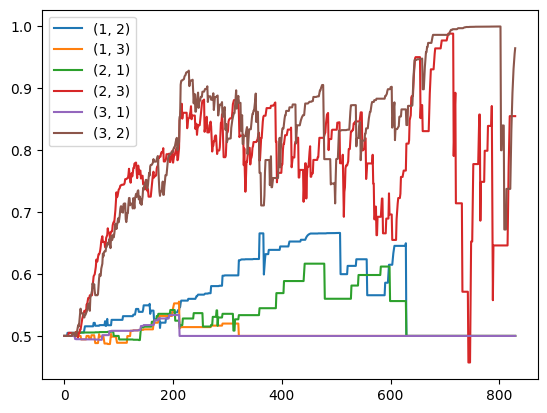

In [676]:
plt.plot(np.nanmean(relation_data,axis =0).T,label =list(relation_list.values() ))
plt.legend()

In [555]:
smp.env.board.edges

array([[0, 1],
       [1, 0],
       [1, 2],
       [1, 8],
       [2, 1],
       [2, 5],
       [2, 3],
       [3, 2],
       [4, 5],
       [5, 6],
       [5, 2],
       [5, 4],
       [6, 7],
       [6, 5],
       [7, 8],
       [7, 6],
       [8, 9],
       [8, 1],
       [8, 7],
       [9, 8]], dtype=int8)

In [ ]:
smp.sample()

In [234]:
smp.hero_agents_list[1].train(1, batch_size = 10)

In [ ]:
data.repeat(repeats=(2,1))

In [ ]:
with torch.no_grad():
    data= smp.hero_agents_list[smp.the_hero_agent].model_in.repeat(repeats=(2,1))
    a1 = smp.hero_agents_list[smp.the_hero_agent].actor1(data)
    print(data.shape,a1.shape)
    
    
    a2 = smp.hero_agents_list[smp.the_hero_agent].actor2(data,a1)
    print(a1,a2)
    v = smp.hero_agents_list[smp.the_hero_agent].qf1(data,a1[:,None],a2)
    print(v)
    
    
                    

# model class

In [ ]:
if __name__ == "__main__":
    import stable_baselines3 as sb3

    if sb3.__version__ < "2.0":
        raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:
poetry run pip install "stable_baselines3==2.0.0a1"
"""
        )
    args = tyro.cli(Args)
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

    # env setup
    envs = gym.vector.SyncVectorEnv([make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
    assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

    actor = Actor(envs).to(device)
    qf1 = QNetwork(envs).to(device)
    qf1_target = QNetwork(envs).to(device)
    target_actor = Actor(envs).to(device)
    target_actor.load_state_dict(actor.state_dict())
    qf1_target.load_state_dict(qf1.state_dict())
    q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)
    actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

    envs.single_observation_space.dtype = np.float32
    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        handle_timeout_termination=False,
    )
    start_time = time.time()

    # TRY NOT TO MODIFY: start the game
    obs, _ = envs.reset(seed=args.seed)
    for global_step in range(args.total_timesteps):
        # ALGO LOGIC: put action logic here
        if global_step < args.learning_starts:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            with torch.no_grad():
                actions = actor(torch.Tensor(obs).to(device))
                actions += torch.normal(0, actor.action_scale * args.exploration_noise)
                actions = actions.cpu().numpy().clip(envs.single_action_space.low, envs.single_action_space.high)

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, terminations, truncations, infos = envs.step(actions)

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        if "final_info" in infos:
            for info in infos["final_info"]:
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                break

        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        real_next_obs = next_obs.copy()
        for idx, trunc in enumerate(truncations):
            if trunc:
                real_next_obs[idx] = infos["final_observation"][idx]
        rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs

        # ALGO LOGIC: training.
        if global_step > args.learning_starts:
            data = rb.sample(args.batch_size)
            with torch.no_grad():
                next_state_actions = target_actor(data.next_observations)
                qf1_next_target = qf1_target(data.next_observations, next_state_actions)
                next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * args.gamma * (qf1_next_target).view(-1)

            qf1_a_values = qf1(data.observations, data.actions).view(-1)
            qf1_loss = F.mse_loss(qf1_a_values, next_q_value)

            # optimize the model
            q_optimizer.zero_grad()
            qf1_loss.backward()
            q_optimizer.step()

            if global_step % args.policy_frequency == 0:
                actor_loss = -qf1(data.observations, actor(data.observations)).mean()
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # update the target network
                for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                    target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
                for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                    target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)

            if global_step % 100 == 0:
                writer.add_scalar("losses/qf1_values", qf1_a_values.mean().item(), global_step)
                writer.add_scalar("losses/qf1_loss", qf1_loss.item(), global_step)
                writer.add_scalar("losses/actor_loss", actor_loss.item(), global_step)
                print("SPS:", int(global_step / (time.time() - start_time)))
                writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

    if args.save_model:
        model_path = f"runs/{run_name}/{args.exp_name}.cleanrl_model"
        torch.save((actor.state_dict(), qf1.state_dict()), model_path)
        print(f"model saved to {model_path}")
        from cleanrl_utils.evals.ddpg_eval import evaluate

        episodic_returns = evaluate(
            model_path,
            make_env,
            args.env_id,
            eval_episodes=10,
            run_name=f"{run_name}-eval",
            Model=(Actor, QNetwork),
            device=device,
            exploration_noise=args.exploration_noise,
        )
        for idx, episodic_return in enumerate(episodic_returns):
            writer.add_scalar("eval/episodic_return", episodic_return, idx)

        if args.upload_model:
            from cleanrl_utils.huggingface import push_to_hub

            repo_name = f"{args.env_id}-{args.exp_name}-seed{args.seed}"
            repo_id = f"{args.hf_entity}/{repo_name}" if args.hf_entity else repo_name
            push_to_hub(args, episodic_returns, repo_id, "DDPG", f"runs/{run_name}", f"videos/{run_name}-eval")

    envs.close()
    writer.close()

In [ ]:




    actor1 = Actor(obs).to(device)
    actor2 = ActorDiscrete(obs+1,action).to(device)


    target_actor1 = Actor(obs).to(device)
    target_actor1.load_state_dict(actor1.state_dict())

    target_actor2 = ActorDiscrete(obs+1,action).to(device)
    target_actor2.load_state_dict(actor2.state_dict())

    qf1 = QNetwork(obs,action+1).to(device)
    qf1_target = QNetwork(obs,action+1).to(device)

    qf1_target.load_state_dict(qf1.state_dict())
    q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)

    actor1_optimizer = optim.Adam(list(actor1.parameters()), lr=args.learning_rate)
    actor2_optimizer = optim.Adam(list(actor2.parameters()), lr=args.learning_rate)

    envs.single_observation_space.dtype = np.float32
    #set observation space type
    #setup replay buffer

    #rb = ReplayBuffer(
    #    args.buffer_size,
    #    envs.single_observation_space,
    #    envs.single_action_space,
    #    device,
    #    handle_timeout_termination=False,
    #)
    start_time = time.time()

    # TRY NOT TO MODIFY: start the game
    #obs, _ = envs.reset(seed=args.seed)

    #for global steps 


        #EXPLORATION and exp collection
        #till learning starts random action

        #else:
        #    with torch.no_grad():
        #        actions = actor(torch.Tensor(obs).to(device))
        #        actions += torch.normal(0, actor.action_scale * args.exploration_noise)
        #        actions = actions.cpu().numpy().clip(envs.single_action_space.low, envs.single_action_space.high) # action cliping
        #
        ## TRY NOT TO MODIFY: execute the game and log data.
        #next_obs, rewards, terminations, truncations, infos = envs.step(actions)


        
        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        #real_next_obs = next_obs.copy()
        #for idx, trunc in enumerate(truncations):
        #    if trunc:
        #        real_next_obs[idx] = infos["final_observation"][idx]
        #rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        #obs = next_obs



        # ALGO LOGIC: training.
        if global_step > args.learning_starts:
            # get data batch
            #data = rb.sample(args.batch_size)

            # get 
            with torch.no_grad():
                next_state_actions1 = target_actor1(data.next_observations)
                next_state_actions2 = target_actor2(data.next_observations,next_state_actions1)
                qf1_next_target = qf1_target(data.next_observations, next_state_actions1, next_state_actions2)
                next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * args.gamma * (qf1_next_target).view(-1)

            qf1_a_values = qf1(data.observations, data.actions1, data.actions2 ).view(-1)
            qf1_loss = F.mse_loss(qf1_a_values, next_q_value)

            # optimize the model
            q_optimizer.zero_grad()
            qf1_loss.backward()
            q_optimizer.step()

            if global_step % args.policy_frequency == 0:
                acts_1 = actor1(data.observations)
                acts_2 = actor2(data.observations,acts_1)
                actor_loss = -qf1(data.observations, acts_1, acts_2).mean()
                actor1_optimizer.zero_grad()
                
                actor_loss.backward(retain_graph=True)
                actor1_optimizer.step()

                actor2_optimizer.zero_grad()
                actor_loss.backward()
                
                actor2_optimizer.step()

                
                # update the target network
                for param, target_param in zip(actor1.parameters(), target_actor1.parameters()):
                    target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)

                for param, target_param in zip(actor2.parameters(), target_actor2.parameters()):
                    target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
                
                for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                    target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)



    def train_write(self, iteration, print_=False):

        total_loss_list = []
        Q_TD_list = []
        Q_MSE_list = []
        Q_loss_list = []
        policy_loss_list = []

        if self.args.TB_log:
            self.writer.add_scalar("charts/learning_rate", self.optimizer_1.param_groups[0]["lr"], iteration)        
        
        for epoch in range(self.args.update_epochs):
            for i,batch in enumerate(self.traj_data_loader):
                total_loss = 0
                Q_TD = 0
                Q_MSE = 0
                Q_loss = 0
                policy_loss = 0
                print(i)


                batch_len = batch[0].shape[1]#2840
                
                if batch_len > self.chunk_size:
                    a_ = [(i,i+self.chunk_size) for i in range(0, batch_len     -self.chunk_size,self.chunk_size-self.chunk_overlap)  ]
                    a_  =a_+[ (a_[-1][1] -self.chunk_overlap ,batch_len) ]
                else:
                    a_ = [(0,batch_len)]
    


                

                divi = len(a_)

                
                print('divi',divi,'chunk_size',self.chunk_size,'batch_shape',batch[0].shape)
                
                for (chunk_id, i) in enumerate(a_):#range(0,batch[0].shape[1] - self.chunk_size + 1,self.chunk_size - self.chunk_overlap)):

                    # print(i,(i + self.chunk_size))
                    total_loss_chunk, Q_TD_chunk, Q_MSE_chunk, Q_loss_chunk, policy_loss_chunk = self.train_write_smaller_chunk((tens[:, i[0]:i[1]] for tens in batch),
                                                                                                                                    iteration, epoch, chunk_id, print_=print_,divi=divi)

                    
                    total_loss= total_loss + total_loss_chunk
                    Q_TD = Q_TD+ Q_TD_chunk
                    Q_MSE = Q_MSE+ Q_MSE_chunk
                    Q_loss = Q_loss+ Q_loss_chunk
                    policy_loss = policy_loss+ policy_loss_chunk

                total_loss_list.append(total_loss)
                Q_TD_list.append(Q_TD)
                Q_MSE_list.append(Q_MSE)
                Q_loss_list.append(Q_loss)
                policy_loss_list.append(policy_loss)            
                
                torch.cuda.empty_cache()

        
        
        if iteration < self.warmup_epoch:
            # Linear warmup: Gradually increase learning rate during warmup
            lr = self.initial_lr * iteration / self.warmup_epoch
            for param_group in self.optimizer_1.param_groups:
                param_group['lr'] = lr
        else:
            self.scheduler.step()

        
        print("total_loss", np.mean(total_loss_list),
              "Q_TD", np.mean(Q_TD_list),
                "Q_MSE", np.mean(Q_MSE_list),
                "Q_loss", np.mean(Q_loss_list),
                "policy_loss", np.mean(policy_loss_list))

        if self.args.TB_log:
        
            self.writer.add_scalar("total_loss", np.mean(total_loss_list), iteration)
            self.writer.add_scalar("Q_TD", np.mean(Q_TD_list), iteration)
            self.writer.add_scalar("Q_MSE", np.mean(Q_MSE_list), iteration)
            self.writer.add_scalar("Q_loss", np.mean(Q_loss_list), iteration)
            self.writer.add_scalar("policy_loss", np.mean(policy_loss_list), iteration)    
                    
                
                
        
        self.copy_wt()


    def train_write_smaller_chunk(
        self,
        data,
        iteration,
        epoch,
        chunk_id,
        print_=False,divi = 1
        ):

        (
            timesteps,
            states,
            actions_1,actions_2,log_probs_actions_2,
            returntogo,
            returns_to_go_cal,
            returntogo_pred,
            reward,
            traj_mask,
            action_masks,
            current_agent_acting,
            current_agent_simple,
            current_agent,
            current_phase,
            current_troops_count,
            ) = data


        if len(timesteps[0].shape) ==0:
            print( timesteps.shape )

        
        timesteps = timesteps[0].to(self.device)  # B x T
        states = states[0].to(self.device)  # B x T x state_dim
        actions_1 = actions_1[0].to(self.device)  # B x T x act_dim
        actions_2 = actions_2[0].to(self.device)  # B x T x act_dim
        log_probs_actions_2 = log_probs_actions_2[0].to(self.device)
        reward = reward[0].to(self.device)
        returns_to_go_cal =             returns_to_go_cal[0].to(self.device).unsqueeze(dim=-1)  # B x T x 1
        returntogo = returntogo[0].to(self.device)
        returntogo_pred = returntogo_pred[0].to(self.device)
        traj_mask = traj_mask[0].to(self.device)  # B x T
        action_masks = action_masks[0].to(self.device)
        current_agent_acting = current_agent_acting[0].to(self.device)
        current_agent_simple = current_agent_simple[0].to(self.device)
        current_agent = current_agent[0].to(self.device)
        current_phase = current_phase[0].to(self.device)
        current_troops_count = current_troops_count[0].to(self.device)

        info = dict({})


        
        hero_steps = current_agent_simple == self.hero

        states = torch.cat((states, action_masks * hero_steps,
                              current_phase, current_agent,
                              current_troops_count[:, :, None]), axis=2)  # ,torch.ones(len(action_masks))[:,None]*self.hero



        #print(actions_1.requires_grad,actions_2.requires_grad)

        (action_pred_1,action_pred_2) =  (actions_1* hero_steps[:,0],
                                                        actions_2* hero_steps[:,0]
                                                         )

        # state_preds, action_preds, return_preds = self.model.forward(
        #                                                timesteps=timesteps,
        #                                                states=states,
        #                                                actions=actions,
        #                                                returns_to_go=returns_to_go
        #                                                #,info = info
        #                                            )

        #so this return to go is for value loss estimation

        _,_, returntogo_pred_v,_ = self.model.forward(
                                                        timesteps=timesteps,
                                                        states=states,
                                                        actions_1=action_pred_1,actions_2=action_pred_2,
                                                        returns_to_go=returntogo,
                                                            print_=print_
                                                        #,info = info
                                                    )
        
        # this is also for value function loss estimation

        (#state_preds_target, 
         _,_,return_preds_target,_) =  self.target_model.forward(timesteps=timesteps,
                                                                                states=states, actions_1=action_pred_1,actions_2=action_pred_2,
                                                                                returns_to_go=returntogo, print_=print_)


        
        
        (#state_preds_target, 
         return_preds_target) = (return_preds_target.detach())


        if  len(reward[:, -1].squeeze().view(-1).shape) == 0:
            
            print('return_preds_last',return_preds_target.shape)
            print('reward_last',reward.shape)
            print('returns_to_go_cal_last',returns_to_go_cal.shape)

            print('return_preds_last',return_preds_target)
            print('reward_last',reward)
            print('returns_to_go_cal_last',returns_to_go_cal)




        
        total_loss, (Q_TD, Q_MSE, Q_loss, policy_loss) = self.calculate_loss(
                                                                                timesteps,
                                                                                return_preds_target,#target model predictions 
                                                                                returns_to_go_cal, # Q calculated
                                                                                hero_steps    ,#current_agent_acting,
                                                                                states,
                                                                                actions_1,actions_2,log_probs_actions_2,
                                                                                returntogo_pred,
                                                                                returntogo_pred_v,
                                                                                reward,#actual rewards 
                                                                                returntogo,  #actual R2G given to the model
                                                                                action_masks,
                                                                                print_,
                                                                                chunk_id,divi
                                                                                )
        #if chunk_id == 0:
        #    print (chunk_id, total_loss)

        # action_loss = #nn.CrossEntropyLoss().forward(action_preds_2,action_target)#F.mse_loss(action_preds_2, action_target.float(), reduction='mean')

        self.optimizer_1.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.25)
        self.optimizer_1.step()
        #self.scheduler.step()
        
        





        
        

        # policy_loss.backward(retain_graph=True)

        return total_loss.detach().item() ,Q_TD.detach().item(), Q_MSE.detach().item(), Q_loss.detach().item(), policy_loss.detach().item()


    def init_path(self):
        self.paths = []

    def init_CL_sample_store(self):


        if self.context_len > 1: # transformer model
            self.DT_input = {  # self.actor_config_dict['ob_space']
                'timestep': torch.zeros((1,
                                        self.context_len),requires_grad =False).to(self.device,
                        dtype=torch.int),
                'state': torch.zeros((1, self.context_len,
                                     self.state_dim),requires_grad =False).to(self.device,dtype=torch.float32),
                'action_1': torch.zeros((1, self.context_len
                                      )).to(self.device,dtype=torch.float32),
                'action_2': torch.zeros((1, self.context_len
                                      )).to(self.device,dtype=torch.float32),
                
                'return_to_go': torch.ones((1,
                        self.context_len),requires_grad =False).to(self.device,dtype=torch.float32) * 110,
                }
        else: # single traje models
            self.DT_input = {  # self.actor_config_dict['ob_space']
                'timestep': torch.zeros((1,
                                        ),requires_grad =False).to(self.device,
                        dtype=torch.int),
                'state': torch.zeros((1,
                                     self.state_dim),requires_grad =False).to(self.device,dtype=torch.float32),
                'action_1': torch.zeros((1,
                                      )).to(self.device,dtype=torch.float32),
                'action_2': torch.zeros((1,
                                      )).to(self.device,dtype=torch.float32),
                
                'return_to_go': torch.ones((1,
                                    ),requires_grad =False).to(self.device,dtype=torch.float32) * 110,
                }            
    
        self.returntogo = torch.zeros((self.num_steps,
                1),requires_grad =False).to(self.device,dtype=torch.float32)  # self.total_agents
        self.returntogo_pred = torch.zeros((self.num_steps,
                1)).to(self.device,dtype=torch.float32)  # self.total_agents

    #here
    def current_model_in(
        self,
        observation,
        curr_agent,
        phase_mapping,
        curr_agent_mapping,
        env_board_agents=[],
        ):



        #single obs
        self.model_in =  torch.hstack((observation['observation'
                         ].reshape(-1).to(self.device),
                         torch.tensor(observation['action_mask'
                         ].reshape(-1)).to(self.device) * (curr_agent
                         == self.hero), phase_mapping.to(self.device),
                         curr_agent_mapping.to(self.device),
                         ( (torch.tensor([env_board_agents[self.hero].bucket]).to(self.device) - 5.2496)/1.4733
                                      )))[None,
                         :].float().requires_grad_(False).to(self.device)  




    

    def update_CL_sample_store(
        self,
        curr_agent_,
        inp={'step': None, 'act_2_1': [],'act_2_2': [], 'curr_reward_list': []},
        before_action=True,
        ):

        if self.context_len > 1:
            
            if before_action == 1 :
    
                if inp['step'] == 0:
    
                    # print(self.model_in.shape)
                    # print(self.model_in.repeat(self.context_len).shape)
    
                    self.DT_input['state'] = self.model_in.repeat(self.context_len,
                            1).to(self.device)[None, :]
                else:
    
                # if step<self.context_len:
    
                #    trace[step] = model_in
    
                    self.DT_input['state'][0, 0:-1] = self.DT_input['state'
                            ][0, 1:].clone()
                    self.DT_input['state'][0, -1] = self.model_in
                    self.DT_input['timestep'][0, 0:-1] = self.DT_input['timestep'][0, 1:].clone()
                    self.DT_input['timestep'][0, -1] = inp['step']
                    self.DT_input['action_1'][0, 0:-1] = self.DT_input['action_1'][0, 1:].clone()
                    self.DT_input['action_2'][0, 0:-1] = self.DT_input['action_2'][0, 1:].clone()
                    
                    self.DT_input['return_to_go'][0, 0:-1] = self.DT_input['return_to_go'][0, 1:].clone()
            elif before_action == 2 :
                if self.hero == curr_agent_:
                    self.DT_input['action_1'][0, -1] = inp['act_2_1']
                else:
                    self.DT_input['action_1'][0, -1] = 0
    
            elif before_action == 3  :
                if self.hero == curr_agent_:
                    self.DT_input['action_2'][0, -1] = inp['act_2_2']
                else:
                    self.DT_input['action_2'][0, -1] = 0
            else:
                    
                self.DT_input['return_to_go'][0, -1] = self.DT_input['return_to_go'][0, -1] -    inp['curr_reward_list']  # [self.hero]
                self.returntogo[inp['step']] = self.DT_input['return_to_go'
                        ][0, -1]

        else:
            if before_action == 1 :
                self.DT_input['state'][0] = self.model_in
                self.DT_input['timestep'][0] = inp['step']
            elif before_action == 2 :
                if self.hero == curr_agent_:
                    self.DT_input['action_1'][0] = inp['act_2_1']
                else:
                    self.DT_input['action_1'][0] = 0                
            
            elif before_action == 3  :
                if self.hero == curr_agent_:
                    self.DT_input['action_2'][0] = inp['act_2_2']
                else:
                    self.DT_input['action_2'][0] = 0
            else:
                    
                self.DT_input['return_to_go'][0] = self.DT_input['return_to_go'][0] -    inp['curr_reward_list']  # [self.hero]
                self.returntogo[inp['step']] = self.DT_input['return_to_go'][0]               


    

    def update_train_data(
        self,
        step_count,
        obs,
        ob_space_shape,
        rewards_2,
        dones_2,
        actions_1,
        actions_2,
        log_probs_actions_2,
        action_masks,
        current_agent,
        current_agent_acting,
        current_phase,
        current_troops_count,
        map_agent_phase_vector,
        ):

        
        
        data_ = collections.defaultdict(torch.tensor)
        data_['observations'] =             obs[:step_count].reshape(-1,
                np.prod(ob_space_shape))

                # data_['next_observations'] = obs[1:step_count+1].to(device =self.args.pin_memory_device).reshape(-1,np.prod(T.ob_space_shape)) #torch.tensor([1,2,3,4])
                # this return to go is the actual input

        data_['returntogo'] =           self.returntogo[:step_count]  # torch.tensor([1,2,3,4])
        data_['returntogo_pred'] =      self.returntogo_pred[:step_count]  # torch.tensor([1,2,3,4])

        data_['rewards'] =              rewards_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['terminals'] =            dones_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['actions_1'] =            actions_1[:step_count]  # torch.tensor([1,2,3,4])
        data_['actions_2'] =            actions_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['log_probs_actions_2'] =  log_probs_actions_2[:step_count]
        data_['action_masks'] =         action_masks[:step_count]
        data_['current_agent_acting'] = current_agent_acting[:step_count]
        data_['current_agent_simple'] = current_agent[:step_count]
        data_['current_agent'] =        map_agent_phase_vector(current_agent[:step_count],
                                               num_classes=self.total_agents + 1)[:, 1:]
        data_['current_phase'] =        map_agent_phase_vector(current_phase[:step_count],
                                               num_classes=self.total_phases)
        data_['current_troops_count'] = current_troops_count[:step_count]



        
        
        self.datase = TrajectoryDataset_per_episode([data_], #len(data[0]['observations'])<self.args.context_len
                context_len=self.args.context_len,rtg_scale=self.args.rtg_scale,dev = self.args.pin_memory_device,
                 gamma=self.args.gamma)

        self.path_que(DataLoader(self.datase, batch_size=len(self.datase)))
    def path_que(self, dtl):
        
        if (len(self.paths)==self.rb_len):
            if (self.rb_len >1):
                self.paths.pop(random.randrange(len(self.paths)-self.args.num_episodes +1 )) # dont pop the most recent experiences and ensure rb_len > num.episodes
            else: 
                self.paths.pop()
        self.paths.append(dtl)
        
    def create_training_dataset(self):
        self.traj_dataset =  TrajectoryDataset_2_through_episodes(self.paths)  # a dataset of dataloaders

        self.traj_data_loader = DataLoader(  # only spit 1 episode a time
            self.traj_dataset,
            batch_size=1,
            shuffle=self.args.shuffle,
            pin_memory=self.args.pin_memory,
            drop_last=self.args.drop_last,
            pin_memory_device=self.args.pin_memory_device,
            )

    
    def action_predict(self, save_R=True, return_R=False,shift=1,action_masks = [],return_log_prob_a2 = False): 
        (#s, 
         a_1,a_2, R,lp) = self.model(timesteps=self.DT_input['timestep'],
                               states=self.DT_input['state'],
                               actions_1=self.DT_input['action_1'],
                               actions_2=self.DT_input['action_2'],
                               returns_to_go=( self.DT_input['return_to_go'][:, :, None] if self.context_len>1 else self.DT_input['return_to_go'][:, None]), 
                                return_log_prob_a2 = return_log_prob_a2)


        took_action = False

        

        if self.context_len>1: # handling transformer model
            # I need to handle for non transformer actions
            if len(action_masks) > 0:
                #handling when all the probability of masked actions are zero.... #have to force the model to pick 1st valid action.
                masked_action = (a_1[0, -1, :]*action_masks)
                #valid_ind = torch.nonzero(action_masks).squeeze()
                if torch.any(masked_action !=0):
                    took_action = True
                    
                    action_1 = (masked_action).argmax()[None]
                else: #im hoping that slowly and steadily the model would learn to predict non zero probabilities for action mask
                    
                    action_1 = torch.tensor(np.random.choice(torch.where(action_masks)[0]))[None]  #(masked_action + 0.0000001*action_masks).argmax()[None]
            else:
                action_1 = a_1[0, -1, :].argmax()[None]
                
            action_2 = a_2[0,-1, 0][None]
            if return_log_prob_a2:
                log_prob = lp[0,-1, 0][None]
            else:
                log_prob = None
            
            if save_R:
                self.returntogo_pred[self.DT_input['timestep'][0, -1]] =                 R[0, -1]  # R
    
            if return_R:
                return (action_1, action_2, R[0, -1],took_action,log_prob)
            else:
                return action_1, action_2,took_action,log_prob


        else: # not we are talking about the single obs models

            # I need to handle for non transformer actions
            if len(action_masks) > 0:
                #handling when all the probability of masked actions are zero.... #have to force the model to pick 1st valid action.
                masked_action = (a_1[0, :]*action_masks)
                #valid_ind = torch.nonzero(action_masks).squeeze()
                if torch.any(masked_action !=0):
                    took_action = True
                    
                    action_1 = (masked_action).argmax()[None]
                else: #im hoping that slowly and steadily the model would learn to predict non zero probabilities for action mask
                    
                    action_1 = torch.tensor(np.random.choice(torch.where(action_masks)[0]))[None]  #(masked_action + 0.0000001*action_masks).argmax()[None]
            else:
                action_1 = a_1[0, :].argmax()[None]
                
            action_2 = a_2[0, 0][None]
            if return_log_prob_a2:
                log_prob = lp[0, 0][None]
            else:
                log_prob = None
            
            if save_R:
                self.returntogo_pred[self.DT_input['timestep'][0]] =                 R[0]  # R
    
            if return_R:
                return (action_1, action_2, R[0],took_action,log_prob)
            else:
                return action_1, action_2,took_action,log_prob




            
        

    def action_predict_direct(self, data, return_R=False,return_log_prob_a2 = False):
        (timesteps, states, actions_1,actions_2, returns_to_go) = data
        (#s, 
         a_1,a_2, R,lp) = self.model(timesteps=timesteps, states=states,
                               actions_1=actions_1,actions_2=actions_2,
                               returns_to_go=returns_to_go,return_log_prob_a2 = return_log_prob_a2)
        if return_R:
            return (a_1,a_2, R,lp)
        else:
            return a_1,a_2,lp

    def save_models(self):
        newpath = r'./models/' + self.run_name + '/' + str(self.hero)
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        torch.save(self.model.state_dict(), newpath
                   + '/a2c_transformer.pt')

    def load_models(self):
        newpath = r'./models/' + self.run_name + '/' + str(self.hero)
        self.model.load_state_dict(torch.load(newpath
                                   + '/a2c_transformer.pt'))
        self.target_model.load_state_dict(torch.load(newpath
                + '/a2c_transformer.pt'))


In [ ]:
torch.ones((1),requires_grad =False)[0] * 110

## model_old

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


#referrence for loss : https://github.com/vy007vikas/PyTorch-ActorCriticRL/blob/master/train.py

#reference invalid actions ignore
#https://ai.stackexchange.com/questions/2980/how-should-i-handle-invalid-actions-when-using-reinforce
#ttps://arxiv.org/abs/2006.14171


class main_model:

    def __init__(  # ,config,args,hero = 1,
        self,
        qnet_config_dict,
        actor_config_dict,
        args,
        device,
        writer,
        run_name,
        agent,
        ):

        self.writer = writer
        self.hero = agent
        self.args = args
        self.run_name = run_name
        self.device = device  # config['device']
        self.state_dim = actor_config_dict['ob_space']  # config['observation_space']#.shape[0]
        self.act_dim = actor_config_dict['action_space']  # config['action_space']#.n #3#1 #env.action_space.shape[0]
        self.n_blocks = args.model_config['n_blocks']
        self.embed_dim = args.model_config['embed_dim']
        self.context_len = args.model_config['context_len']
        self.n_heads = args.model_config['n_heads']
        self.dropout_p = args.model_config['dropout_p']
        self.lr = args.learning_rate
        self.wt_decay = args.model_config['wt_decay']
        self.rb_len = args.model_config['rb_len']

        # self.steps        =            config['steps']

        self.warmup_epoch = args.model_config['warmup_epoch']
        self.total_epoch = args.model_config['total_epoch']
        self.initial_lr =  args.model_config['initial_lr'] #5e-4
        self.final_lr =  args.model_config['final_lr'] #1e-6
        
        self.chunk_size = args.model_config['chunk_size']
        self.chunk_overlap = args.model_config['chunk_overlap']
        #self.max_d4rl_score = -1000.0
        #self.total_updates = 0
        self.tau = args.model_config['tau']
        self.num_steps = args.num_steps
        self.total_agents = args.total_agents
        self.total_phases = args.total_phases
        self.beta = args.model_config['beta']         #0.2 #Q_mse
        self.alpha =args.model_config['alpha']          #0.1  #actionloss
        self.entropy_coeff = args.model_config['entropy_coeff']         #0.1#0.5   #entropy loss in action
        self.val_loss_coeff = args.model_config['val_loss_coeff']        #0.5      #Q loss
        

        # context_len_=200

        self.model = DecisionTransformer(
            state_dim=self.state_dim,
            act_dim=self.act_dim,
            n_blocks=self.n_blocks,
            h_dim=self.embed_dim,
            context_len=self.context_len,
            n_heads=self.n_heads,
            drop_p=self.dropout_p,
            max_timestep=self.num_steps,
            ).to(self.device)

        self.target_model = DecisionTransformer(
            state_dim=self.state_dim,
            act_dim=self.act_dim,
            n_blocks=self.n_blocks,
            h_dim=self.embed_dim,
            context_len=self.context_len,
            n_heads=self.n_heads,
            drop_p=self.dropout_p,
            max_timestep=self.num_steps,
            ).to(self.device)

        # Set target network parameters to not require gradients
        for param in self.target_model.parameters():
            param.requires_grad = False

        self.copy_wt()
        self.optimizer_2 = torch.optim.AdamW(self.model.parameters(),
                lr=0.000005, weight_decay=self.wt_decay)  # lr,

        # lr = 0.00001
        
        self.optimizer_1 = torch.optim.AdamW(self.model.parameters(),
                lr=self.lr, weight_decay=self.wt_decay)  # lr,

        #self.scheduler =             torch.optim.lr_scheduler.LambdaLR(self.optimizer_1, lambda steps: min((steps + 1) / self.warmup_steps, 1))
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer_1,T_max = self.total_epoch - self.warmup_epoch, eta_min=self.final_lr)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_1, T_0=150, T_mult=2, eta_min=0.01, last_epoch=-1)


    
    

    def copy_wt(self):

        # target_param.load_state_dict(param.state_dict())

        for (param, target_param) in zip(self.model.parameters(),
                self.target_model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1
                                    - self.tau) * target_param.data)


    def action_loss_fn_3(
        self,
        timesteps,
        states,
        actions_1,actions_2,log_probs_actions_2,
        returns_to_go,
        return_preds_last,
        returns_to_go_cal_last,
        print_,
        action_masks
        ):

                         # action_preds_2,
                         # action_mask,
                         # return_preds_2,
                         # returns_target,
                         # beta = 0.2

        # model : calculate the action for the states
        # create a new dataset with last action replaced by a_pred_module
        # predict value of the action using model critic
        # torch sum value....

        # pred_a1 = self.actor.forward(s1)
        # loss_actor = -1*torch.sum(self.critic.forward(s1, pred_a1))
        # self.actor_optimizer.zero_grad()
        # loss_actor.backward()
        # self.actor_optimizer.step()

        # so what should i do ..... hmmm ... yeah i only need time steps where agent is the hero agent...

        ################################
        #no epoch no re prediction .... 
        
    
        if True: # this does not look into old values
            ( #_, 
             action_logit_model_1,#action_model_2_dir
                _,_,logp_pi_a_2_dir,dist_entropy_a_1) =   self.model.forward(timesteps=timesteps, states=states,
                                   actions_1=actions_1,actions_2=actions_2,
                                   returns_to_go=returns_to_go, print_=2,return_logit=True,return_og_log_prob_a2=True)  # print_
    
                                                            # ,info = info
    
            actions_1_ = actions_1.clone().detach()#, requires_grad=False)
    
            # self.actions_ = actions_
            # self.action_preds_model_ = action_preds_model
            # actions_[:,:,-1] = action_preds_model
    

            log_probs_1 = -torch.nn.functional.cross_entropy(action_logit_model_1[:, -1, :], 
                                           actions_1_[:, -1].long(), reduction="none")
            
            #(a1_[:,-1,:][hero_steps[:,-1,0]]*action_masks[:,-1,:][hero_steps[:,-1,0]])



            
            #actions_1_[:, -1] =     ((action_logit_model_1[:, -1, :] + 0.000001*action_masks) *action_masks).argmax(axis=1).clone().detach() #i will fix this later, there is an issue.... when probabilities for all legal actions are 0, the product is same as illigal actions 
            actions_1_[:, -1] =     (action_logit_model_1[:, -1, :] *action_masks).argmax(axis=1).clone().detach() #i will fix this later, there is an issue.... when probabilities for all legal actions are 0, the product is same as illigal actions 

            ( #_, 
             _,#action_logit_model_2
                _,_,logp_pi_a_2,_,) =   self.model.forward(timesteps=timesteps, states=states,
                                   actions_1=actions_1_,actions_2=actions_2,
                                   returns_to_go=returns_to_go, print_=2,return_logit=True,return_og_log_prob_a2=True)
            

            
            #if False:
            #with torch.no_grad():
            #    ( #_, 
            #     _,_,values_) =   self.model.forward(timesteps=timesteps, states=states,
            #                       actions_1=actions_1_,actions_2=actions_2,
            #                       returns_to_go=returns_to_go, print_=2,return_logit=False)

            advantages  = returns_to_go_cal_last - return_preds_last.clone().detach()
            
            



            
            #if (not torch.isfinite(action_logit_model_1[:, -1,:]).all()) :
            #    print('inf_error', 'action_logit_model_1')
            #    print('action_logit_model_1',action_logit_model_1[:, -1,:])
            #    print('log_probs_1',log_probs_1)
            #    print('actions_1_',actions_1_[:, -1].long())
            #    a()
            #    
            #if (not torch.isfinite(log_probs_1).all()):
            #    print('inf_error', 'log_probs_1')
            #    print('action_logit_model_1',action_logit_model_1[:, -1,:])
            #    print('log_probs_1',log_probs_1)
            #    print('actions_1_',actions_1_[:, -1].long())
            #    a()
            #    
            #if (not torch.isfinite(actions_1_[:, -1].long() ).all())  :
            #    print('inf_error','actions_1_')
            #    print('action_logit_model_1',action_logit_model_1[:, -1,:])
            #    print('log_probs_1',log_probs_1)
            #    print('actions_1_',actions_1_[:, -1].long())
            #    a()
                
                
                
            
            try:
                #the model is sending everyone .... 1. .... there must be an issue .... lower the weight
                log_probs_2_dir = -torch.nn.BCELoss(reduction ='none')(

                                               #logp_pi_a_2_dir[:, -1,0],
                                               torch.clamp(logp_pi_a_2_dir[:, -1,0], min=0.00001, max=0.9999),
                                               #torch.clamp(action_model_2_dir[:, -1,0], min=0.00001, max=0.9999), 
                                               torch.clamp(log_probs_actions_2[:, -1], min=0.00001, max=0.9999))

                #if (not torch.isfinite(action_model_2_dir[:, -1,0]).all()) or (action_model_2_dir[:, -1,0] ==1).any() or (action_model_2_dir[:, -1,0] ==0).any():
                #    print('inf_error', 'action_model_2_dir')
                #    print('action_model_2_dir',action_model_2_dir[:, -1,0])
                #    print('log_probs_2_dir',log_probs_2_dir)
                #    print('actions_2',actions_2[:, -1])
                #    a()
                #    
                #if (not torch.isfinite(log_probs_2_dir).all()):
                #    print('inf_error', 'log_probs_1')
                #    print('action_model_2_dir',action_model_2_dir[:, -1,0])
                #    print('log_probs_2_dir',log_probs_2_dir)
                #    print('actions_2',actions_2[:, -1])
                #    a()
                #
                #if (not torch.isfinite(actions_2[:, -1]).all()):
                #    print('inf_error', 'actions_2')
                #    print('action_model_2_dir',action_model_2_dir[:, -1,0])
                #    print('log_probs_2_dir',log_probs_2_dir)
                #    print('actions_2',actions_2[:, -1])
                #    a()




            
            except Exception as e:
                print(e)
                print(logp_pi_a_2_dir[:, -1,0])
                print(log_probs_actions_2[:, -1])
                a()

            log_probs_2 = -torch.nn.BCELoss(reduction ='none')(#logp_pi_a_2[:, -1,0],#action_logit_model_2[:, -1,0], 
                                                               torch.clamp(logp_pi_a_2[:, -1,0], min=0.00001, max=0.9999),
                                           torch.clamp(log_probs_actions_2[:, -1], min=0.00001, max=0.9999)
                                            )
            
            #if (not torch.isfinite(log_probs_2).all()):
            #    #pass
            #    print('inf_error', 'log_probs_2')
            #    print('log_probs_2',log_probs_2)
            #    a()

            #if (not torch.isfinite(action_logit_model_2[:, -1,0]).all()) or (action_logit_model_2[:, -1,0] ==1).any() or (action_logit_model_2[:, -1,0] ==0).any():
            #        print('inf_error', 'action_logit_model_2')
            #        print('action_logit_model_2',action_logit_model_2[:, -1,0])
            #        a()

            #print(logp_pi_a_2_dir[:,-1,0],logp_pi_a_2[:,-1,0])

            pi_loss = -((log_probs_1 +log_probs_2 + log_probs_2_dir)*(advantages)).mean() - self.entropy_coeff*dist_entropy_a_1.mean()

            
            
            return pi_loss

    def value_loss_fn_3(
        self,
        reward_last,
        return_preds_last,
        returns_target_last,
        returns_to_go_cal_last,
        beta=0.2,
        alpha=2,
        gamma=0.99,
        device='cpu',
        ):
        
        RT1 = reward_last[:-1] + gamma * returns_target_last[1:]
        try:
            Q_TD = torch.nn.functional.smooth_l1_loss(return_preds_last[:-1],RT1) 
            
            Q_TD=Q_TD+torch.nn.functional.smooth_l1_loss(return_preds_last[[-1]], reward_last[[-1]])
            
            Q_MSE = torch.nn.functional.smooth_l1_loss(return_preds_last, returns_to_go_cal_last)
            return (Q_TD ,  Q_MSE)
        except Exception as e:
            print(e)
            print('in-v-loss')
            print( 'return_preds_last' ,return_preds_last)
            print('RT1' ,RT1)
            print('reward_last' ,reward_last)
            print('returns_to_go_cal_last' ,returns_to_go_cal_last)
            a()

        

    def calculate_loss(
        self,
        timesteps,
        returns_target, #target model predictions 
        returns_to_go_cal,  # Q calculated
        hero_steps,#current_agent_acting,
        states,
        actions_1,actions_2,log_probs_actions_2,
        return_preds,
        return_preds_v        
        ,reward, #actual rewards 
        returns_to_go,  #actual R2G given to the model
        action_masks,
        print_,
        chunk_id,
        divi
        ):


        
        # only consider non padded elements

        reward_last = reward[:, -1].squeeze().view(-1).to(self.device,dtype=torch.float32) #require the last reward only
        return_preds_last = return_preds[:, -1,-1].squeeze().view(-1).to(self.device,dtype=torch.float32)  # act_dim , this is what out model predicted
        return_preds_v_last = return_preds_v[:, -1,-1].squeeze().view(-1).to(self.device,dtype=torch.float32)  # act_dim , this is what out model predicted
       
        returns_target_last = returns_target[:, -1,-1].squeeze().view(-1).to(self.device,dtype=torch.float32) # target model prediction ... should be the 1st prediction
       
        returns_to_go_cal_last = returns_to_go_cal[:, -1,-1].squeeze().view(-1).to(self.device,dtype=torch.float32) # we need the Q value of the last action


        
        
        hero_step_filter = hero_steps[:,-1,0] # current_agent_acting[:, -1, 0] == self.hero #last action is out heros

        if sum(hero_step_filter) == 0:
            policy_loss = torch.tensor(0,device=self.device)
        else:
            policy_loss = self.action_loss_fn_3(timesteps[hero_step_filter],
                                                states[hero_step_filter],
                                                actions_1[hero_step_filter],actions_2[hero_step_filter],log_probs_actions_2[hero_step_filter],
                                                returns_to_go[hero_step_filter],
                                                
                                                return_preds_last[hero_step_filter],
                                                
                                                returns_to_go_cal_last[hero_step_filter], print_,
                                               
                                                action_masks[:,-1,:][hero_step_filter])

        # but we need to figure out a little more



        if  len(reward_last) == 0:
            print('chunk_id',chunk_id)
            print('reward',reward.shape)
            print('reward_last',reward)
            print('return_preds_last',return_preds_last.shape)


            print('return_preds_last',return_preds_last)
            
            





        
        if True:  # self.value_cal_loss:
            (Q_TD , Q_MSE) = self.value_loss_fn_3(  # value_loss_fn(return_preds_2,return_target,action_mask,beta=1)
                                    reward_last,
                                    return_preds_v_last,
                                    returns_target_last,
                                    returns_to_go_cal_last,
                                    beta=0.5,
                                    alpha=2,
                                    gamma=0.99
                                )

            Q_TD = Q_TD/divi
            Q_MSE = Q_MSE/divi
            Q_loss = Q_TD + self.beta*Q_MSE
            
            policy_loss =  policy_loss/divi

            
            total_loss = self.val_loss_coeff*Q_loss + self.alpha*policy_loss

            if (not torch.isfinite(policy_loss)) or (not torch.isfinite(Q_TD)) or (not torch.isfinite(Q_MSE)):
                print(divi, 'policy_loss',policy_loss,'Q_TD',Q_TD,'Q_MSE',Q_MSE)
                a()
            
            


        return total_loss, (Q_TD, Q_MSE, Q_loss, policy_loss)

    def train_write(self, iteration, print_=False):

        total_loss_list = []
        Q_TD_list = []
        Q_MSE_list = []
        Q_loss_list = []
        policy_loss_list = []

        if self.args.TB_log:
            self.writer.add_scalar("charts/learning_rate", self.optimizer_1.param_groups[0]["lr"], iteration)        
        
        for epoch in range(self.args.update_epochs):
            for i,batch in enumerate(self.traj_data_loader):
                total_loss = 0
                Q_TD = 0
                Q_MSE = 0
                Q_loss = 0
                policy_loss = 0
                print(i)


                batch_len = batch[0].shape[1]#2840
                
                if batch_len > self.chunk_size:
                    a_ = [(i,i+self.chunk_size) for i in range(0, batch_len     -self.chunk_size,self.chunk_size-self.chunk_overlap)  ]
                    a_  =a_+[ (a_[-1][1] -self.chunk_overlap ,batch_len) ]
                else:
                    a_ = [(0,batch_len)]
    


                

                divi = len(a_)

                
                print('divi',divi,'chunk_size',self.chunk_size,'batch_shape',batch[0].shape)
                
                for (chunk_id, i) in enumerate(a_):#range(0,batch[0].shape[1] - self.chunk_size + 1,self.chunk_size - self.chunk_overlap)):

                    # print(i,(i + self.chunk_size))
                    total_loss_chunk, Q_TD_chunk, Q_MSE_chunk, Q_loss_chunk, policy_loss_chunk = self.train_write_smaller_chunk((tens[:, i[0]:i[1]] for tens in batch),
                                                                                                                                    iteration, epoch, chunk_id, print_=print_,divi=divi)

                    
                    total_loss= total_loss + total_loss_chunk
                    Q_TD = Q_TD+ Q_TD_chunk
                    Q_MSE = Q_MSE+ Q_MSE_chunk
                    Q_loss = Q_loss+ Q_loss_chunk
                    policy_loss = policy_loss+ policy_loss_chunk

                total_loss_list.append(total_loss)
                Q_TD_list.append(Q_TD)
                Q_MSE_list.append(Q_MSE)
                Q_loss_list.append(Q_loss)
                policy_loss_list.append(policy_loss)            
                
                torch.cuda.empty_cache()

        
        
        if iteration < self.warmup_epoch:
            # Linear warmup: Gradually increase learning rate during warmup
            lr = self.initial_lr * iteration / self.warmup_epoch
            for param_group in self.optimizer_1.param_groups:
                param_group['lr'] = lr
        else:
            self.scheduler.step()

        
        print("total_loss", np.mean(total_loss_list),
              "Q_TD", np.mean(Q_TD_list),
                "Q_MSE", np.mean(Q_MSE_list),
                "Q_loss", np.mean(Q_loss_list),
                "policy_loss", np.mean(policy_loss_list))

        if self.args.TB_log:
        
            self.writer.add_scalar("total_loss", np.mean(total_loss_list), iteration)
            self.writer.add_scalar("Q_TD", np.mean(Q_TD_list), iteration)
            self.writer.add_scalar("Q_MSE", np.mean(Q_MSE_list), iteration)
            self.writer.add_scalar("Q_loss", np.mean(Q_loss_list), iteration)
            self.writer.add_scalar("policy_loss", np.mean(policy_loss_list), iteration)    
                    
                
                
        
        self.copy_wt()


    def train_write_smaller_chunk(
        self,
        data,
        iteration,
        epoch,
        chunk_id,
        print_=False,divi = 1
        ):

        (
            timesteps,
            states,
            actions_1,actions_2,log_probs_actions_2,
            returntogo,
            returns_to_go_cal,
            returntogo_pred,
            reward,
            traj_mask,
            action_masks,
            current_agent_acting,
            current_agent_simple,
            current_agent,
            current_phase,
            current_troops_count,
            ) = data


        if len(timesteps[0].shape) ==0:
            print( timesteps.shape )

        
        timesteps = timesteps[0].to(self.device)  # B x T
        states = states[0].to(self.device)  # B x T x state_dim
        actions_1 = actions_1[0].to(self.device)  # B x T x act_dim
        actions_2 = actions_2[0].to(self.device)  # B x T x act_dim
        log_probs_actions_2 = log_probs_actions_2[0].to(self.device)
        reward = reward[0].to(self.device)
        returns_to_go_cal =             returns_to_go_cal[0].to(self.device).unsqueeze(dim=-1)  # B x T x 1
        returntogo = returntogo[0].to(self.device)
        returntogo_pred = returntogo_pred[0].to(self.device)
        traj_mask = traj_mask[0].to(self.device)  # B x T
        action_masks = action_masks[0].to(self.device)
        current_agent_acting = current_agent_acting[0].to(self.device)
        current_agent_simple = current_agent_simple[0].to(self.device)
        current_agent = current_agent[0].to(self.device)
        current_phase = current_phase[0].to(self.device)
        current_troops_count = current_troops_count[0].to(self.device)

        info = dict({})


        
        hero_steps = current_agent_simple == self.hero

        states = torch.cat((states, action_masks * hero_steps,
                              current_phase, current_agent,
                              current_troops_count[:, :, None]), axis=2)  # ,torch.ones(len(action_masks))[:,None]*self.hero
        (action_pred_1,action_pred_2) =  (actions_1* hero_steps[:,0],
                                                        actions_2* hero_steps[:,0]
                                                         )


    
    def train_write_smaller_chunk_(
        self,
        data,
        iteration,
        epoch,
        chunk_id,
        print_=False,divi = 1
        ):

        (
            timesteps,
            states,
            actions_1,actions_2,log_probs_actions_2,
            returntogo,
            returns_to_go_cal,
            returntogo_pred,
            reward,
            traj_mask,
            action_masks,
            current_agent_acting,
            current_agent_simple,
            current_agent,
            current_phase,
            current_troops_count,
            ) = data


        if len(timesteps[0].shape) ==0:
            print( timesteps.shape )

        
        timesteps = timesteps[0].to(self.device)  # B x T
        states = states[0].to(self.device)  # B x T x state_dim
        actions_1 = actions_1[0].to(self.device)  # B x T x act_dim
        actions_2 = actions_2[0].to(self.device)  # B x T x act_dim
        log_probs_actions_2 = log_probs_actions_2[0].to(self.device)
        reward = reward[0].to(self.device)
        returns_to_go_cal =             returns_to_go_cal[0].to(self.device).unsqueeze(dim=-1)  # B x T x 1
        returntogo = returntogo[0].to(self.device)
        returntogo_pred = returntogo_pred[0].to(self.device)
        traj_mask = traj_mask[0].to(self.device)  # B x T
        action_masks = action_masks[0].to(self.device)
        current_agent_acting = current_agent_acting[0].to(self.device)
        current_agent_simple = current_agent_simple[0].to(self.device)
        current_agent = current_agent[0].to(self.device)
        current_phase = current_phase[0].to(self.device)
        current_troops_count = current_troops_count[0].to(self.device)

        info = dict({})


        
        hero_steps = current_agent_simple == self.hero

        states = torch.cat((states, action_masks * hero_steps,
                              current_phase, current_agent,
                              current_troops_count[:, :, None]), axis=2)  # ,torch.ones(len(action_masks))[:,None]*self.hero



        #print(actions_1.requires_grad,actions_2.requires_grad)

        (action_pred_1,action_pred_2) =  (actions_1* hero_steps[:,0],
                                                        actions_2* hero_steps[:,0]
                                                         )


        #so this return to go is for value loss estimation

        _,_, returntogo_pred_v,_ = self.model.forward(
                                                        timesteps=timesteps,
                                                        states=states,
                                                        actions_1=action_pred_1,actions_2=action_pred_2,
                                                        returns_to_go=returntogo,
                                                            print_=print_
                                                        #,info = info
                                                    )
        
        # this is also for value function loss estimation

        (#state_preds_target, 
         _,_,return_preds_target,_) =  self.target_model.forward(timesteps=timesteps,
                                                                                states=states, actions_1=action_pred_1,actions_2=action_pred_2,
                                                                                returns_to_go=returntogo, print_=print_)


        
        
        (#state_preds_target, 
         return_preds_target) = (return_preds_target.detach())


        if  len(reward[:, -1].squeeze().view(-1).shape) == 0:
            
            print('return_preds_last',return_preds_target.shape)
            print('reward_last',reward.shape)
            print('returns_to_go_cal_last',returns_to_go_cal.shape)

            print('return_preds_last',return_preds_target)
            print('reward_last',reward)
            print('returns_to_go_cal_last',returns_to_go_cal)




        
        total_loss, (Q_TD, Q_MSE, Q_loss, policy_loss) = self.calculate_loss(
                                                                                timesteps,
                                                                                return_preds_target,#target model predictions 
                                                                                returns_to_go_cal, # Q calculated
                                                                                hero_steps    ,#current_agent_acting,
                                                                                states,
                                                                                actions_1,actions_2,log_probs_actions_2,
                                                                                returntogo_pred,
                                                                                returntogo_pred_v,
                                                                                reward,#actual rewards 
                                                                                returntogo,  #actual R2G given to the model
                                                                                action_masks,
                                                                                print_,
                                                                                chunk_id,divi
                                                                                )
        #if chunk_id == 0:
        #    print (chunk_id, total_loss)

        # action_loss = #nn.CrossEntropyLoss().forward(action_preds_2,action_target)#F.mse_loss(action_preds_2, action_target.float(), reduction='mean')

        self.optimizer_1.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.25)
        self.optimizer_1.step()
        #self.scheduler.step()
        
        # policy_loss.backward(retain_graph=True)

        return total_loss.detach().item() ,Q_TD.detach().item(), Q_MSE.detach().item(), Q_loss.detach().item(), policy_loss.detach().item()





    def init_path(self):
        self.paths = []
        

    def init_CL_sample_store(self):


        if self.context_len > 1: # transformer model
            self.DT_input = {  # self.actor_config_dict['ob_space']
                'timestep': torch.zeros((1,
                                        self.context_len),requires_grad =False).to(self.device,
                        dtype=torch.int),
                'state': torch.zeros((1, self.context_len,
                                     self.state_dim),requires_grad =False).to(self.device,dtype=torch.float32),
                'action_1': torch.zeros((1, self.context_len
                                      )).to(self.device,dtype=torch.float32),
                'action_2': torch.zeros((1, self.context_len
                                      )).to(self.device,dtype=torch.float32),
                
                'return_to_go': torch.ones((1,
                        self.context_len),requires_grad =False).to(self.device,dtype=torch.float32) * 110,
                }
        else: # single traje models
            self.DT_input = {  # self.actor_config_dict['ob_space']
                'timestep': torch.zeros((1,
                                        ),requires_grad =False).to(self.device,
                        dtype=torch.int),
                'state': torch.zeros((1,
                                     self.state_dim),requires_grad =False).to(self.device,dtype=torch.float32),
                'action_1': torch.zeros((1,
                                      )).to(self.device,dtype=torch.float32),
                'action_2': torch.zeros((1,
                                      )).to(self.device,dtype=torch.float32),
                
                'return_to_go': torch.ones((1,
                                    ),requires_grad =False).to(self.device,dtype=torch.float32) * 110,
                }            
    
        self.returntogo = torch.zeros((self.num_steps,
                1),requires_grad =False).to(self.device,dtype=torch.float32)  # self.total_agents
        self.returntogo_pred = torch.zeros((self.num_steps,
                1)).to(self.device,dtype=torch.float32)  # self.total_agents

    #here
    def current_model_in(
        self,
        observation,
        curr_agent,
        phase_mapping,
        curr_agent_mapping,
        env_board_agents=[],
        ):



        #single obs
        self.model_in =  torch.hstack((observation['observation'
                         ].reshape(-1).to(self.device),
                         torch.tensor(observation['action_mask'
                         ].reshape(-1)).to(self.device) * (curr_agent
                         == self.hero), phase_mapping.to(self.device),
                         curr_agent_mapping.to(self.device),
                         ( (torch.tensor([env_board_agents[self.hero].bucket]).to(self.device) - 5.2496)/1.4733
                                      )))[None,
                         :].float().requires_grad_(False).to(self.device)  




    

    def update_CL_sample_store(
        self,
        curr_agent_,
        inp={'step': None, 'act_2_1': [],'act_2_2': [], 'curr_reward_list': []},
        before_action=True,
        ):

        if self.context_len > 1:
            
            if before_action == 1 :
    
                if inp['step'] == 0:
    
                    # print(self.model_in.shape)
                    # print(self.model_in.repeat(self.context_len).shape)
    
                    self.DT_input['state'] = self.model_in.repeat(self.context_len,
                            1).to(self.device)[None, :]
                else:
    
                # if step<self.context_len:
    
                #    trace[step] = model_in
    
                    self.DT_input['state'][0, 0:-1] = self.DT_input['state'
                            ][0, 1:].clone()
                    self.DT_input['state'][0, -1] = self.model_in
                    self.DT_input['timestep'][0, 0:-1] = self.DT_input['timestep'][0, 1:].clone()
                    self.DT_input['timestep'][0, -1] = inp['step']
                    self.DT_input['action_1'][0, 0:-1] = self.DT_input['action_1'][0, 1:].clone()
                    self.DT_input['action_2'][0, 0:-1] = self.DT_input['action_2'][0, 1:].clone()
                    
                    self.DT_input['return_to_go'][0, 0:-1] = self.DT_input['return_to_go'][0, 1:].clone()
            elif before_action == 2 :
                if self.hero == curr_agent_:
                    self.DT_input['action_1'][0, -1] = inp['act_2_1']
                else:
                    self.DT_input['action_1'][0, -1] = 0
    
            elif before_action == 3  :
                if self.hero == curr_agent_:
                    self.DT_input['action_2'][0, -1] = inp['act_2_2']
                else:
                    self.DT_input['action_2'][0, -1] = 0
            else:
                    
                self.DT_input['return_to_go'][0, -1] = self.DT_input['return_to_go'][0, -1] -    inp['curr_reward_list']  # [self.hero]
                self.returntogo[inp['step']] = self.DT_input['return_to_go'
                        ][0, -1]

        else:
            if before_action == 1 :
                self.DT_input['state'][0] = self.model_in
                self.DT_input['timestep'][0] = inp['step']
            elif before_action == 2 :
                if self.hero == curr_agent_:
                    self.DT_input['action_1'][0] = inp['act_2_1']
                else:
                    self.DT_input['action_1'][0] = 0                
            
            elif before_action == 3  :
                if self.hero == curr_agent_:
                    self.DT_input['action_2'][0] = inp['act_2_2']
                else:
                    self.DT_input['action_2'][0] = 0
            else:
                    
                self.DT_input['return_to_go'][0] = self.DT_input['return_to_go'][0] -    inp['curr_reward_list']  # [self.hero]
                self.returntogo[inp['step']] = self.DT_input['return_to_go'][0]               


    

    def update_train_data(
        self,
        step_count,
        obs,
        ob_space_shape,
        rewards_2,
        dones_2,
        actions_1,
        actions_2,
        log_probs_actions_2,
        action_masks,
        current_agent,
        current_agent_acting,
        current_phase,
        current_troops_count,
        map_agent_phase_vector,
        ):

        
        
        data_ = collections.defaultdict(torch.tensor)
        data_['observations'] =             obs[:step_count].reshape(-1,
                np.prod(ob_space_shape))

                # data_['next_observations'] = obs[1:step_count+1].to(device =self.args.pin_memory_device).reshape(-1,np.prod(T.ob_space_shape)) #torch.tensor([1,2,3,4])
                # this return to go is the actual input

        data_['returntogo'] =           self.returntogo[:step_count]  # torch.tensor([1,2,3,4])
        data_['returntogo_pred'] =      self.returntogo_pred[:step_count]  # torch.tensor([1,2,3,4])

        data_['rewards'] =              rewards_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['terminals'] =            dones_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['actions_1'] =            actions_1[:step_count]  # torch.tensor([1,2,3,4])
        data_['actions_2'] =            actions_2[:step_count]  # torch.tensor([1,2,3,4])
        data_['log_probs_actions_2'] =  log_probs_actions_2[:step_count]
        data_['action_masks'] =         action_masks[:step_count]
        data_['current_agent_acting'] = current_agent_acting[:step_count]
        data_['current_agent_simple'] = current_agent[:step_count]
        data_['current_agent'] =        map_agent_phase_vector(current_agent[:step_count],
                                               num_classes=self.total_agents + 1)[:, 1:]
        data_['current_phase'] =        map_agent_phase_vector(current_phase[:step_count],
                                               num_classes=self.total_phases)
        data_['current_troops_count'] = current_troops_count[:step_count]



        
        
        self.datase = TrajectoryDataset_per_episode([data_], #len(data[0]['observations'])<self.args.context_len
                context_len=1,#self.args.context_len,
                rtg_scale=1,#self.args.rtg_scale,
                dev = self.device,#self.args.pin_memory_device,
                 gamma=0.99#self.args.gamma
                        )

        self.path_que(DataLoader(self.datase, batch_size=len(self.datase)))
    def path_que(self, dtl):
        
        if (len(self.paths)==self.rb_len):
            if (self.rb_len >1):
                self.paths.pop(random.randrange(len(self.paths)-self.args.num_episodes +1 )) # dont pop the most recent experiences and ensure rb_len > num.episodes
            else: 
                self.paths.pop()
        self.paths.append(dtl)
        
    def create_training_dataset(self):
        self.traj_dataset =  TrajectoryDataset_2_through_episodes(self.paths)  # a dataset of dataloaders

        self.traj_data_loader = DataLoader(  # only spit 1 episode a time
            self.traj_dataset,
            batch_size=1,
            shuffle=self.args.shuffle,
            pin_memory=self.args.pin_memory,
            drop_last=self.args.drop_last,
            pin_memory_device=self.args.pin_memory_device,
            )

    
    def action_predict(self, save_R=True, return_R=False,shift=1,action_masks = [],return_log_prob_a2 = False): 
        (#s, 
         a_1,a_2, R,lp) = self.model(timesteps=self.DT_input['timestep'],
                               states=self.DT_input['state'],
                               actions_1=self.DT_input['action_1'],
                               actions_2=self.DT_input['action_2'],
                               returns_to_go=( self.DT_input['return_to_go'][:, :, None] if self.context_len>1 else self.DT_input['return_to_go'][:, None]), 
                                return_log_prob_a2 = return_log_prob_a2)


        took_action = False

        

        if self.context_len>1: # handling transformer model
            # I need to handle for non transformer actions
            if len(action_masks) > 0:
                #handling when all the probability of masked actions are zero.... #have to force the model to pick 1st valid action.
                masked_action = (a_1[0, -1, :]*action_masks)
                #valid_ind = torch.nonzero(action_masks).squeeze()
                if torch.any(masked_action !=0):
                    took_action = True
                    
                    action_1 = (masked_action).argmax()[None]
                else: #im hoping that slowly and steadily the model would learn to predict non zero probabilities for action mask
                    
                    action_1 = torch.tensor(np.random.choice(torch.where(action_masks)[0]))[None]  #(masked_action + 0.0000001*action_masks).argmax()[None]
            else:
                action_1 = a_1[0, -1, :].argmax()[None]
                
            action_2 = a_2[0,-1, 0][None]
            if return_log_prob_a2:
                log_prob = lp[0,-1, 0][None]
            else:
                log_prob = None
            
            if save_R:
                self.returntogo_pred[self.DT_input['timestep'][0, -1]] =                 R[0, -1]  # R
    
            if return_R:
                return (action_1, action_2, R[0, -1],took_action,log_prob)
            else:
                return action_1, action_2,took_action,log_prob


        else: # not we are talking about the single obs models

            # I need to handle for non transformer actions
            if len(action_masks) > 0:
                #handling when all the probability of masked actions are zero.... #have to force the model to pick 1st valid action.
                masked_action = (a_1[0, :]*action_masks)
                #valid_ind = torch.nonzero(action_masks).squeeze()
                if torch.any(masked_action !=0):
                    took_action = True
                    
                    action_1 = (masked_action).argmax()[None]
                else: #im hoping that slowly and steadily the model would learn to predict non zero probabilities for action mask
                    
                    action_1 = torch.tensor(np.random.choice(torch.where(action_masks)[0]))[None]  #(masked_action + 0.0000001*action_masks).argmax()[None]
            else:
                action_1 = a_1[0, :].argmax()[None]
                
            action_2 = a_2[0, 0][None]
            if return_log_prob_a2:
                log_prob = lp[0, 0][None]
            else:
                log_prob = None
            
            if save_R:
                self.returntogo_pred[self.DT_input['timestep'][0]] =                 R[0]  # R
    
            if return_R:
                return (action_1, action_2, R[0],took_action,log_prob)
            else:
                return action_1, action_2,took_action,log_prob




            
        

    def action_predict_direct(self, data, return_R=False,return_log_prob_a2 = False):
        (timesteps, states, actions_1,actions_2, returns_to_go) = data
        (#s, 
         a_1,a_2, R,lp) = self.model(timesteps=timesteps, states=states,
                               actions_1=actions_1,actions_2=actions_2,
                               returns_to_go=returns_to_go,return_log_prob_a2 = return_log_prob_a2)
        if return_R:
            return (a_1,a_2, R,lp)
        else:
            return a_1,a_2,lp

    def save_models(self):
        newpath = r'./models/' + self.run_name + '/' + str(self.hero)
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        torch.save(self.model.state_dict(), newpath
                   + '/a2c_transformer.pt')

    def load_models(self):
        newpath = r'./models/' + self.run_name + '/' + str(self.hero)
        self.model.load_state_dict(torch.load(newpath
                                   + '/a2c_transformer.pt'))
        self.target_model.load_state_dict(torch.load(newpath
                + '/a2c_transformer.pt'))


In [ ]:
torch.ones(1)[:, None]

# hero agent

In [ ]:
import numpy as np


class Hero_agent(int):
    def init_properties(self,agent_count,phases,cp=[],df=[],direct_action=True):
        #self.draw_count = 0
        self.init_win_count_iter(agent_count)
        self.init_move_count_epi(phases)
        self.cp = cp
        self.df = df
        self.direct_action = direct_action
        self.init_reward_concern(agent_count,cp=cp,df=df)
        
    def init_reward_concern(self,agent_count,cp=[],df=[]):
        if len(cp)==0:
            cp = [int(self)]
        self.concern=torch.tensor([(1 if i in cp 
                             else 
                             (-1 if i in df 
                                  else 0)) for i in range(1,agent_count+1) ])
        #self.concern_2 = self.concern
        #self.concern_2[self-1] =0
        
        self.multi_dependency = (sum(self.concern !=0)>1)
        
        
    def init_model(self,model_name="DDQN_module",
                   kwarg = dict({})):
        self.model = model_selector(model_name=model_name, 
                                    kwarg = kwarg)

        
    def init_win_count_iter(self,agent_count):
        self.count_dict = {i:0 for i in range(1,agent_count+1)}
        self.count_draw_dict = {i:0 for i in range(1,agent_count+1)}
        self.draw_territory_count = 0
    def init_move_count_epi(self,phases):
        self.bad_move_count = 0
        self.bad_move_phase_count = {i:0 for i in phases}
        self.move_count =  {i:0 for i in phases}        
    
    def model_def(self, model):
        self.model =model

    def action_predict(self,save_R=True,return_R = False,action_masks = [],return_log_prob_a2 = False):
        return self.model.action_predict(save_R=save_R,return_R = return_R, action_masks = action_masks,return_log_prob_a2 = return_log_prob_a2)

    def action_predict_direct(self,data,return_R = False,return_log_prob_a2 = False):
        return self.model.action_predict_direct(data,return_R = return_R,return_log_prob_a2 = return_log_prob_a2)
    def save_models(self):
        self.model.save_models()

    def process_reward(self,rewards,step,hero_steps):
        if self.multi_dependency and self.direct_action:
            return (rewards*self.concern.to(rewards.device)).sum(-1)[:step][hero_steps][:,None]
        elif self.multi_dependency and not self.direct_action:
            base_rew = torch.zeros( rewards[:step,self-1][hero_steps].shape,require_grad=False)
            #print(base_rew)

            
            hero_step_list  = np.arange(0,step)[hero_steps]
            for i,j in zip(hero_step_list[:-1],hero_step_list[1:]):
                if j-i>1:
                    #print(j,i,rewards[i:j],(rewards[i:j]*self.concern),(rewards[i:j]*self.concern).sum())
                    base_rew[i]+= (rewards[i:j]*self.concern).sum()
            #print(base_rew,rewards[hero_step_list[-1]:],(rewards[hero_step_list[-1]:]*self.concern))
            base_rew[-1]+= (rewards[hero_step_list[-1]:]*self.concern).sum()
            
            return base_rew[:,None]
            
        else:
            return rewards[:step][hero_steps][:,None]
    
    #def model_forward_call(self,name,kwarg):
    #    return self.model_dict[name](**kwarg)
        

a = Hero_agent(1)
a.init_properties(3,[1,2,3],cp=[1],df=[2])

# replay buffer

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.nn.functional import pad

class TrajectoryDataset_per_episode(Dataset): #this should have only 1 trajectory no matter what
    def __init__(self, trajectories, context_len, rtg_scale,dev,gamma=0.99,min_len = 10**6):
        self.trajectories = trajectories
        self.context_len = context_len
        self.dev = dev
        min_len = min(min_len, len(self.trajectories[0]['observations'])) ##len(data[0]['observations'])<self.args.context_len


        
        #states = []
        #for traj in self.trajectories:
        #    traj_len = traj['observations'].shape[0]
        #    min_len = min(min_len, traj_len)
        #    states.append(traj['observations'])
        #    # calculate returns to go and rescale them 

        self.pad_init()
        
        self.trajectories[0]['returns_to_go_cal'] = discount_cumsum(self.trajectories[0]['rewards'], gamma) / rtg_scale

        self.trajectories[0]['current_troops_count'] = (self.trajectories[0]['current_troops_count'] - 5.2496)/1.4733
        
        #print(min_len)
        
        # used for input normalization
        
        #states = torch.concatenate(states, axis=0).to(dtype = torch.float32)
        #self.state_mean, self.state_std = torch.mean(self.trajectories[0]['observations'], axis=0
        #                                            ), torch.std(self.trajectories[0]['observations'], axis=0) + 1e-6

        # normalize states
        #for traj in self.trajectories:

            #self.trajectories[0]['current_troops_count']
            #traj['observations'] = (traj['observations'].to(dtype=torch.float32) - self.state_mean) / self.state_std




        


    


    def pad_init(self):



        #observations : torch.Size([255, 40]) torch.Size([2442, 40]) 
        # returntogo : torch.Size([255, 1]) torch.Size([2442, 1]) 
        # returntogo_pred : torch.Size([255, 1]) torch.Size([2442, 1]) 
        # rewards : torch.Size([255]) torch.Size([2442]) 
        # terminals : torch.Size([255]) torch.Size([2442]) 
        # actions :
        #torch.Size([255, 2]) torch.Size([2442, 2]) 
        # action_masks : torch.Size([255, 32]) torch.Size([2442, 32]) 
        # current_agent_simple : torch.Size([255, 1]) torch.Size([2442, 1]) 
        # current_agent : torch.Size([255, 2]) torch.Size([2442, 2]) 
        # current_phase : torch.Size([255, 2]) torch.Size([2442, 2]) 
        # current_troops_count : torch.Size([255]) torch.Size([2442])


        


        self.trajectories[0]['observations'] =  torch.cat( (
                                              self.trajectories[0]['observations'][0].repeat([self.context_len -1]+[1 for i in range(len(self.trajectories[0]['observations'].shape)-1) ]),
                                              self.trajectories[0]['observations']
                                              
                                            ),dim=0)          
        

        self.trajectories[0]['returntogo'] =      torch.cat( (
                                              self.trajectories[0]['returntogo'][[0]].repeat([self.context_len -1]+[1 for i in range(len(self.trajectories[0]['returntogo'].shape)-1) ]),
                                              self.trajectories[0]['returntogo']
                                              
                                            ),dim=0)         # torch.tensor([1,2,3,4])
        self.trajectories[0]['returntogo_pred'] =             torch.cat( (
                                              self.trajectories[0]['returntogo_pred'][[0]].repeat([self.context_len -1]+[1 for i in range(len(self.trajectories[0]['returntogo_pred'].shape)-1) ]),
                                              self.trajectories[0]['returntogo_pred']
                                              
                                            ),dim=0)   # torch.tensor([1,2,3,4])

        self.trajectories[0]['rewards'] =    torch.cat( (
                                              torch.zeros([self.context_len -1]).to(device=self.dev),
                                              self.trajectories[0]['rewards']
                                              
                                            ),dim=0)  # torch.tensor([1,2,3,4])
        self.trajectories[0]['terminals'] =    torch.cat( (
                                              self.trajectories[0]['terminals'][[0]].repeat([self.context_len -1]+[1 for i in range(len(self.trajectories[0]['terminals'].shape)-1) ]),
                                              self.trajectories[0]['terminals']
                                              
                                            ),dim=0)  # torch.tensor([1,2,3,4])

        
        self.trajectories[0]['actions_1'] =      torch.cat( (
                                              torch.zeros([self.context_len -1]+list(self.trajectories[0]['actions_1'].shape[1:])).to(device=self.dev),
                                              self.trajectories[0]['actions_1']
                                              
                                            ),dim=0)
        
        self.trajectories[0]['actions_2'] =      torch.cat( (
                                              torch.zeros([self.context_len -1]+list(self.trajectories[0]['actions_2'].shape[1:])).to(device=self.dev),
                                              self.trajectories[0]['actions_2']
                                              
                                            ),dim=0)

        self.trajectories[0]['log_probs_actions_2'] = torch.cat( (
                                              torch.zeros([self.context_len -1]+list(self.trajectories[0]['log_probs_actions_2'].shape[1:])).to(device=self.dev),
                                              self.trajectories[0]['log_probs_actions_2']
                                              
                                            ),dim=0)
        
        
        
        
        # torch.tensor([1,2,3,4])
        self.trajectories[0]['action_masks'] =    torch.cat( (
                                              torch.zeros([self.context_len -1]+list(self.trajectories[0]['action_masks'].shape[1:])).to(device=self.dev,dtype=torch.float32),
                                              self.trajectories[0]['action_masks']
                                              
                                            ),dim=0)



        self.trajectories[0]['current_agent_acting'] =     torch.cat( (
                                                              torch.zeros([self.context_len -1]+list(self.trajectories[0]['current_agent_acting'].shape[1:])).to(device=self.dev,dtype=torch.float32),
                                                              self.trajectories[0]['current_agent_acting']
                                                              
                                                            ),dim=0)
        
        self.trajectories[0]['current_agent_simple'] =     torch.cat( (
                                                              torch.zeros([self.context_len -1]+list(self.trajectories[0]['current_agent_simple'].shape[1:])).to(device=self.dev,dtype=torch.float32),
                                                              self.trajectories[0]['current_agent_simple']
                                                              
                                                            ),dim=0)

        
        self.trajectories[0]['current_agent'] =             torch.cat( (
                                                              torch.zeros([self.context_len -1]+list(self.trajectories[0]['current_agent'].shape[1:])).to(device=self.dev,dtype=torch.float32),
                                                              self.trajectories[0]['current_agent']
                                                              
                                                            ),dim=0)

        
        self.trajectories[0]['current_phase'] =             torch.cat( (
                                                          self.trajectories[0]['current_phase'][0].repeat([self.context_len -1]+[1 for i in range(len(self.trajectories[0]['current_phase'].shape)-1) ]),
                                                          self.trajectories[0]['current_phase']
                                                          
                                                        ),dim=0) 
        self.trajectories[0]['current_troops_count'] =      torch.cat( (
                                              self.trajectories[0]['current_troops_count'][0].repeat([self.context_len -1]),
                                              self.trajectories[0]['current_troops_count']
                                              
                                            ),dim=0)




    
    

    def __len__(self):
        #print(len(self.trajectories),(self.trajectories[0].shape),len(self.trajectories[0])- self.context_len + 1 )
        return sum(max(0, len(traj['observations'])- self.context_len + 1
                      ) for traj in self.trajectories)

    def __getitem__(self, idx):
        total_len = 0
        for traj in self.trajectories:
            
            #print(total_len, idx - total_len, total_len + len(traj), - self.context_len + 1)
            
            if total_len  <= idx < total_len + len(traj['observations']) - self.context_len + 1    :
                si = idx - total_len
                
                #context = traj[si:si + self.context_length]
                states = (traj['observations'][si : si + self.context_len])
                
                actions_1 = traj['actions_1'][si : si + self.context_len]#torch.cat((traj['actions_1'][si : si + self.context_len-1].clone().detach(),   traj['actions_1'][[si + self.context_len-1]]      ),dim =0)
                actions_2 = traj['actions_2'][si : si + self.context_len]#torch.cat((traj['actions_2'][si : si + self.context_len-1].clone().detach(),   traj['actions_2'][[si + self.context_len-1]]      ),dim =0)

                log_probs_actions_2 = traj['log_probs_actions_2'][si : si + self.context_len]
                
                reward =  (traj['rewards'][si : si + self.context_len])
                returntogo = (traj['returntogo'][si : si + self.context_len])
                returns_to_go_cal = (traj['returns_to_go_cal'][si : si + self.context_len])
                returntogo_pred = torch.cat((traj['returntogo_pred'][si : si + self.context_len-1].clone().detach(),  traj['returntogo_pred'][[ si + self.context_len-1]]       ),dim =0)




                
                action_masks = (traj['action_masks'][si : si + self.context_len])

                current_agent_acting = (traj['current_agent_acting'][si : si + self.context_len])
                current_agent = (traj['current_agent'][si : si + self.context_len])
                current_agent_simple = (traj['current_agent_simple'][si : si + self.context_len])
                current_phase = (traj['current_phase'][si : si + self.context_len])
                current_troops_count = (traj['current_troops_count'][si : si + self.context_len])
    
                
                timesteps = torch.arange(start=si, end=si+self.context_len, step=1)
    
                # all ones since no padding
                traj_mask = torch.ones(self.context_len, dtype=torch.long)



                if self.context_len> len(states):
                    padding_len = self.context_len - len(states)
    
                    states                = torch.cat([states,
                                    torch.zeros(([padding_len] + list(states.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)  
                    actions_1               = torch.cat([actions_1,
                                    torch.zeros(([padding_len] + list(actions_1.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)
                    
                    actions_2               = torch.cat([actions_2,
                                    torch.zeros(([padding_len] + list(actions_2.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)

                    log_probs_actions_2 =  torch.cat([log_probs_actions_2,
                                    torch.zeros(([padding_len] + list(log_probs_actions_2.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)
                    
                    reward                = torch.cat([reward,
                                    torch.zeros(([padding_len] + list(reward.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)  


                    returntogo            = torch.cat([returntogo,
                                    torch.zeros(([padding_len] + list(returntogo.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)
                    returns_to_go_cal     = torch.cat([returns_to_go_cal,
                                    torch.zeros(([padding_len] + list(returns_to_go_cal.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)
                    returntogo_pred       = torch.cat([returntogo_pred,
                                    torch.zeros(([padding_len] + list(returntogo_pred.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)



                    
                    action_masks          = torch.cat([action_masks,
                                    torch.zeros(([padding_len] + list(action_masks.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)        

                    current_agent_acting = torch.cat([current_agent_acting,
                                    torch.zeros(([padding_len] + list(current_agent_acting.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)
                    
                    current_agent         = torch.cat([current_agent,
                                    torch.zeros(([padding_len] + list(current_agent.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)
                    
                    current_troops_count = torch.cat([current_troops_count,
                                        torch.zeros(([padding_len] + list(current_troops_count.shape[1:])),
                                        dtype=current_troops_count.dtype
                                                   )], 
                                       dim=0)
                    current_phase         = torch.cat([current_phase,
                                    torch.zeros(([padding_len] + list(current_phase.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)         
                    current_troops_count  = torch.cat([current_troops_count,
                                    torch.zeros(([padding_len] + list(current_troops_count.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)                
                    traj_mask             = torch.cat([traj_mask,
                                    torch.zeros(([padding_len] + list(traj_mask.shape[1:])),
                                    dtype=reward.dtype
                                               )], 
                                   dim=0)     














                
                return  timesteps, states, actions_1,actions_2,log_probs_actions_2, returntogo, returns_to_go_cal, returntogo_pred,reward, traj_mask ,action_masks,current_agent_acting,current_agent_simple,current_agent,current_phase,current_troops_count
                
                #return pad(torch.tensor(context), (0,(self.context_length - len(context))),mode="constant"), [1]

            total_len += len(traj) - self.context_len + 1

        raise IndexError("Index out of range 1")


class TrajectoryDataset_2_through_episodes(Dataset):
    def __init__(self, trajectories):
        self.trajectories = trajectories

        #all_obs = torch.concat([ traj.dataset.trajectories[0]['observations'] for traj in self.trajectories],axis=0)
        #self.state_mean = torch.mean(all_obs,axis =0)
        #self.state_std = torch.std(all_obs,axis =0) + 1e-6
        
        #for traj in self.trajectories:
        #    traj.dataset.trajectories[0]['observations'] = (traj.dataset.trajectories[0]['observations'].to(dtype=torch.float32) - self.state_mean) / self.state_std


        #print(self.state_mean,self.state_std)
        
    #def get_state_stats(self):
        #return self.state_mean, self.state_std        

    

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        total_len = 0
        if total_len  <= idx < total_len + len(self.trajectories)  :
            return [batch for batch in self.trajectories[idx] ][0]


        raise IndexError("Index out of range 2")

# trainer module

In [400]:








class Trainer:
    """
    ## Trainer
    """

    def __init__(self, Args,param_dict =dict({})
                 ):
        # #### Configurations

        self.args = Args()#tyro.cli(Args)
        self.param_dict = param_dict
        self.update_arg(param_dict=param_dict)
        self.device = self.args.device#torch.device("cuda" if torch.cuda.is_available() and self.args.cuda else "cpu")
        
        
        #self.args.batch_size = int(self.args.num_envs * self.args.num_steps)
        self.args.minibatch_size = int(self.args.batch_size // self.args.num_minibatches)
        #self.args.num_iterations = self.args.total_timesteps // self.args.batch_size
        self.gam = self.args.gamma
        #self.args.minibatch_size = 256#128 
        self.num_steps = self.args.num_steps#120000#1000000
        self.num_iterations = self.args.num_iterations
        self.episode_time_lim = self.args.episode_time_lim
        self.hero_agent_count = self.args.hero_agent_count
        self.env_config = self.args.env_config
        self.num_episodes = self.args.num_episodes
        self.context_len=self.args.model_config['context_len'] #200

        self.training_performance_return = []
        
        #self.env_config = dict(render_mode = 'rgb_array', default_attack_all  = True,
        #                    agent_count  = 4
        #                       ,use_placement_perc=True,render_=False)        
        
        self.run_name = f"{self.args.env_id}__{self.args.exp_name}__{self.args.seed}__{int(time.time())}"

        

        TB_log = self.args.TB_log 
        if TB_log:    
            self.writer = SummaryWriter(f"runs/{self.run_name}")
            self.writer.add_text(
                "hyperparameters",
                "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(self.args).items()])),
            )
        else:
            self.writer = None
        
        # TRY NOT TO MODIFY: seeding
        random.seed(self.args.seed)
        np.random.seed(self.args.seed)
        #torch.manual_seed(self.args.seed)
        
        torch.backends.cudnn.deterministic = self.args.torch_deterministic
        
        
        
        self.playe_r = 1#"agent_1" #
        

        
        self.action_shape = (2,)



        self.env = env_risk(**self.env_config)
        
        self.env.reset(seed=42)


            

        
        self.args.total_agents = self.total_agents  = len(self.env.possible_agents)
        self.args.total_phases = self.total_phases = len(self.env.phases)

        
        

        
        print(torch.tensor(self.env.last()[0]['observation']
                          ))

        print(torch.tensor(self.env.last()[0]['observation']
                          ).to(device=self.device))
        sample_obs = self.obs_converter(torch.tensor(self.env.last()[0]['observation']
                                                    ).to(device=self.device),
                                        num_classes = self.total_agents+1
                                       )
        
        self.ob_space_shape = sample_obs.shape #env.observation_space(playe_r)['observation'].shape
        self.action_mask_shape = self.env.observation_space(self.playe_r)['action_mask'].shape
        
        #self.device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

        
        
        self.agent_list = list(self.env.possible_agents)
        
        
        
        
       
        self.the_hero_agent = 1

        
        self.qnet_config_dict = dict(action_space = self.env.action_space(self.playe_r
                                                                         ).shape[0],
                                    ob_space=(np.prod(self.ob_space_shape
                                                    )+np.prod(self.action_mask_shape)
                                         +1*( self.total_agents -1) #the current_agent +1#who actor agent was
                                         +1*(self.total_phases -1)#the current phase
                                         +1 )# the number of troops
                               )
        self.actor_config_dict =  dict(env=self.env,
                        action_space = self.env.observation_space(self.playe_r)['action_mask'].shape[0],
                        ob_space=(np.prod(self.ob_space_shape)
                                         +np.prod(self.action_mask_shape)
                                         +1*( self.total_agents-1) #the current_agent +1#who actor agent was
                                         +1*(self.total_phases -1)#the current phase
                                         +1) # the number of troops
                               )



        
        #torch.Tensor(torch.hstack((observation['observation'].reshape(-1),
        #                            torch.tensor(observation['action_mask'].reshape(-1)).to(self.device),
        #                                   phase_mapping,
        #                                    curr_agent_mapping,
        #                                   torch.tensor([env.board.agents[curr_agent].bucket ]).to(self.device)))[None,:]#.repeat(3,axis = 0)
        #                                        ).float()
                        
        
        self.hero_agents_list = {i:Hero_agent(i) for i in range(1,self.hero_agent_count+1) } # this is a list , need to pass it as an argument
        
        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_properties(self.total_agents,self.env.phases)        


            print(len(self.args.model_name[i]))
            
            self.hero_agents_list[i].init_model(model_name=self.args.model_name[i], kwarg = dict(

                                                qnet_config_dict = self.qnet_config_dict, 
                                                actor_config_dict = self.actor_config_dict,
                                                args = self.args,
                                                device = self.device,
                                                writer=self.writer,
                                                run_name=self.run_name,
                                                agent=i)
                                                )
            

            #self.target_actor.load_state_dict(self.actor.state_dict())
            #self.qf1_target.load_state_dict(self.qf1.state_dict())
            #self.q_optimizer = optim.Adam(list(self.qf1.parameters()), lr=self.args.learning_rate)
            #self.actor_optimizer = optim.Adam(list(self.actor.parameters()), lr=self.args.learning_rate)

    def update_arg(self,param_dict=dict({})):
       for i,j in param_dict.items():
           setattr(self.args,i,j)

        

    def obs_converter(self,  data, num_classes = 4, col =0 ):

        if col != None:

            #print(data.device)
            #print(nn.functional.one_hot(data[:4,col].detach().long(), 
            #                                            num_classes = num_classes).to(self.device))
            return torch.concat((nn.functional.one_hot(data[:,col].detach().long(), 
                                                        num_classes = num_classes).to(self.device),
                                      data[:,~col,None]
                                ),axis=1
                               )[:,1:].to(self.device)
    
    def map_agent_phase_hot(self, data,num_classes = 3):
        with torch.no_grad():
            return nn.functional.one_hot(torch.tensor(data),num_classes = num_classes)[1:].to(self.device)
    
    def map_agent_phase_vector(self, data,num_classes = 3):
        with torch.no_grad():
            return nn.functional.one_hot(data[:,0].long(), 
                                                            num_classes = num_classes)[:,1:].to(self.device)



    


    def train_loop_init(self):
        self.gamma_t = {i:0 for i in self.env.possible_agents}
        
        
        self.draw_count = 0

        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_win_count_iter(self.total_agents )
            self.hero_agents_list[i].model.init_path()
        
         
        #self.first_count = 0
        #self.second_count = 0
        #self.third_count = 0
        #self.third_count_draw = 0
        
        self.start_time = time.time()
        self.global_step = 0
        #self.faulting_player = ""

    
    
    def run_training_loop(self):
        """
        ### Run training loop
        """

        # last 100 episode information
        #tracker.set_queue('reward', 100, True)
        #tracker.set_queue('length', 100, True)


        for i in self.hero_agents_list: # each agent has his own buffer, this is kinda pain because now this information is stored and not discarded
    
            self.hero_agents_list[i].rb = ReplayBuffer(
                    self.args.buffer_size,
                    Box(low =0, high=2000, shape =(self.qnet_config_dict['ob_space']+1,), dtype=np.float32),
                    Box(low =0, high=2000, shape =(2,), dtype=np.float32),
                    self.device,
                    handle_timeout_termination=False,
                )

        env = env_risk(**(self.env_config #| {"render_mode" : None, "bad_mov_penalization" : 0.01,"render_":False}
                         ))
        env.reset(42)
        
        self.train_loop_init()
        #self.paths=[]
        
        self.training_performance_return = []
        
        for iteration in range(1, self.num_iterations+1):


            #1st you sample data
            self.sample(
                                env,iteration,
                                
                                
                 
                            )

            
            #2nd you create a new dataset
            for i in self.hero_agents_list:
                    self.hero_agents_list[i].model.create_training_dataset()

            
            #3rd you train the model
            self.train(iteration)
            #break

            
            
            #if self.global_step%100 ==0:
            #    SPS = int(self.global_step / (time.time() - self.start_time))
            #    print("SPS:", SPS)       
            #    self.writer.add_scalar("charts/SPS", SPS, self.global_step)
        
            
            self.save_models()

    def train(self,iteration):

        if True:#self.global_step > self.args.learning_starts:

            for i in self.hero_agents_list:
                self.hero_agents_list[i].model.train_write(
                        iteration,print_=True)
                
                        
                    
    
    def train_(self,iteration):
        
        for epoch in range(self.args.update_epochs):
            
            if self.global_step > self.args.learning_starts:

                for i in self.hero_agents_list:
                    self.hero_agents_list[i].model.train_write(self.hero_agents_list[i].rb.sample(self.args.batch_size)
                                                         ,iteration,epoch)
                    
    def save_models(self):
        for i in self.hero_agents_list:
            self.hero_agents_list[i].save_models()  

    def reset_moves_hero_agents(self):
        for i in self.hero_agents_list:
            self.hero_agents_list[i].init_move_count_epi(self.env.phases)


    def set_episode_recorders(self):
        obs = torch.zeros((self.num_steps,) + self.ob_space_shape, requires_grad =False).to(self.device,    dtype = torch.float32)
        
        actions_1 = torch.zeros((self.num_steps,) ).to(self.device,    dtype = torch.float32)
        
        actions_2 = torch.zeros( (self.num_steps,)).to(self.device,    dtype = torch.float32)
        log_probs_actions_2 = torch.zeros( (self.num_steps,)).to(self.device,    dtype = torch.float32)
        
        action_masks = torch.zeros((self.num_steps, ) + self.action_mask_shape, requires_grad =False).to(self.device,    dtype = torch.float32)
        current_agent = torch.zeros((self.num_steps,1), requires_grad =False).to(self.device,    dtype = torch.float32)*0#-1
        current_agent_acting = torch.ones((self.num_steps,1), requires_grad =False).to(self.device,    dtype = torch.float32)*0
        current_phase = torch.zeros((self.num_steps,1), requires_grad =False).to(self.device,    dtype = torch.float32)
        current_troops_count = torch.zeros((self.num_steps,self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
        #logprobs = torch.zeros((self.num_steps, ), requires_grad =False).to(self.device,    dtype = torch.float32)
        rewards = torch.zeros((self.num_steps, self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
        rewards_2 = torch.zeros((self.num_steps, self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
        
        returntogo = torch.zeros((self.num_steps, self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
        dones = torch.zeros((self.num_steps, self.total_agents), requires_grad =False).to(self.device)
        dones_2 = torch.zeros((self.num_steps, self.total_agents), requires_grad =False).to(self.device)
        #values = torch.zeros((self.num_steps,  )).to(self.device)
        episodes = torch.ones((self.num_steps, ), requires_grad =False).to(self.device,    dtype = torch.float32)*-1
        t_next = torch.zeros((self.num_steps, self.total_agents), requires_grad =False).to(self.device,    dtype = torch.float32)
            
        total_rewards = {i:0 for i in env.possible_agents} #i can report this

        return (
                obs
                ,actions_1
                ,actions_2
                ,log_probs_actions_2
                ,action_masks
                ,current_agent
                ,current_agent_acting
                ,current_phase
                ,current_troops_count
                ,rewards
                ,rewards_2
                ,returntogo
                ,dones
                ,dones_2
                ,episodes
                ,t_next
                ,total_rewards
                )

    
        
    
    def sample(self,env,iteration
                                ):
        

        #for i in self.hero_agents_list:
        #    self.hero_agents_list[i].model.init_path()
        
        with torch.no_grad():
        #if True:
            # sample `worker_steps` from each worker
            #there are no worker steps... rather there are full episodes

            step = 0
            fault_condition = False
            clear_output(wait=True)
            phase = 0
            
        



            

            
            for episode in range(self.num_episodes):#num_episodes):
                #num_steps is the maximum number of steps before the game is stopped


                (
                obs
                ,actions_1
                ,actions_2
                ,log_probs_actions_2
                ,action_masks
                ,current_agent
                ,current_agent_acting
                ,current_phase
                ,current_troops_count
                ,rewards
                ,rewards_2
                ,returntogo
                ,dones
                ,dones_2
                ,episodes
                ,t_next
                ,total_rewards
                ) = self.set_episode_recorders()
                
                #trace = tensor.zeros((self.context_len,self.qnet_config_dict['ob_space']))
                action=1
                #return2g = 110
                
                
                #init model sample store : but do i need it now?
                for i in self.hero_agents_list:
                    self.hero_agents_list[i].model.init_CL_sample_store()


                
                
                if fault_condition:
                    env = env_risk(**(self.env_config  #| {"render_mode" : None,"bad_mov_penalization" : 0.01,"render_":False#False
                                                        # }
                                     )
                                      )#game.env(render_mode=None)

                curren_epi = episode + (iteration-1)*self.num_episodes
                env.reset(curren_epi) #for riplication
                fault_condition = False
                step_count = 0
                
                self.reset_moves_hero_agents()
                is_draw = 0
                
                #draw_territory_count = 0
                #is_third = 0

                for agent in env.agent_iter(): # episode loop
                    e_t = env.terminations
                    if sum(e_t.values()) <(self.total_agents-1):
                        observation, reward, termination, truncation, info = env.last()
        
                        observation['observation'] =  self.obs_converter(
                                                        torch.tensor(
                                                            observation['observation']
                                                        ).to(self.device,dtype=torch.float32),
                                                        num_classes = self.total_agents+1)
                        
                        observation['observation'][:,-1]  =  (observation['observation'][:,-1] - 5.2496)/1.4733



                        
                        
                        episodes[step_count] = curren_epi
                        obs[step_count] = observation['observation'] #torch.Tensor(observation['observation']).to(self.device) #sould i not add it .... meaning this is the last observation after the player dies
                        action_masks[step_count] = torch.Tensor(observation['action_mask']).to(self.device)
                        
                        #curr_agent = agent#int(agent[-1])
                        current_agent[step_count] = curr_agent = agent
                        current_phase[step_count] = phase = env.phase_selection
                        phase_mapping = self.map_agent_phase_hot(phase,num_classes = self.total_phases).float()
                        
                        curr_agent_mapping = self.map_agent_phase_hot(int(curr_agent)-1,
                                                                      num_classes = self.total_agents 
                                                                     ).float()
                        
                        current_troops_count[step_count] = torch.tensor([env.board.agents[i].bucket for i in env.possible_agents],requires_grad =False).to(self.device)
                    

                        

                        for i in self.hero_agents_list:
                            self.hero_agents_list[i].model.current_model_in(observation,curr_agent,
                                                                            phase_mapping,curr_agent_mapping,
                                                                            env_board_agents=env.board.agents)
                            self.hero_agents_list[i].model.update_CL_sample_store(curr_agent_=i,
                                                                                  inp = {'step':step_count,
                                                                                         'act_2_1':[] ,
                                                                                         'act_2_2':[] ,
                                                                                         'curr_reward_list':[]
                                          },before_action=1)
                            
                        
                        action_taken = False
                        log_prob_a2 = None  
                        if True:
                            
                            mask = observation["action_mask"]
                            if (self.global_step < self.args.learning_starts) or (
                                np.random.rand() > min(
                                                ((curren_epi)/((self.num_iterations*self.num_episodes)/10))
                                                , 0.95)
                                                #) or (agent != self.the_hero_agent) 
                                                ) or ( agent not in self.hero_agents_list):
        
                                
                                action = env.action_space(agent).sample()
                                
                                #part_0 =np.random.choice(np.where(env.board.calculated_action_mask(agent))[0])
                                part_0 =np.random.choice(np.where(observation['action_mask'])[0])
                                action = torch.tensor([
                                                        [
                                                         [part_0],
                                                         [np.around(action[1],2)]
                                                        ]
                                                        ],requires_grad =False).to(self.device)
                                
                                action = action[:,:,0]
                                action_1 = action[:,0]
                                action_2 = action[:,1]
                                log_prob_a2 = torch.tensor([  1/(sum(mask)+0.0001) ],requires_grad =False).to(self.device)
                                for i in self.hero_agents_list:
                                    
                                    self.hero_agents_list[i].model.update_CL_sample_store(curr_agent_=curr_agent,
                                                                                          inp = {'step':step_count,
                                                                                                 'act_2_1':action_1 ,
                                                                                                 'act_2_2':[] ,
                                                                                                 'curr_reward_list':[]
                                                  },before_action=2)
                                    
                                    self.hero_agents_list[i].model.update_CL_sample_store(curr_agent_=curr_agent,
                                                                                          inp = {'step':step_count,
                                                                                                 'act_2_1':[] ,
                                                                                                 'act_2_2':action_2 ,
                                                                                                 'curr_reward_list':[]
                                                  },before_action=3)

                                


                            

                                                              
                            else:
                                action_taken = True
                                #action_masks[step]

                                #need to update this
                                action_1,_,action_taken,_ = self.hero_agents_list[curr_agent].action_predict(save_R=False,action_masks=action_masks[step_count])
                                #action_1 = action_1[None,:]
                                #so the action_1 should be updated here... and prediction of action_2 would be re-done


                                
                                
                                if action_taken:
                                    current_agent_acting[step_count] = curr_agent

                                for i in self.hero_agents_list:
                                    
                                    self.hero_agents_list[i].model.update_CL_sample_store(curr_agent_=curr_agent,
                                                                                          inp = {'step':step_count,
                                                                                                 'act_2_1':action_1 ,
                                                                                                 #'act_2_1':action_1[0] ,
                                                                                                 'act_2_2':[] ,
                                                                                                 'curr_reward_list':[]
                                                  },before_action=2)

                                _,action_2,_,log_prob_a2 = self.hero_agents_list[curr_agent].action_predict(save_R=False,action_masks=action_masks[step_count],return_log_prob_a2 = True)
                               # action_2 = action_2[None,:]


                                for i in self.hero_agents_list:
                                    
                                    self.hero_agents_list[i].model.update_CL_sample_store(curr_agent_=curr_agent,
                                                                                          inp = {'step':step_count,
                                                                                                 'act_2_1':[] ,
                                                                                                 #'act_2_2':action_2[0] ,
                                                                                                 'act_2_2':action_2 ,
                                                                                                 'curr_reward_list':[]
                                                  },before_action=3)
                                    



                            
                                #print(action,action.requires_grad)
                                #if len(action.shape)<2:
                                    #print(episode,"---2--",action, action.shape)
                                    #a()
                                    #break
                                
                            
                                #action = self.actor(torch.Tensor(model_in).to(self.device))

                            #this is only to predict and save the return to go for all the transformer agents, will optimize later
                            _ =  [ self.hero_agents_list[i].action_predict(save_R=True, action_masks=action_masks[step_count] # it only matters for the correct agent ... we are only saving the Q

                                                                           
                                                                          
                                                                          ) for i in self.hero_agents_list]

                            
                            actions_1[step_count] = action_1
                            actions_2[step_count] = action_2
                            if log_prob_a2 != None:
                                log_probs_actions_2[step_count] = log_prob_a2
                            curr_agent_ = int(curr_agent)
                            
                            
        
                            if not observation['action_mask'][action_1.long()]: 
                                fault_condition =True
                                
                                #self.faulting_player = agent

                                


                                if  curr_agent_ in self.hero_agents_list:
                                    self.hero_agents_list[curr_agent_].bad_move_count+=1
                                    self.hero_agents_list[curr_agent_].bad_move_phase_count[int(current_phase[step_count][0])]+=1  # when is the where_is_it_performing_bad_really
                                    #print('here',agent, action, observation['action_mask'])
                            
        
                            if  curr_agent_ in self.hero_agents_list:
                                self.hero_agents_list[curr_agent_].move_count[int(current_phase[step_count][0])]+=1  
                            #if self.the_hero_agent == curr_agent:
                                #move_count[int(current_phase[step][0])]+=1        
        
                        





                            
                        #print('here',agent, action)
                        if action_1 != None :
                            act_2_1 = action_1[0]
                            act_2_2 = action_2[0]
                            
                            #act_2 = action.detach().cpu().numpy()[0]#list([action.detach().cpu().numpy()[0][0], max(action.detach().cpu().numpy()[0][1],0.1) ])
                            #act_2 = torch.tensor([act_2[0], max(act_2[1],0.001) ]).to(device = self.device)
                            #print(max(act_2_2.clone().detach().cpu().item(),0.001))
                            env.step([act_2_1.clone().detach().cpu().item(), max(act_2_2.clone().detach().cpu().item(),0.001) ])  
                            try:
                                _ =1
                                #env.step([act_2_1.clone().detach().cpu().item(), max(act_2_2.clone().detach().cpu().item(),0.001) ])    
                            except Exception as e:
                                print("action_taken",action_taken)
                                print(e)
                                
                                print([act_2_1.clone().detach().cpu(), max(act_2_2.clone().detach().cpu(),0.001) ])
                                
                            
                        #env.step(act_2 if action != None else None)        
        
        
                        if True:
        
                            
                            curr_reward_list =  env.curr_rewards
                            
                            if (step_count == (self.episode_time_lim-1))   or (self.global_step == (self.num_steps-1)): # draw reward
                                is_draw=1
                                curr_reward_list = {i:-100 for i in env.possible_agents }

                            

                            #if self.hero == curr_agent_:
                            #    DT_input['action'][-1]  =act_2
                            #DT_input['return_to_go'][-1] -=  curr_reward_list[self.hero]
                            #returntogo[step] = DT_input['return_to_go'][-1]

                            for i in self.hero_agents_list:
                                self.hero_agents_list[i].model.update_CL_sample_store(curr_agent_=curr_agent,
                                              inp = {'step':step_count,
                                                     'act_2_1':None ,
                                                     'act_2_2':None ,
                                                     'curr_reward_list':curr_reward_list[i]
                                              },before_action=4)





                            
                            rewards_2[step_count] = torch.tensor([curr_reward_list[i] for i in env.possible_agents]).to(self.device,dtype=torch.float32)
                            if step >1:
                                dones_2[step_count] = torch.tensor([ int(env.terminations[i]) - dones_2[step_count-1,i-1]  for i in env.possible_agents]).to(self.device)
                            else:
                                dones_2[step_count] = torch.tensor([env.terminations[i] for i in env.possible_agents]).to(self.device)


                        #list_curr_reward_list = np.array(list(curr_reward_list.values()))
                        
                        #if sum(curr_reward_list.values()) == -300:
                            #print('here')
                            #is_draw=1
        
                        
                        for age_i in env.possible_agents:
                            
                            total_rewards[age_i]+=curr_reward_list[age_i] #env.curr_rewards[age_i] if (step_count != episode_time_lim) else -100
                                    
                        
                        step +=1
                        self.global_step+=1
        
                    else:
                        self.training_performance_return.append(total_rewards[1])
                        print('done:',env.terminations,#env.terminations.values(),
                              ",total_reward:",total_rewards, ',iteration:',iteration,",episode:", episode )
                        print(env.board.territories)
                        break    
                
        
        
        
                    step_count+=1
                    
                    if (self.global_step == self.num_steps) :# or (fault_condition and (fa ulting_player != agent) and (len(env.agents)==0)):
                        
                        print('global_break_1')
                        self.training_performance_return.append(total_rewards[1])
                        print('done:',env.terminations,#env.terminations.values(),
                              ",total_reward:",total_rewards, ',iteration:',iteration,",episode:", episode )
                        print(env.board.territories)

                        #have to get out of the outer loop
                        break
                    elif (step_count == self.episode_time_lim):
                        print('episode_break_1')
                        self.training_performance_return.append(total_rewards[1])
                        print('done:',env.terminations,#env.terminations.values(),
                              ",total_reward:",total_rewards, ',iteration:',iteration,",episode:", episode )
                        print(env.board.territories)
                        break

                #self.obs=obs
                
                #print_here
                print(episode,step_count,iteration)



                
                #print(rewards[step-2])
                if self.global_step == self.num_steps:
                    print('global_break_2')
                    break 

                for i in self.hero_agents_list:
                    self.hero_agents_list[i].position =self.total_agents
                    
                    
                #[ position = 3 for i in ] 
                for k_,(i_,j_) in enumerate(sorted([(j_,i_) for i_,j_ in total_rewards.items()],reverse=True) 
                      ):
                    if int(j_) in self.hero_agents_list:
                        self.hero_agents_list[int(j_)].position = k_+1
                        print(j_,self.hero_agents_list[int(j_)].position)
                        
                        
                    #if j_==self.the_hero_agent:
                    #    position = k_+1

                cur_epi_list = (episodes == curren_epi)
                        
                if self.args.TB_log:
                    self.write_exploring(is_draw,#position,
                            curren_epi,step,
                            step_count,
                            total_rewards,#bad_move_count
                            #,bad_move_phase_count,
                            #move_count,
                            observation,
                            env,
                            cur_epi_list,
                            current_agent_acting)

                #paths = []

                for i in self.hero_agents_list:
                    self.hero_agents_list[i].model.update_train_data(
                         step_count,
                         obs,
                            self.ob_space_shape,
                            rewards_2[:,i-1],
                            dones_2[:,i-1],
                            actions_1[cur_epi_list],actions_2,log_probs_actions_2,
                            action_masks,
                            current_agent,
                            current_agent_acting,
                            current_phase,
                            current_troops_count[:,i-1],
                            map_agent_phase_vector = self.map_agent_phase_vector,
                            
                         )



        #this  ---------------
        #avg_episode_length = torch.mean(torch.tensor(
        #                    [(episodes[:step] == i_epi).sum() for i_epi in episodes[:step].unique()]).float())#np.mean([(episodes[:step] == i_epi).sum() for i_epi in episodes[:step].unique()])
        #if self.args.TB_log:
        #    self.writer.add_scalar("charts/avg_episodic_length", avg_episode_length, self.global_step)



        #return paths
        #return rb    
        

    def write_exploring(self,is_draw,#position,
                        curren_epi,step,
                        step_count,
                        total_rewards,#bad_move_count
                        #,bad_move_phase_count,
                        #move_count,
                        observation,
                        env,
                        cur_epi_list,
                        current_agent_acting):

        if is_draw:
            self.draw_count +=1

            for i in self.hero_agents_list:

                self.writer.add_scalar(f"draw_charts_agent_{i}/position_draw",self.hero_agents_list[i].position
                                                                                            ,self.draw_count) #draw_count is the number of draw episodes




                
                self.hero_agents_list[i].draw_territory_count = int(observation['observation'][:,i].sum()) #this is the total number of states
                
                self.hero_agents_list[i].count_draw_dict[
                                                        self.hero_agents_list[i].position
                                                        ] +=1
                self.writer.add_scalar(f"draw_charts_agent_{i}/draw_territory_count",
                                                                               self.hero_agents_list[i].draw_territory_count,
                                                                               self.draw_count)#self.global_step)
                
                for j in self.hero_agents_list[i].count_draw_dict:
                    self.writer.add_scalar(f"draw_charts_agent_{i}/{j}_position_prop_draw",int(
                                                                                            self.hero_agents_list[i].position==j
                                                                                            ),self.draw_count)

                    if j not in [1,2]:
                        self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_all_prop",int(
                                                                                            self.hero_agents_list[i].position==j
                                                                                            ),(curren_epi+1))

                        self.writer.add_scalar(f"draw_charts_agent_{i}/{j}_place_in_draw",
                                                                   self.hero_agents_list[i].count_draw_dict[j],
                                                                   self.draw_count)

                        self.writer.add_scalar(f"draw_charts_agent_{i}/{j}_place_in_draw_ratio",
                                                                   self.hero_agents_list[i].count_draw_dict[j]/self.draw_count,
                                                                   self.draw_count)
                        
                    
            self.writer.add_scalar("draw_charts/draw_count",self.draw_count,(curren_epi +1))#self.global_step)
            self.writer.add_scalar("draw_charts/draw",1,(curren_epi+1))
            self.writer.add_scalar("draw_charts/draw_to_total_count",self.draw_count/(curren_epi +1+0.000001),(curren_epi +1))#self.global_step)
            
        else:
            
            non_draw_count =(curren_epi-self.draw_count+1+0.000001)
            for i in self.hero_agents_list:

                self.writer.add_scalar(f"win_charts_agent_{i}/position_win",self.hero_agents_list[i].position
                                                                                            ,(curren_epi+1))



                
                self.hero_agents_list[i].count_dict[self.hero_agents_list[i].position
                                               ] +=1

                
                for j in self.hero_agents_list[i].count_dict:
                    self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_prop",int(
                                                            self.hero_agents_list[i].position==j
                                                            ),(curren_epi+1))

                    self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position",self.hero_agents_list[i].count_dict[j],
                                           (curren_epi+1))

                    self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_to_total_terminated",self.hero_agents_list[i].count_dict[j]/non_draw_count,(curren_epi+1))

                    if j not in [1,2]:
                        self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_all_prop",int(
                                                                                            self.hero_agents_list[i].position==j
                                                                                            ),(curren_epi+1))


            self.writer.add_scalar("draw_charts/draw",0,(curren_epi+1))
            
        for i in self.hero_agents_list:

            self.writer.add_scalar(f"moves/agent_{i}/model_move_count_per_episode",   sum(current_agent_acting[:step_count] ==i)  ,  (curren_epi +1))

            self.writer.add_scalar(f"moves/agent_{i}/model_2_total_move_count_per_episode",   sum(current_agent_acting[:step_count] ==i)/sum( self.hero_agents_list[i].move_count.values()),  (curren_epi +1))

            self.writer.add_scalar(f"win_charts_agent_{i}/position_all",self.hero_agents_list[i].position
                                                                                            ,(curren_epi+1))

            
            for j in self.hero_agents_list[i].count_dict:
                self.writer.add_scalar(f"win_charts_agent_{i}/{j}_position_to_total",(
                                                            self.hero_agents_list[i].count_dict[j]+
                                                            self.hero_agents_list[i].count_draw_dict[j]
                                                        
                                                            )/(curren_epi +1+0.00001 ),(curren_epi+1))#global_step)

            
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_count_per_episode",
                                               self.hero_agents_list[i].bad_move_count,            (curren_epi +1))#self.global_step)
                
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_count_position_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[0],            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_count_attack_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[1],            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_count_fortify_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[2],            (curren_epi +1))#self.global_step)
            
            self.writer.add_scalar(f"moves/agent_{i}/total_moves",sum(
                                                    self.hero_agents_list[i].move_count.values()),            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_to_step_count_per_episode",
                                               self.hero_agents_list[i].bad_move_count/(sum(
                                                   self.hero_agents_list[i].move_count.values())+1),            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_to_step_position_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[0]/( 
                                                   self.hero_agents_list[i].move_count[0]+1),            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_to_step_attack_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[1]/( 
                                                   self.hero_agents_list[i].move_count[1]+1),            (curren_epi +1))#self.global_step)
            self.writer.add_scalar(f"moves/agent_{i}/bad_move_to_step_fortify_per_episode",
                                               self.hero_agents_list[i].bad_move_phase_count[2]/( 
                                                   self.hero_agents_list[i].move_count[2]+1),            (curren_epi +1))#self.global_step)

        
        self.writer.add_scalar("charts/epsilon",(curren_epi/((self.num_iterations*self.num_episodes)/10)),(curren_epi +1))#self.global_step)
        self.writer.add_scalar("charts/avg_per_epi_total_reward", np.mean(list(total_rewards.values())), (curren_epi +1))#self.global_step)

        

        #values_total = {i:0 for i in self.env.possible_agents}
        

        
        self.writer.add_scalar("charts/episodic_length", cur_epi_list[:step].sum(), (curren_epi +1))#self.global_step)
        
        for i in env.possible_agents:
            #cur_index = torch.where((current_agent[:,0] == i) &( cur_epi_list ))[0]

            #values_total[i] = values[cur_index].mean()
            #writer.add_scalar("charts/mean_value_per_epi_agent_"+str(i), values_total[i], global_step)
            
            self.writer.add_scalar("charts/total_reward_per_epi_agent_"+str(i), total_rewards[i], (curren_epi +1))#self.global_step)

    
    


        
        




In [ ]:
def main():
    import stable_baselines3 as sb3

    if sb3.__version__ < "2.0":
        raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:
poetry run pip install "stable_baselines3==2.0.0a1"
"""
        )
    args = Args()#tyro.cli(Args)
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    #if args.track:
    #    import wandb

        #wandb.init(
        #    project=args.wandb_project_name,
        #    entity=args.wandb_entity,
        #    sync_tensorboard=True,
        #    config=vars(args),
        #    name=run_name,
        #    monitor_gym=True,
        #    save_code=True,
        #)
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

    # env setup
    envs = gym.vector.SyncVectorEnv([make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
    assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

    actor = Actor(envs).to(device)
    qf1 = QNetwork(envs).to(device)
    qf1_target = QNetwork(envs).to(device)
    target_actor = Actor(envs).to(device)
    target_actor.load_state_dict(actor.state_dict())
    qf1_target.load_state_dict(qf1.state_dict())
    q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)
    actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

    envs.single_observation_space.dtype = np.float32
    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        handle_timeout_termination=False,
    )
    start_time = time.time()

    # TRY NOT TO MODIFY: start the game
    obs, _ = envs.reset(seed=args.seed)
    for global_step in range(args.total_timesteps):
        # ALGO LOGIC: put action logic here
        if global_step < args.learning_starts:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            with torch.no_grad():
                actions = actor(torch.Tensor(obs).to(device))
                actions += torch.normal(0, actor.action_scale * args.exploration_noise)
                actions = actions.cpu().numpy().clip(envs.single_action_space.low, envs.single_action_space.high)

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, terminations, truncations, infos = envs.step(actions)

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        if "final_info" in infos:
            for info in infos["final_info"]:
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                break

        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        real_next_obs = next_obs.copy()
        for idx, trunc in enumerate(truncations):
            if trunc:
                real_next_obs[idx] = infos["final_observation"][idx]
        rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs

        # ALGO LOGIC: training.
        if global_step > args.learning_starts:
            data = rb.sample(args.batch_size)
            with torch.no_grad():
                next_state_actions = target_actor(data.next_observations)
                qf1_next_target = qf1_target(data.next_observations, next_state_actions)
                next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * args.gamma * (qf1_next_target).view(-1)

            qf1_a_values = qf1(data.observations, data.actions).view(-1)
            qf1_loss = F.mse_loss(qf1_a_values, next_q_value)

            # optimize the model
            q_optimizer.zero_grad()
            qf1_loss.backward()
            q_optimizer.step()

            if global_step % args.policy_frequency == 0:
                actor_loss = -qf1(data.observations, actor(data.observations)).mean()
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # update the target network
                for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                    target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
                for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                    target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)

            if global_step % 100 == 0:
                writer.add_scalar("losses/qf1_values", qf1_a_values.mean().item(), global_step)
                writer.add_scalar("losses/qf1_loss", qf1_loss.item(), global_step)
                writer.add_scalar("losses/actor_loss", actor_loss.item(), global_step)
                print("SPS:", int(global_step / (time.time() - start_time)))
                writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

    if args.save_model:
        model_path = f"runs/{run_name}/{args.exp_name}.cleanrl_model"
        torch.save((actor.state_dict(), qf1.state_dict()), model_path)
        print(f"model saved to {model_path}")
        from cleanrl_utils.evals.ddpg_eval import evaluate

        episodic_returns = evaluate(
            model_path,
            make_env,
            args.env_id,
            eval_episodes=10,
            run_name=f"{run_name}-eval",
            Model=(Actor, QNetwork),
            device=device,
            exploration_noise=args.exploration_noise,
        )
        for idx, episodic_return in enumerate(episodic_returns):
            writer.add_scalar("eval/episodic_return", episodic_return, idx)

        if args.upload_model:
            from cleanrl_utils.huggingface import push_to_hub

            repo_name = f"{args.env_id}-{args.exp_name}-seed{args.seed}"
            repo_id = f"{args.hf_entity}/{repo_name}" if args.hf_entity else repo_name
            push_to_hub(args, episodic_returns, repo_id, "DDPG", f"runs/{run_name}", f"videos/{run_name}-eval")

    envs.close()
    writer.close()